# 1. Importação

In [1]:
import numpy as np, pandas as pd
import scipy
import os
import tarfile
import urllib
import logging
import missingno as msno
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

In [2]:
diretorio: str = fr'G:\\Meu Drive\\UNIFOR\\PROJETOS SOLO\\01 - CAU ML'
diretorio_img: str = f'{diretorio}\\IMAGENS\\EDA'
diretorio_df: str = f'{diretorio}\\DATAFRAMES'
arquivo = 'DF_CAU_01.parquet'
df_2_eda = pd.read_parquet(os.path.join(diretorio_df, arquivo), engine='pyarrow')

In [3]:
df_2_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 875 entries, 32 to 45354
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   IDADE                            875 non-null    int32  
 1   RENDA_M_INDIVIDUAL               795 non-null    float64
 2   RENDA_M_FAMILIAR                 793 non-null    float64
 3   RENDA_FONTE_ASSALARIADO1         875 non-null    int8   
 4   RENDA_FONTE_ASSALARIADO4         875 non-null    int8   
 5   RENDA_FONTE_AUTONOMO2            875 non-null    int8   
 6   RENDA_FONTE_EMPRESARIO2          875 non-null    int8   
 7   FONTE_RENDA_AU                   659 non-null    float64
 8   FONTE_RENDA_NAO_AU               167 non-null    float64
 9   FONTE_RENDA_EXTRA                157 non-null    float64
 10  HH_EM_AU                         624 non-null    float64
 11  HH_FORA_AU                       645 non-null    float64
 12  RENDA_POR_HH_AU         

In [4]:
df_2_eda.shape

(875, 41)

# 2. Análise Exploratória dos Dados - Preliminar

## 2.0 Setup

In [5]:
coluna = df_2_eda['IDADE']

intervalos = [15,30,40,50,60,75]
df_2_eda['CATEGORIA_IDADE'] = pd.cut(x=coluna, bins=intervalos)

#df['CATEGORIA_IDADE'] = pd.qcut(x=coluna, q=6, labels=False)

df_2_eda.groupby('CATEGORIA_IDADE')['CATEGORIA_IDADE'].count()

CATEGORIA_IDADE
(15, 30]    428
(30, 40]    260
(40, 50]    109
(50, 60]     47
(60, 75]     31
Name: CATEGORIA_IDADE, dtype: int64

# 2.1 Kurtosis

Kurtosis, unlike skewness, is not about the peakedness or flatness. It is the measure of outlier presence in a given distribution. Both high and low kurtosis are an indicator that data needs further investigation. The higher the kurtosis, the higher the outliers.
- Mesokurtic (0)
If any dataset follows a normal distribution, it follows a mesokurtic distribution. It has kurtosis around 0.
- Leptokurtic (+)
In this case, the distribution has kurtosis greater than 3 and the fat tails indicate that the distribution produces more outliers.
- Platykurtic (-)
In this case, the distribution has negative kurtosis and the tails are very thin compared to the normal distribution.

In [6]:
from scipy import stats
for col in df_2_eda.select_dtypes(['integer', 'float']):
    non_null_values = df_2_eda[col].dropna()
    if len(non_null_values) > 0:  # Verifica se há valores não nulos na coluna
        if stats.normaltest(non_null_values)[1] > 0.05:
            print(f"A distribuição da coluna '{col}' é normal. Kurtosis: {non_null_values.kurt()}")


A distribuição da coluna 'INDICE_PARTICIPACAO_EVENTOS' é normal. Kurtosis: 0.3299610116289968


c:\Users\bruno\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
c:\Users\bruno\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1808: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)


In [7]:
df_2_eda.select_dtypes(['integer', 'float']).kurt()

IDADE                               1.861793
RENDA_M_INDIVIDUAL                  0.434657
RENDA_M_FAMILIAR                   -0.633951
RENDA_FONTE_ASSALARIADO1           35.005077
RENDA_FONTE_ASSALARIADO4           22.517022
RENDA_FONTE_AUTONOMO2               6.217517
RENDA_FONTE_EMPRESARIO2            15.495775
FONTE_RENDA_AU                     10.521688
FONTE_RENDA_NAO_AU                 32.872979
FONTE_RENDA_EXTRA                  12.952054
HH_EM_AU                            0.208596
HH_FORA_AU                         -0.211797
RENDA_POR_HH_AU                    17.074586
RENDA_POR_HH_TOTAL                 14.855335
ESCOLARIDADE                        3.406404
INDICE_FORMACAO_ACADEMICA           1.047638
INDICE_SATISFACAO_IES               2.665041
QNTD_IDIOMAS                       -0.045547
INDICE_PARTICIPACAO_EVENTOS         0.329961
INDICE_OBSTACULOS_PROFISSIONAIS    -1.342570
INDICE_SATISFACAO_PROFISSIONAL      0.120897
AVALIACAO_MERCADO_AU               -1.633094
AVALIACAO_

EDA

Exploratory data analysis is the stage where we actually start to understand the message contained in the data. It should be noted that several types of data transformation techniques might be required during the process of exploration. (MUKHIYA and AHMED, 2020, p. 10)

## 2.1 Análise, Seleção e Filtro de Outliers

In [10]:
df_2_eda.describe().transpose()

count       mean        std     min  \
IDADE                            875.0  34.402286  10.250992  22.000   
RENDA_M_INDIVIDUAL               795.0   3.422642   1.294239   1.000   
RENDA_M_FAMILIAR                 793.0   4.896595   1.673290   1.000   
RENDA_FONTE_ASSALARIADO1         875.0   0.025143   0.156648   0.000   
RENDA_FONTE_ASSALARIADO4         875.0   0.036571   0.187814   0.000   
RENDA_FONTE_AUTONOMO2            875.0   0.090286   0.286755   0.000   
RENDA_FONTE_EMPRESARIO2          875.0   0.049143   0.216290   0.000   
FONTE_RENDA_AU                   659.0   1.132018   0.372934   1.000   
FONTE_RENDA_NAO_AU               167.0   1.053892   0.274575   1.000   
FONTE_RENDA_EXTRA                157.0   1.057325   0.233206   1.000   
HH_EM_AU                         624.0   4.009615   1.108802   1.000   
HH_FORA_AU                       645.0   1.614729   1.518269   0.500   
RENDA_POR_HH_AU                  613.0   0.985101   0.588114   0.200   
RENDA_POR_HH_TOTAL               538.0   0.686100   0.305580   0.125   
ESCOLARIDADE                     875.0   1.457143   0.667266   1.000   
INDICE_FORMACAO_ACADEMICA        807.0   9.389095   4.789078   1.000   
INDICE_SATISFACAO_IES            805.0   4.198758   0.821204   1.000   
QNTD_IDIOMAS                     767.0   2.397784   1.853951   0.100   
INDICE_PARTICIPACAO_EVENTOS      804.0   1.757463   0.523073   1.000   
INDICE_OBSTACULOS_PROFISSIONAIS  755.0   1.827815   0.792551   1.000   
INDICE_SATISFACAO_PROFISSIONAL   752.0  12.192819   3.569929   1.000   
AVALIACAO_MERCADO_AU             644.0   1.996894   0.854950   1.000   
AVALIACAO_MERCADO_OUTROS         690.0   4.517391   1.945667   1.000   
INDICE_PROJ_OBRA                 696.0   2.040230   1.211975   1.000   
QNTD_ENTIDADES_FILIADAS          738.0   0.245257   0.458018   0.000   
DOMINIO_INFORMATICA              780.0  14.469231   3.246062   3.000   
ATUACAO_INT                      521.0   1.000000   0.000000   1.000   
ATUACAO_PSG                      152.0   1.000000   0.000000   1.000   
ATUACAO_AU                       505.0   1.000000   0.000000   1.000   
ATUACAO_COMP                     136.0   1.000000   0.000000   1.000   
ATUACAO_SEG                       21.0   1.000000   0.000000   1.000   
ATUACAO_PAT                       48.0   1.000000   0.000000   1.000   
ATUACAO_OUTROS                   178.0   1.000000   0.000000   1.000   
ATUACAO_PUR                      108.0   1.000000   0.000000   1.000   
ATUACAO_GEO                       50.0   1.000000   0.000000   1.000   
ATUACAO_ENS                       95.0   1.000000   0.000000   1.000   
DOMINIO_OUTROS_SOFTWARES         605.0   3.943802   0.743726   1.000   

                                       25%        50%        75%        max  
IDADE                            27.000000  31.000000  39.000000  74.000000  
RENDA_M_INDIVIDUAL                3.000000   3.000000   4.000000   7.000000  
RENDA_M_FAMILIAR                  4.000000   4.000000   6.000000   8.000000  
RENDA_FONTE_ASSALARIADO1          0.000000   0.000000   0.000000   1.000000  
RENDA_FONTE_ASSALARIADO4          0.000000   0.000000   0.000000   1.000000  
RENDA_FONTE_AUTONOMO2             0.000000   0.000000   0.000000   1.000000  
RENDA_FONTE_EMPRESARIO2           0.000000   0.000000   0.000000   1.000000  
FONTE_RENDA_AU                    1.000000   1.000000   1.000000   4.000000  
FONTE_RENDA_NAO_AU                1.000000   1.000000   1.000000   3.000000  
FONTE_RENDA_EXTRA                 1.000000   1.000000   1.000000   2.000000  
HH_EM_AU                          3.000000   4.000000   5.000000   5.000000  
HH_FORA_AU                        0.500000   0.500000   3.000000   5.000000  
RENDA_POR_HH_AU                   0.666667   0.800000   1.000000   6.000000  
RENDA_POR_HH_TOTAL                0.500000   0.666667   0.833333   3.333333  
ESCOLARIDADE                      1.000000   1.000000   2.000000   5.000000  
INDICE_FORMACAO_ACADEMICA         6.000000  10.0

<Axes: >

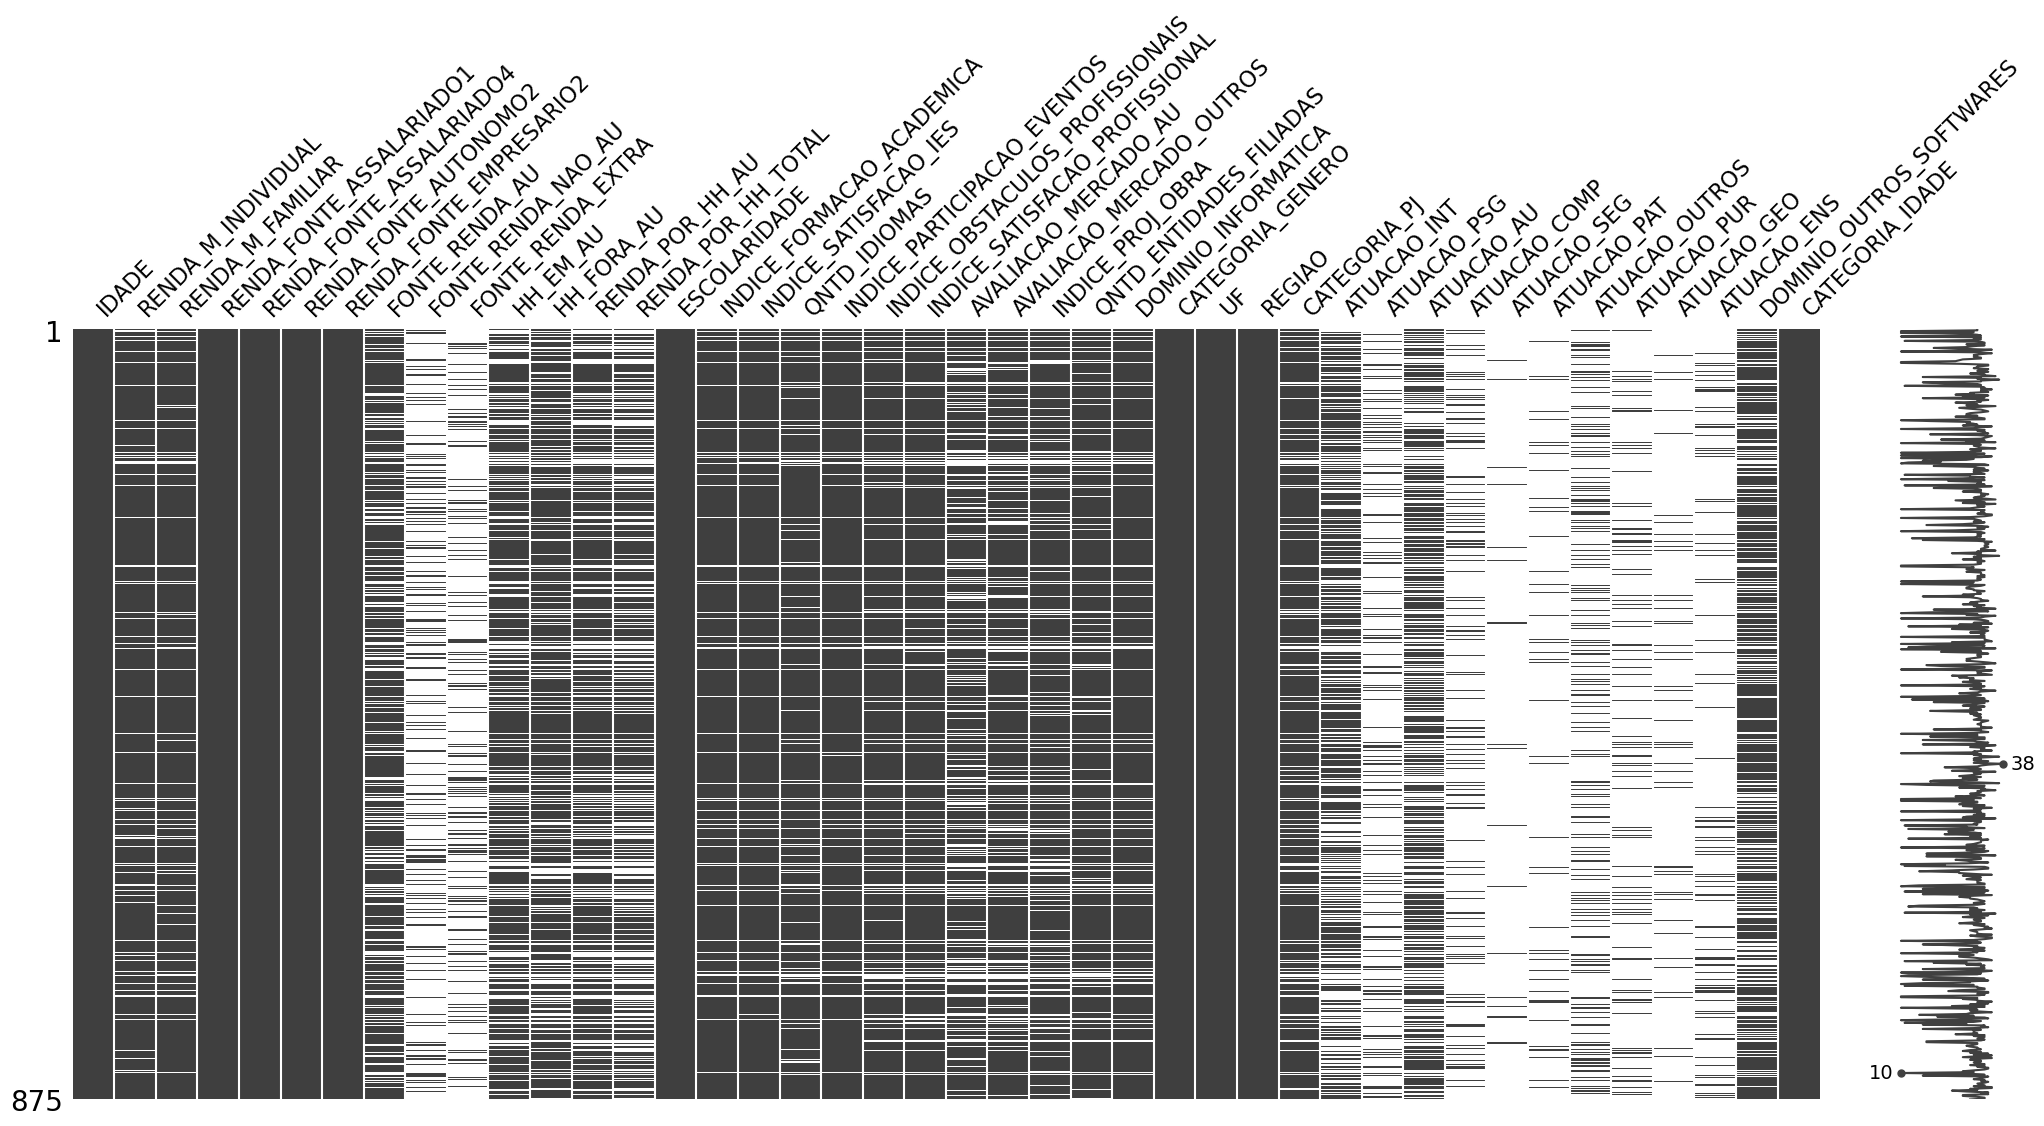

In [11]:
msno.matrix(df_2_eda)

## Outliers

In [12]:
print((df_2_eda.isna().sum() / len(df_2_eda)).sort_values(ascending=False))

ATUACAO_SEG                        0.976000
ATUACAO_PAT                        0.945143
ATUACAO_GEO                        0.942857
ATUACAO_ENS                        0.891429
ATUACAO_PUR                        0.876571
ATUACAO_COMP                       0.844571
ATUACAO_PSG                        0.826286
FONTE_RENDA_EXTRA                  0.820571
FONTE_RENDA_NAO_AU                 0.809143
ATUACAO_OUTROS                     0.796571
ATUACAO_AU                         0.422857
ATUACAO_INT                        0.404571
RENDA_POR_HH_TOTAL                 0.385143
DOMINIO_OUTROS_SOFTWARES           0.308571
RENDA_POR_HH_AU                    0.299429
HH_EM_AU                           0.286857
AVALIACAO_MERCADO_AU               0.264000
HH_FORA_AU                         0.262857
FONTE_RENDA_AU                     0.246857
AVALIACAO_MERCADO_OUTROS           0.211429
INDICE_PROJ_OBRA                   0.204571
QNTD_ENTIDADES_FILIADAS            0.156571
CATEGORIA_PJ                    

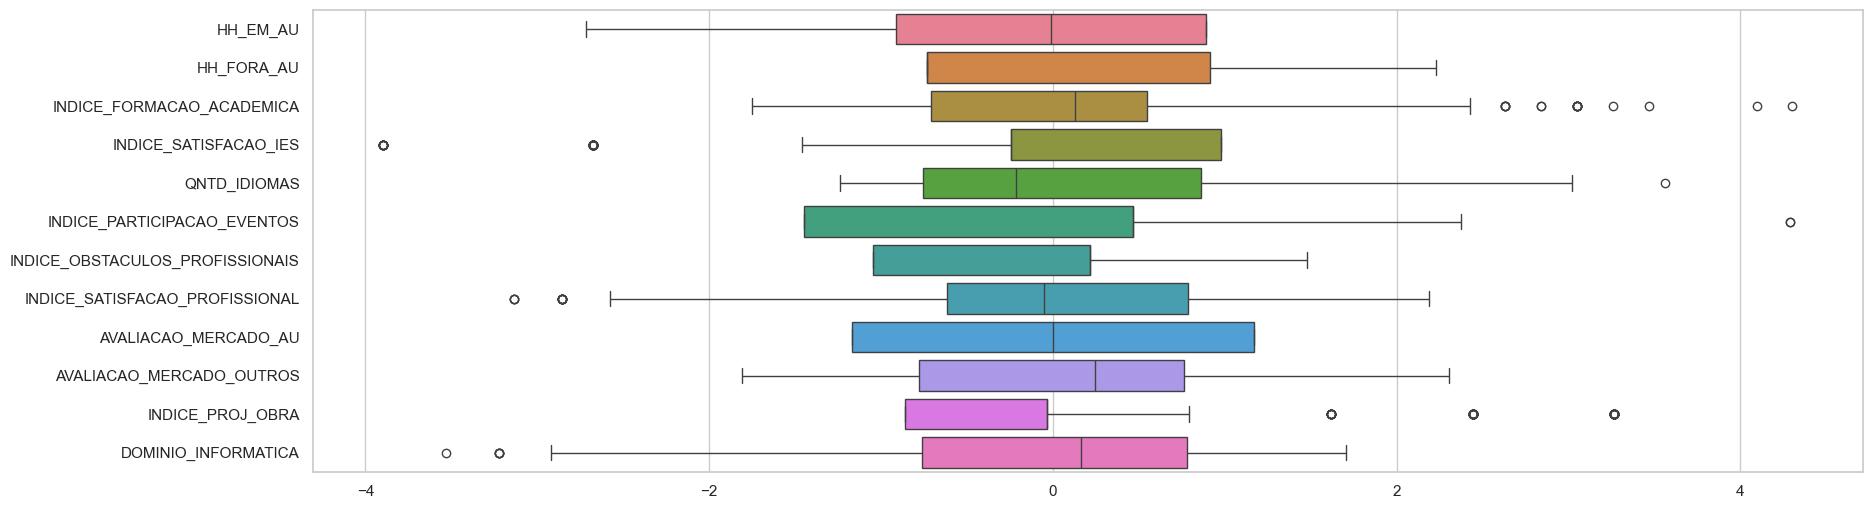

In [8]:
sns.set_theme(style="whitegrid")

df_outliers = df_2_eda.select_dtypes(include = ['float'])
df_outliers['CATEGORIA_IDADE'] = df_2_eda['CATEGORIA_IDADE']

#msno.dendrogram(df_2_eda.dropna(thresh=thresh_val,axis=0))
lista_drop = df_outliers.filter(regex='^ATUACAO|^RENDA|^FONTE').columns.tolist() + ['CATEGORIA_IDADE','QNTD_ENTIDADES_FILIADAS','DOMINIO_OUTROS_SOFTWARES']
df_outliers.drop(columns=lista_drop, axis=1, inplace=True)

#df_outliers = (df_outliers - df_outliers.min()) / (df_outliers.max() - df_outliers.min())
df_outliers = (df_outliers - df_outliers.mean()) / df_outliers.std()

plt.figure(figsize=(20, 6))
sns.boxplot(
    data=df_outliers,
    orient='h'
)

arquivo = 'OUTLIERS_0.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

In [14]:
#df_outliers.drop(columns=df_outliers.filter(regex='^ATUACAO|^RENDA').columns.tolist(), axis=1, inplace=False).drop(columns=['CATEGORIA_IDADE','QNTD_ENTIDADES_FILIADAS'], axis=1, inplace=False)
#df_outliers.drop(columns=df_outliers.filter(regex='^ATUACAO|^RENDA').columns.tolist(), axis=1, inplace=False), axis=1, inplace=False)


<Axes: >

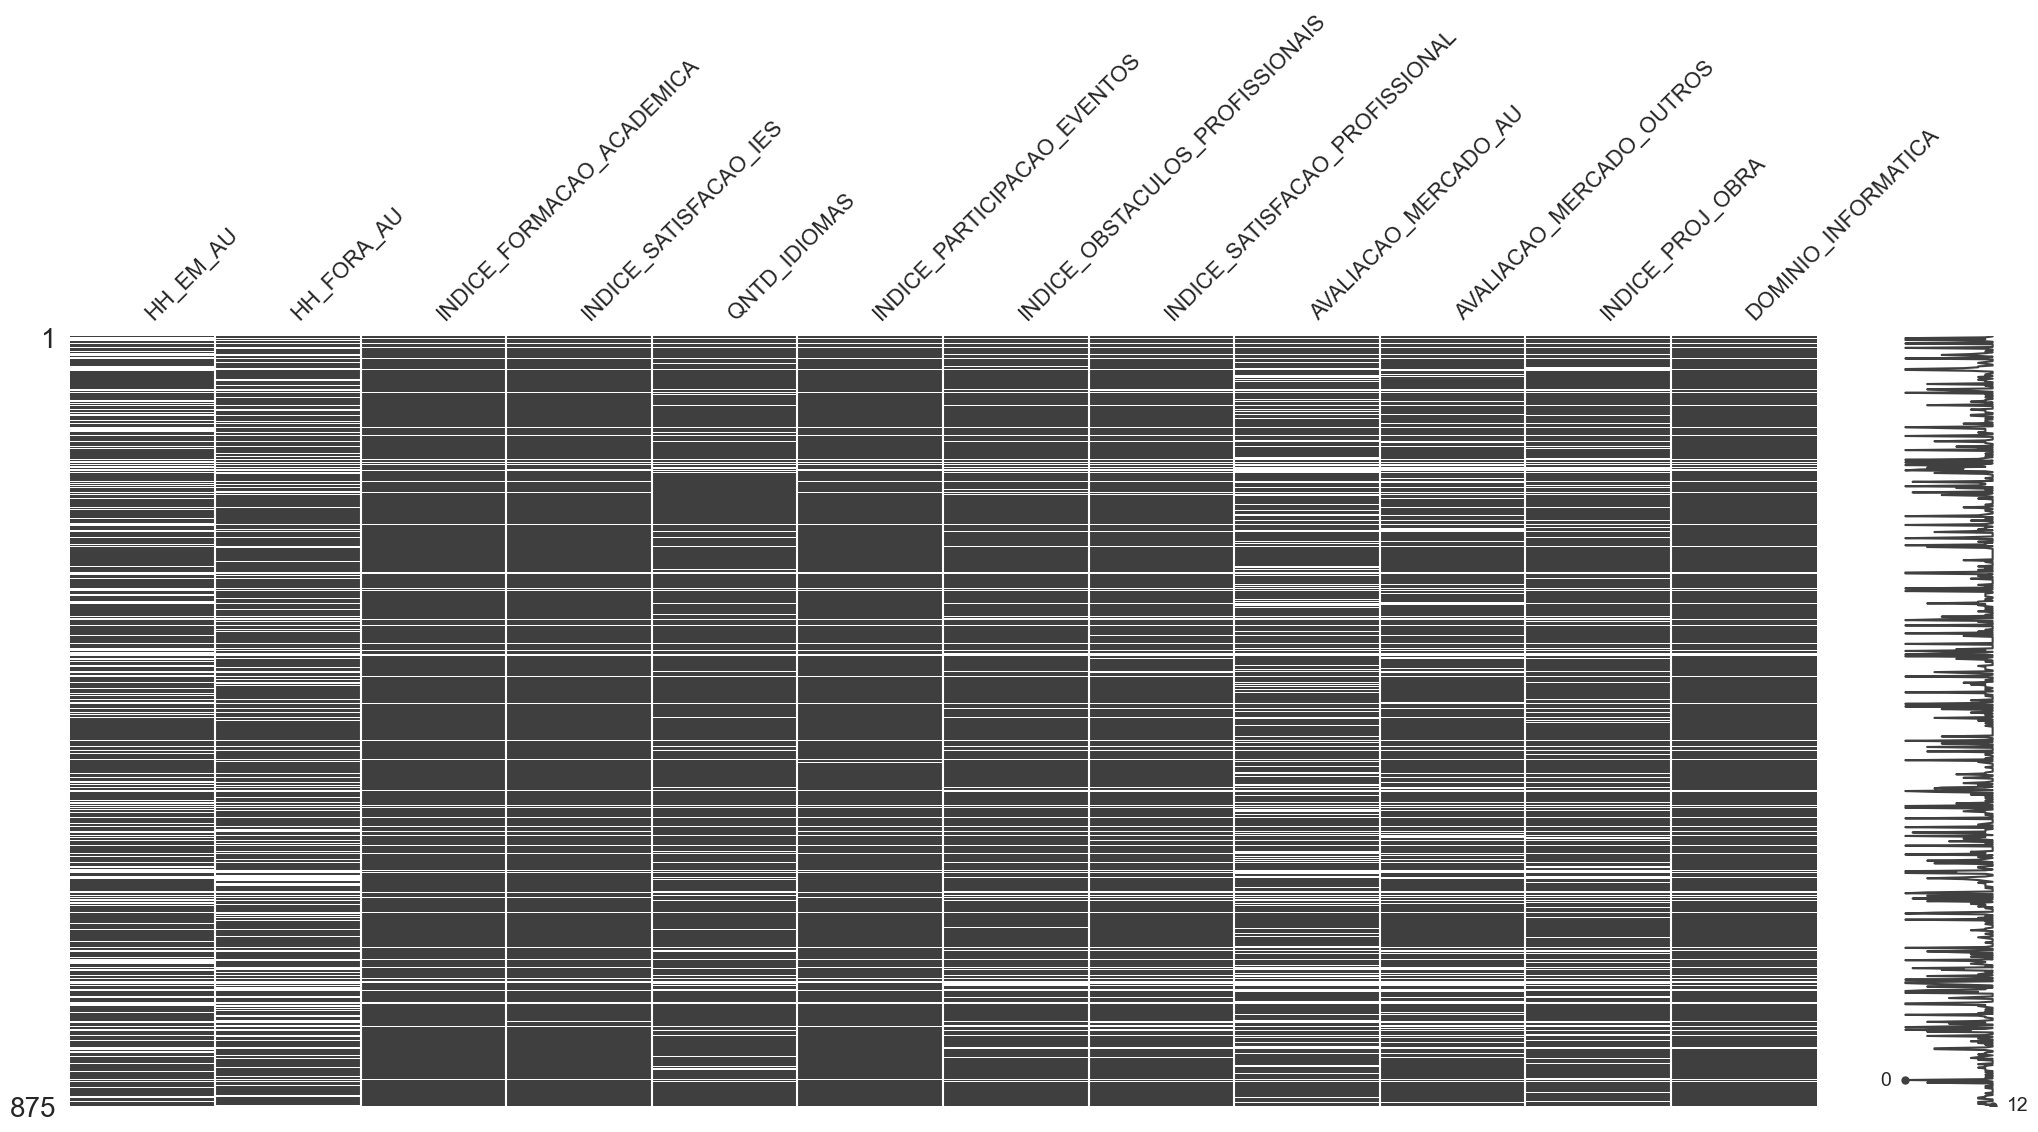

In [15]:
msno.matrix(df_outliers)

In [9]:
df_outliers.fillna(value=0,inplace=True)
np.abs(stats.zscore(df_outliers) < 3)

HH_EM_AU  HH_FORA_AU  INDICE_FORMACAO_ACADEMICA  INDICE_SATISFACAO_IES  \
32         True        True                       True                   True   
156        True        True                       True                   True   
165        True        True                       True                   True   
193        True        True                       True                   True   
328        True        True                       True                   True   
...         ...         ...                        ...                    ...   
45273      True        True                       True                   True   
45278      True        True                       True                   True   
45346      True        True                       True                   True   
45353      True        True                       True                   True   
45354      True        True                       True                   True   

       QNTD_IDIOMAS  INDICE_PARTICIPACAO_EVENTOS  \
32             True                         True   
156            True                         True   
165            True                         True   
193            True                         True   
328            True                         True   
...             ...                          ...   
45273          True                         True   
45278          True                         True   
45346          True                         True   
45353          True                         True   
45354          True                         True   

       INDICE_OBSTACULOS_PROFISSIONAIS  INDICE_SATISFACAO_PROFISSIONAL  \
32                                True                            True   
156                               True                            True   
165                               True                            True   
193                               True                            True   
328                               True                            True   
...                                ...                             ...   
45273                             True                            True   
45278                             True                            True   
45346                             True                            True   
45353                             True                            True   
45354                             True                            True   

       AVALIACAO_MERCADO_AU  AVALIACAO_MERCADO_OUTROS  INDICE_PROJ_OBRA  \
32                     True                      True              True   
156                    True                      True              True   
165                    True                      True              True   
193                    True                      True             False   
328                    True                      True              True   
...                     ...                       ...               ...   
45273                  True                      True              True   
45278                  True                      True              True   
45346                  True                      True              True   
45353                  True                      True              True   
45354                  True                      True              True   

       DOMINIO_INFORMATICA  
32                    True  
156                   True  
165                   True  
193                   True  
328                   True  
...                    ...  
45273                 True  
45278                 True  
45346                 True  
45353                 True  
45354                 True  

[875 rows x 12 columns]

In [10]:
(np.abs(stats.zscore(df_outliers)) < 3).all(axis=1)

32        True
156       True
165       True
193      False
328       True
         ...  
45273     True
45278     True
45346     True
45353     True
45354     True
Length: 875, dtype: bool

In [11]:
df_2_eda_ajustada = df_2_eda[(np.abs(stats.zscore(df_outliers)) < 3).all(axis=1)].copy()
df_2_eda_ajustada.shape

(783, 42)

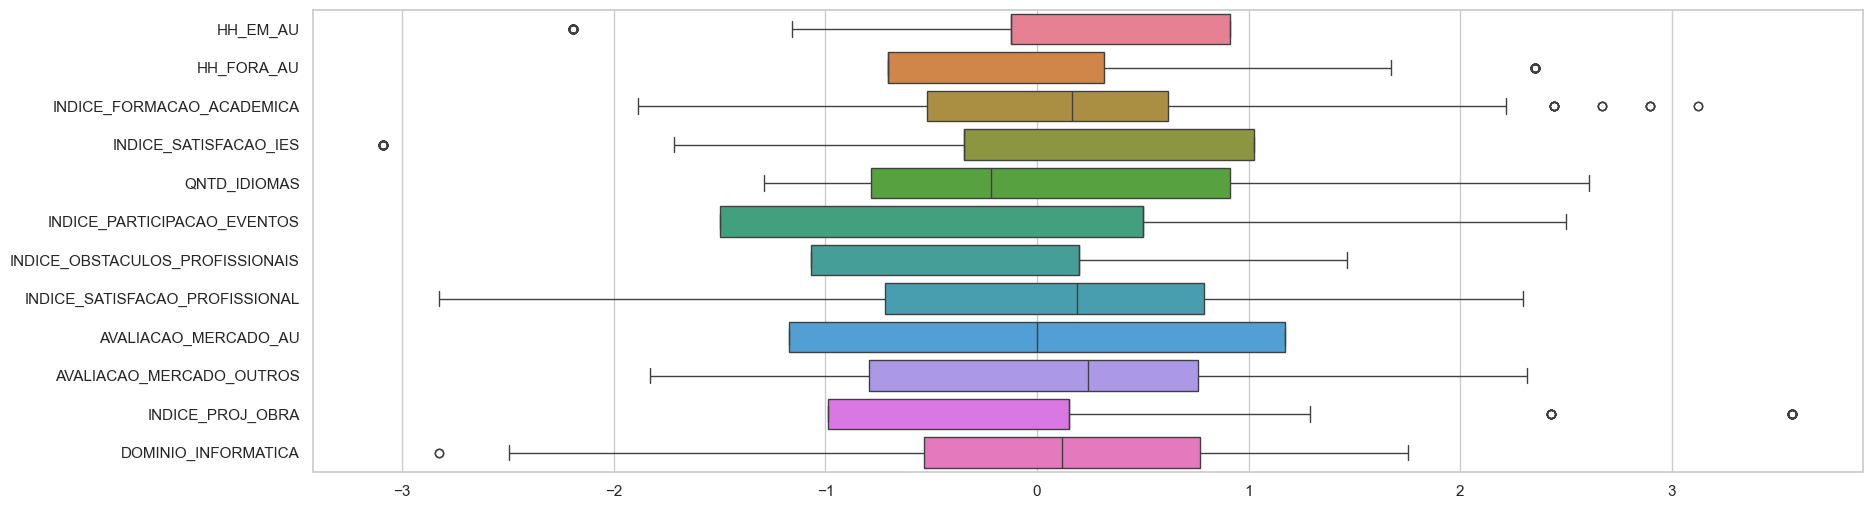

In [12]:
sns.set_theme(style="whitegrid")

df_outliers_2 = df_2_eda_ajustada.select_dtypes(include = ['float'])

lista_drop = df_outliers_2.filter(regex='^ATUACAO|^RENDA|^FONTE').columns.tolist() + ['QNTD_ENTIDADES_FILIADAS','DOMINIO_OUTROS_SOFTWARES']
df_outliers_2.drop(columns=lista_drop, axis=1, inplace=True)

#df_outliers_2 = (df_outliers_2 - df_outliers_2.min()) / (df_outliers_2.max() - df_outliers_2.min())
df_outliers_2 = (df_outliers_2 - df_outliers_2.mean()) / df_outliers_2.std()

plt.figure(figsize=(20, 6))
sns.boxplot(
    data=df_outliers_2,
    orient='h'
)

arquivo = 'OUTLIERS_1_STD.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

<Axes: >

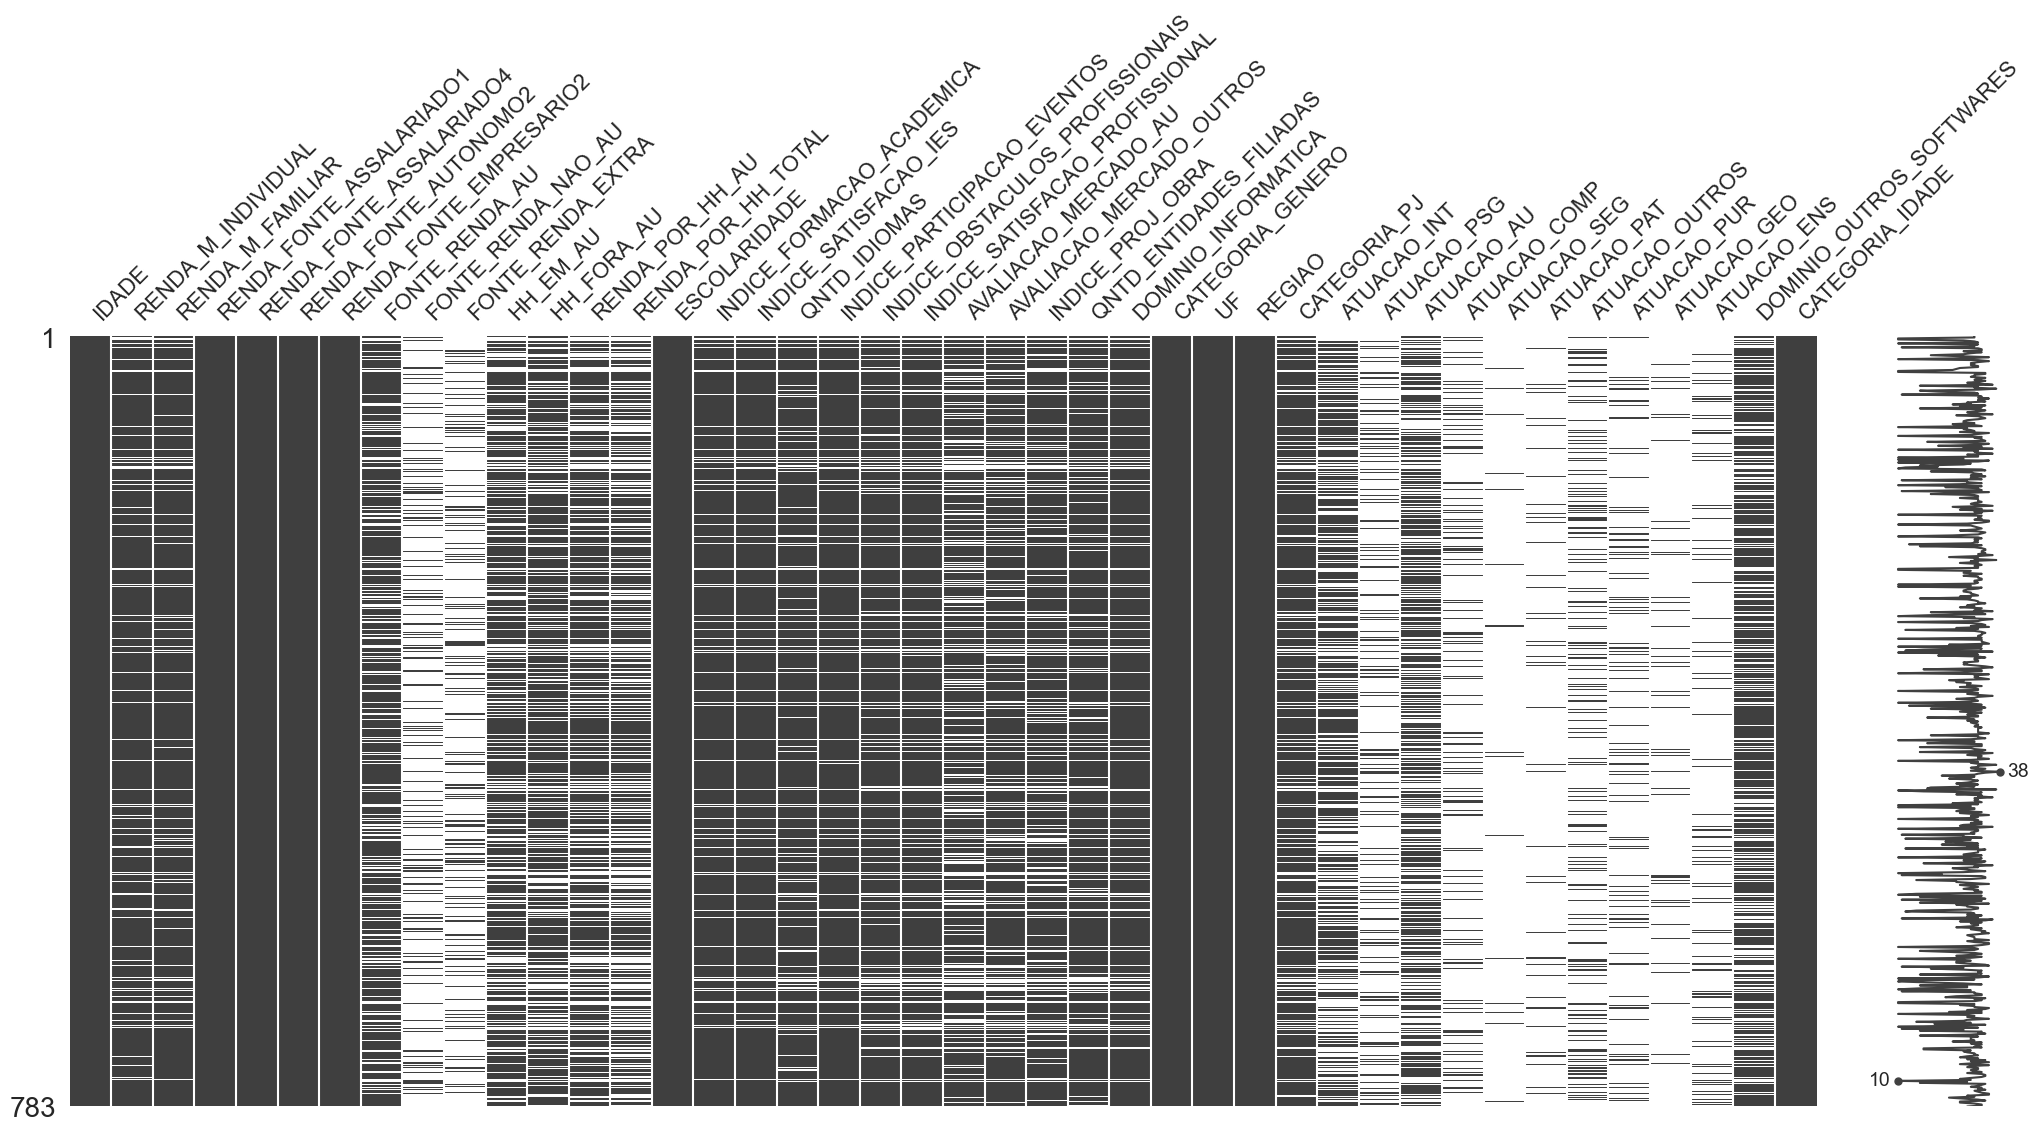

In [20]:
#msno.matrix(df_outliers)
msno.matrix(df_2_eda_ajustada)

In [21]:
df_2_eda_ajustada.describe().transpose()

count       mean        std     min   25%  \
IDADE                            783.0  34.240102  10.143400  22.000  27.0   
RENDA_M_INDIVIDUAL               706.0   3.398017   1.262193   1.000   3.0   
RENDA_M_FAMILIAR                 703.0   4.871977   1.627960   1.000   4.0   
RENDA_FONTE_ASSALARIADO1         783.0   0.019157   0.137165   0.000   0.0   
RENDA_FONTE_ASSALARIADO4         783.0   0.034483   0.182582   0.000   0.0   
RENDA_FONTE_AUTONOMO2            783.0   0.089400   0.285502   0.000   0.0   
RENDA_FONTE_EMPRESARIO2          783.0   0.040868   0.198112   0.000   0.0   
FONTE_RENDA_AU                   600.0   1.126667   0.370834   1.000   1.0   
FONTE_RENDA_NAO_AU               135.0   1.066667   0.304199   1.000   1.0   
FONTE_RENDA_EXTRA                143.0   1.048951   0.216524   1.000   1.0   
HH_EM_AU                         549.0   4.120219   0.966657   2.000   4.0   
HH_FORA_AU                       564.0   1.537234   1.471891   0.500   0.5   
RENDA_POR_HH_AU                  540.0   0.895864   0.357766   0.200   0.6   
RENDA_POR_HH_TOTAL               469.0   0.665296   0.245402   0.125   0.5   
ESCOLARIDADE                     783.0   1.426564   0.618892   1.000   1.0   
INDICE_FORMACAO_ACADEMICA        715.0   9.276923   4.391099   1.000   7.0   
INDICE_SATISFACAO_IES            713.0   4.252454   0.729166   2.000   4.0   
QNTD_IDIOMAS                     677.0   2.386558   1.768983   0.100   1.0   
INDICE_PARTICIPACAO_EVENTOS      712.0   1.748596   0.500350   1.000   1.0   
INDICE_OBSTACULOS_PROFISSIONAIS  666.0   1.842342   0.789447   1.000   1.0   
INDICE_SATISFACAO_PROFISSIONAL   665.0  12.378947   3.317648   3.000  10.0   
AVALIACAO_MERCADO_AU             567.0   2.000000   0.853179   1.000   1.0   
AVALIACAO_MERCADO_OUTROS         610.0   4.532787   1.930587   1.000   3.0   
INDICE_PROJ_OBRA                 615.0   1.868293   0.877080   1.000   1.0   
QNTD_ENTIDADES_FILIADAS          653.0   0.231240   0.450090   0.000   0.0   
DOMINIO_INFORMATICA              688.0  14.640988   3.059413   6.000  13.0   
ATUACAO_INT                      470.0   1.000000   0.000000   1.000   1.0   
ATUACAO_PSG                      141.0   1.000000   0.000000   1.000   1.0   
ATUACAO_AU                       454.0   1.000000   0.000000   1.000   1.0   
ATUACAO_COMP                     120.0   1.000000   0.000000   1.000   1.0   
ATUACAO_SEG                       16.0   1.000000   0.000000   1.000   1.0   
ATUACAO_PAT                       43.0   1.000000   0.000000   1.000   1.0   
ATUACAO_OUTROS                   156.0   1.000000   0.000000   1.000   1.0   
ATUACAO_PUR                       93.0   1.000000   0.000000   1.000   1.0   
ATUACAO_GEO                       44.0   1.000000   0.000000   1.000   1.0   
ATUACAO_ENS                       81.0   1.000000   0.000000   1.000   1.0   
DOMINIO_OUTROS_SOFTWARES         545.0   3.941284   0.735298   1.000   4.0   

                                       50%   75%        max  
IDADE                            31.000000  39.0  73.000000  
RENDA_M_INDIVIDUAL                3.000000   4.0   7.000000  
RENDA_M_FAMILIAR                  4.000000   6.0   8.000000  
RENDA_FONTE_ASSALARIADO1          0.000000   0.0   1.000000  
RENDA_FONTE_ASSALARIADO4          0.000000   0.0   1.000000  
RENDA_FONTE_AUTONOMO2             0.000000   0.0   1.000000  
RENDA_FONTE_EMPRESARIO2           0.000000   0.0   1.000000  
FONTE_RENDA_AU                    1.000000   1.0   4.000000  
FONTE_RENDA_NAO_AU                1.000000   1.0   3.000000  
FONTE_RENDA_EXTRA                 1.000000   1.0   2.000000  
HH_EM_AU                          4.000000   5.0   5.000000  
HH_FORA_AU                        0.500000   2.0   5.000000  
RENDA_POR_HH_AU                   0.800000   1.0   3.000000  
RENDA_POR_HH_TOTAL                0.666667   0.8   1.555556  
ESCOLARIDADE                      1.000000   2.0   5.000000  
INDICE_FORMACAO_ACADEMICA        10.000000  12.0  23.000000  
INDICE_SATISFA

## 2.2 Correlação de Pearson e Gráficos de Dispersão

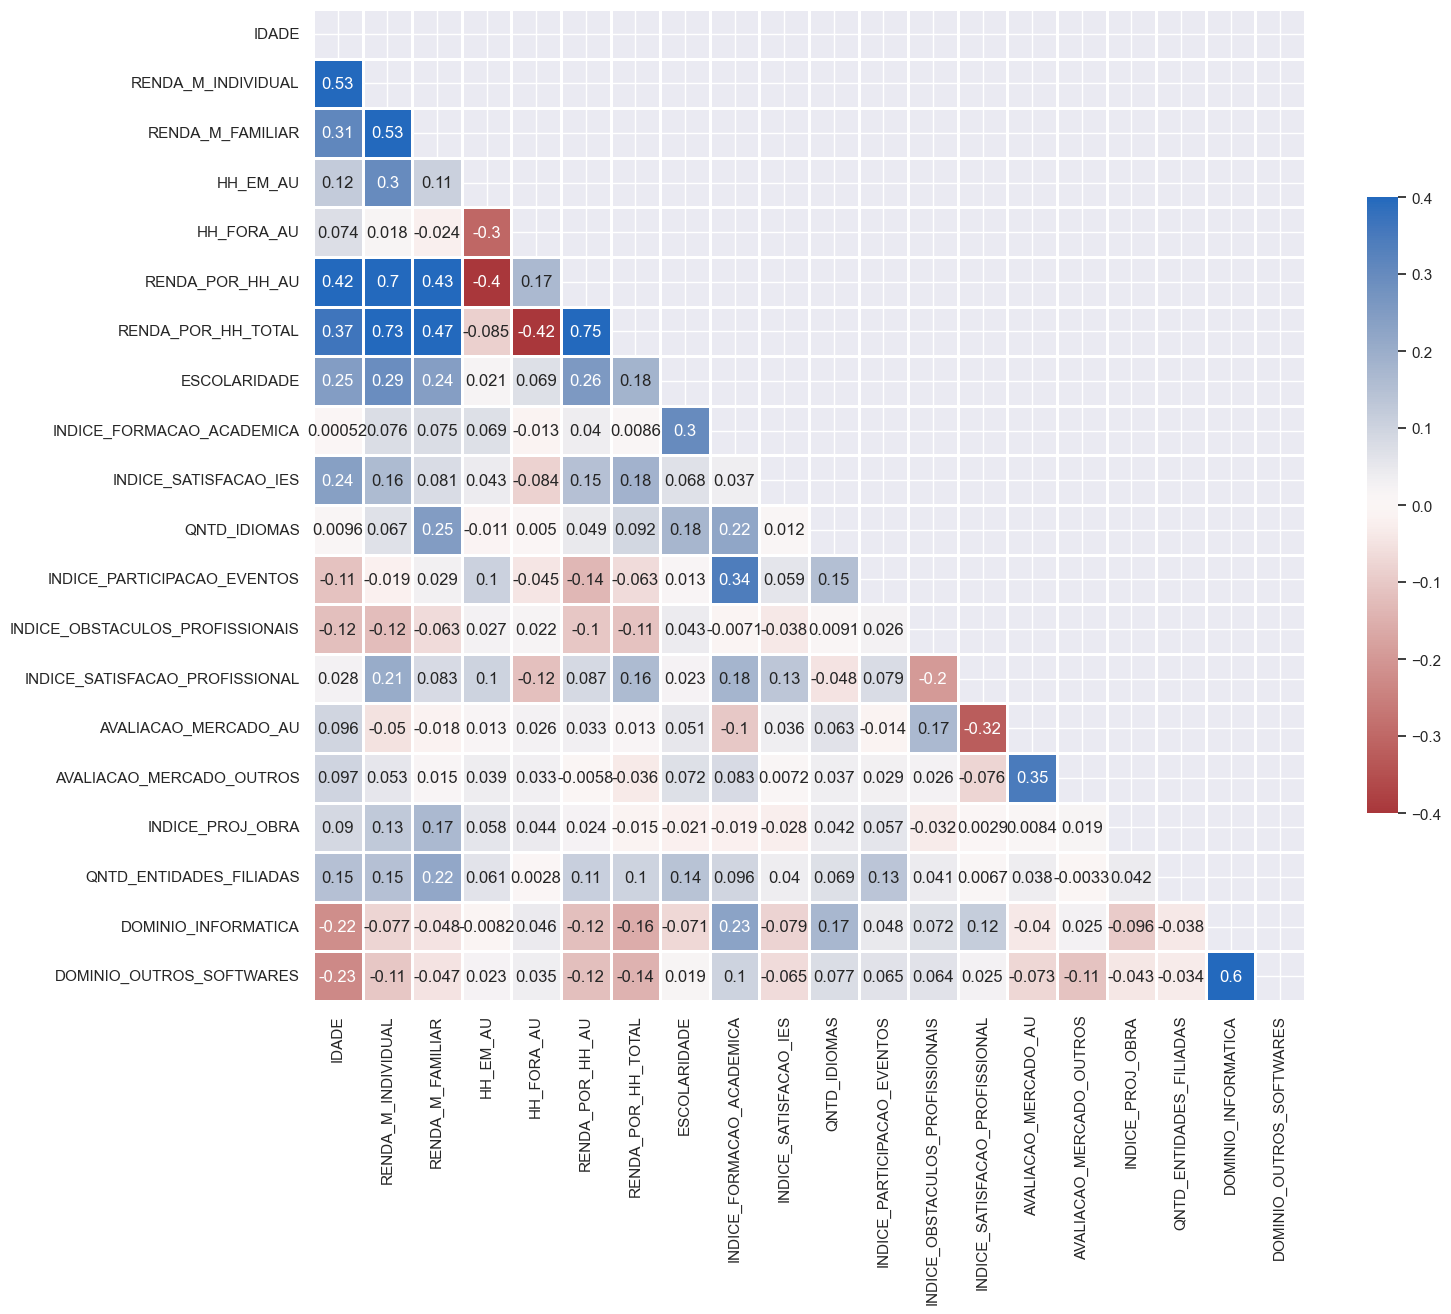

In [13]:
sns.set_theme(style="darkgrid")

lista_drop = df_2_eda_ajustada.filter(regex='^ATUACAO|^RENDA_FONTE|^FONTE_RENDA|^CATEGORIA').columns.tolist() + ['UF','REGIAO']
#'QNTD_ENTIDADES_FILIADAS','DOMINIO_OUTROS_SOFTWARES',
df_sns = df_2_eda_ajustada.drop(columns=lista_drop, axis=1, inplace=False)
#.drop(columns=lista_drop, axis=1, inplace=True)
#df_sns = df_2_eda

#df_sns = df_2_eda.drop(labels=['ATUACAO_ENS','ATUACAO_PUR','ATUACAO_OUTROS','ATUACAO_GEO','ATUACAO_GEO','ATUACAO_GEO','ATUACAO_COMP','ATUACAO_SEG','ATUACAO_PAT','ATUACAO_GEO','ATUACAO_PSG','ATUACAO_INT','ATUACAO_AU','REGIAO','UF','CATEGORIA_IDADE','CATEGORIA_PJ','CATEGORIA_GENERO'],axis=1)
metodo = 'spearman'
corr = df_sns.corr(method=metodo)
#corr = df_sns.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(16, 16))

cmap = sns.color_palette("vlag_r", as_cmap=True)
#cmap = sns.color_palette("viridis", as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4, vmin=-.4, center=0,
            annot=True, square=True, linewidths=.9, cbar_kws={"shrink": .5})

arquivo = f'CORR_HEATMAP_{metodo.upper()}_OUTLIERS_REDUZIDOS.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

In [13]:
dict_fillna = {
    'IDADE': np.nan, 'RENDA_M_INDIVIDUAL':0, 'RENDA_M_FAMILIAR':0, 'FONTE_RENDA_AU':0, 'FONTE_RENDA_NAO_AU':0, 'FONTE_RENDA_EXTRA':0,
    'HH_EM_AU': np.nan,'HH_FORA_AU': np.nan,'RENDA_POR_HH_TOTAL': np.nan, 'ESCOLARIDADE': 0,
    'INDICE_FORMACAO_ACADEMICA': np.nan, 'INDICE_OBSTACULOS_PROFISSIONAIS': np.nan, 'INDICE_SATISFACAO_PROFISSIONAL': np.nan, 
    'AVALIACAO_MERCADO_AU': np.nan, 'AVALIACAO_MERCADO_OUTROS': np.nan, 'INDICE_PROJ_OBRA': np.nan,
    'QNTD_ENTIDADES_FILIADAS': 0,'DOMINIO_INFORMATICA': 0,'CATEGORIA_GENERO': 'INDEF',
    'UF': np.nan, 'REGIAO': np.nan, 'CATEGORIA_PJ': 'NAO', 'QNTD_IDIOMAS': 1, 'QNTD_ENTIDADES_FILIADAS': 0,
    'ATUACAO_INT': 0, 'ATUACAO_PSG': 0, 'ATUACAO_AU': 0, 'ATUACAO_COMP': 0, 'ATUACAO_SEG': 0, 'ATUACAO_PAT': 0, 'ATUACAO_OUTROS': 0, 'ATUACAO_PUR': 0,
    'ATUACAO_GEO': 0, 'ATUACAO_ENS': 0,#'CATEGORIA_IDADE': 0
              }

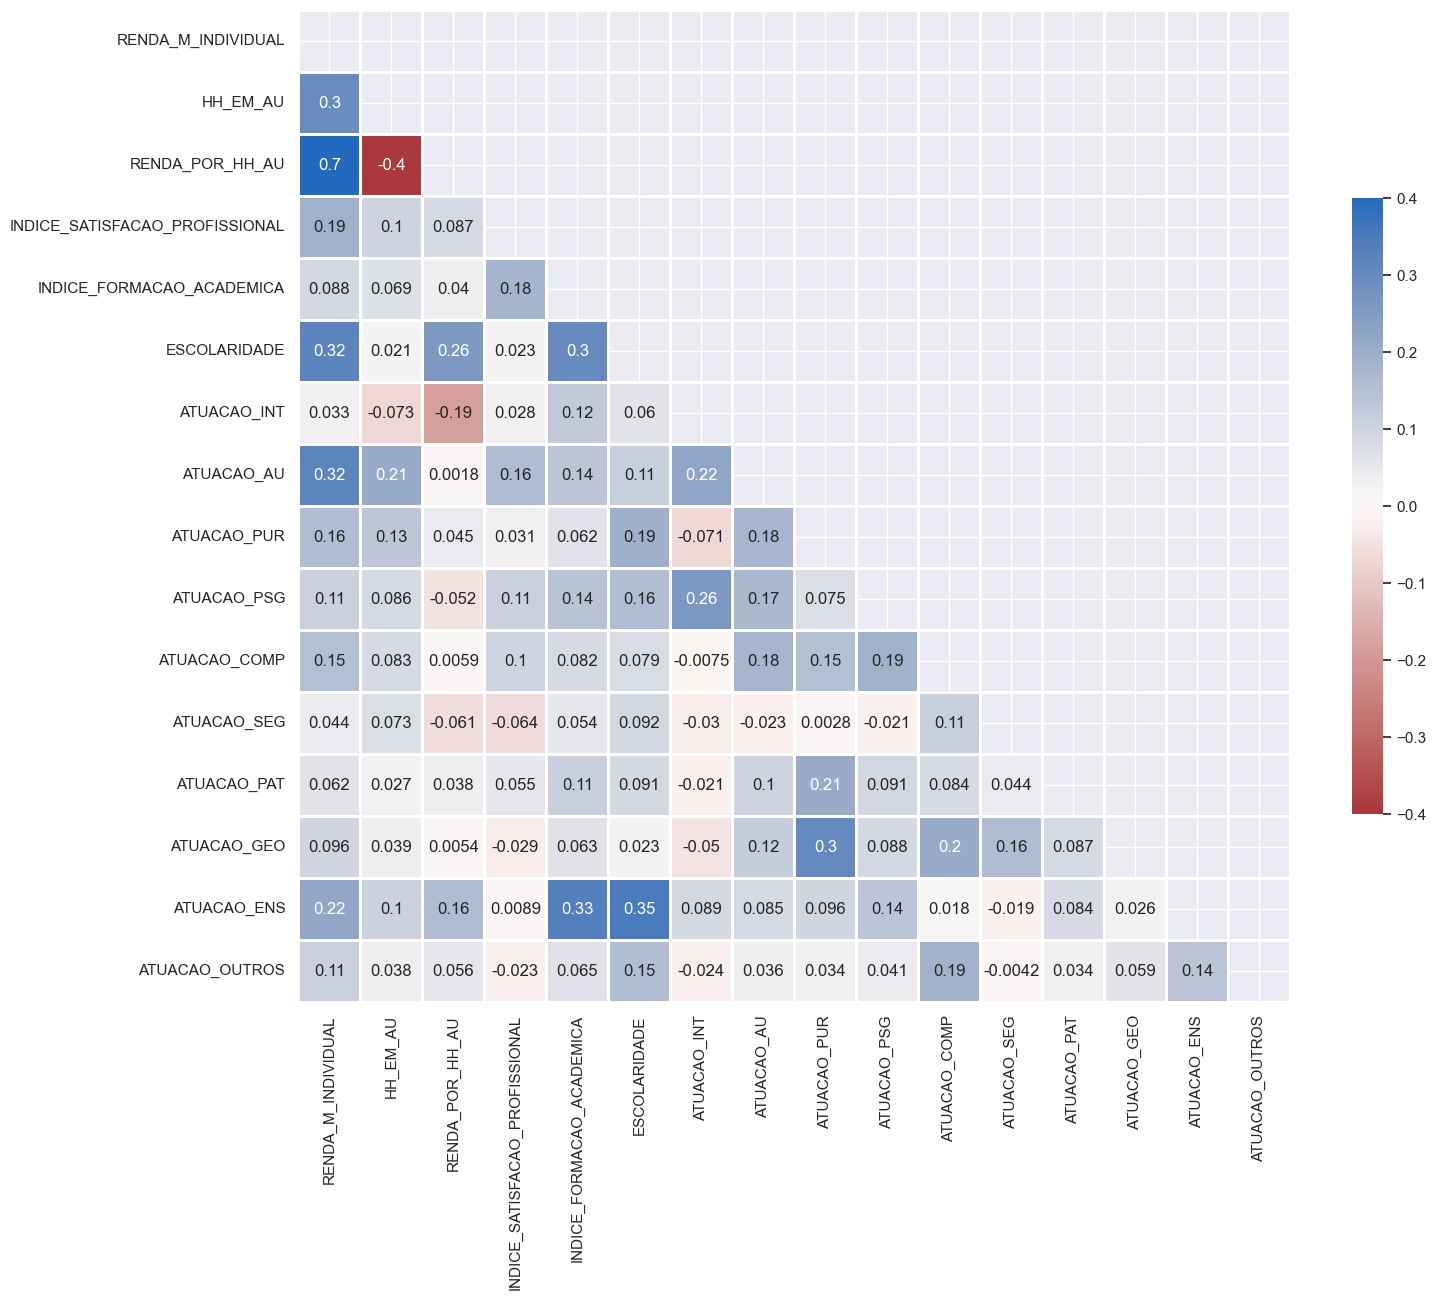

In [128]:
sns.set_theme(style="darkgrid")

df_sns = df_2_eda_ajustada[['RENDA_M_INDIVIDUAL','HH_EM_AU','RENDA_POR_HH_AU','INDICE_SATISFACAO_PROFISSIONAL','INDICE_FORMACAO_ACADEMICA','ESCOLARIDADE','ATUACAO_INT','ATUACAO_AU','ATUACAO_PUR','ATUACAO_PSG','ATUACAO_COMP','ATUACAO_SEG','ATUACAO_PAT','ATUACAO_GEO','ATUACAO_ENS','ATUACAO_OUTROS']].copy()
df_sns.fillna(value=dict_fillna,inplace=True)

metodo = 'spearman'

corr = df_sns.corr(method=metodo)
#corr = df_sns.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(16, 16))

cmap = sns.color_palette("vlag_r", as_cmap=True)
#cmap = sns.color_palette("viridis", as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4, vmin=-.4, center=0,
            annot=True, square=True, linewidths=.9, cbar_kws={"shrink": .5})

arquivo = f'CORR_HEATMAP_{metodo.upper()}_FILLNA.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

## 2.3 Medidas de Tendência Central e Testes de Distribuições

In [14]:
dic = {'IDADE': 'median', 'RENDA_M_INDIVIDUAL': 'mean','HH_EM_AU': 'mean','INDICE_SATISFACAO_PROFISSIONAL': 'mean', 'INDICE_FORMACAO_ACADEMICA': 'mean'}
df_2_eda_ajustada[list(dic.keys())].describe().transpose()

count       mean        std   min   25%   50%  \
IDADE                           783.0  34.240102  10.143400  22.0  27.0  31.0   
RENDA_M_INDIVIDUAL              706.0   3.398017   1.262193   1.0   3.0   3.0   
HH_EM_AU                        549.0   4.120219   0.966657   2.0   4.0   4.0   
INDICE_SATISFACAO_PROFISSIONAL  665.0  12.378947   3.317648   3.0  10.0  13.0   
INDICE_FORMACAO_ACADEMICA       715.0   9.276923   4.391099   1.0   7.0  10.0   

                                 75%   max  
IDADE                           39.0  73.0  
RENDA_M_INDIVIDUAL               4.0   7.0  
HH_EM_AU                         5.0   5.0  
INDICE_SATISFACAO_PROFISSIONAL  15.0  20.0  
INDICE_FORMACAO_ACADEMICA       12.0  23.0

In [26]:
def testes(coluna_analisada, alfa, amostra):
    alpha = alfa

    amostra_norm = False
    amostra_testes = []
    
    x = 0 
    while x <= 1:
        if x == 0:
            teste_nome = 'Kolmogorov-Smirnov'
            statistic, p_value = stats.kstest(amostra, 'norm')
        if x == 1:
            teste_nome = 'Shapiro-Wilk'
            statistic, p_value = stats.shapiro(amostra)

        p_value_formatted = "{:.5f}".format(p_value)
        print(f">>> Resultados do teste de {teste_nome} para AMOSTRA 1 avaliando {coluna_analisada}:")
        print(f"Estatística do teste {teste_nome}: {statistic} obtendo valor p {p_value_formatted} em nível de significância de {1 - alfa}")
        if p_value < alpha:
            print("A hipótese nula foi rejeitada.")
            #print("A amostra não parece ser proveniente de uma distribuição normal.\n")
        else:
            amostra_norm = True
            amostra_testes.append(teste_nome)
            #print("Não há evidências para rejeitar a hipótese nula.")
            #print("A amostra parece ser proveniente de uma distribuição normal.\n")
        x += 1
    print(f"É possível afirmar que AMOSTRA 1 segue uma distribuiçao normal? {amostra_norm}\n")
    if amostra_norm == False:
        dados_observados = amostra1.tolist()
        media_amostra = np.mean(dados_observados)
        variancia_amostra = np.var(dados_observados)

        chi2_stat, p_value = stats.chisquare(dados_observados, f_exp=np.repeat(media_amostra, len(dados_observados)))

        # Imprima os resultados do teste
        print(">>> Resultados do teste Chi-Quadrado para AMOSTRA 1 avaliando Distribuição de Poisson:")
        print(f"Estatística {chi2_stat} obtendo valor p {p_value} em nível de significância de {1 - alfa}")
        if p_value < alfa:
            print("Rejeita-se a hipótese nula.")
            print("A amostra não parece seguir uma distribuição de Poisson.\n")
        else:
            print("Não há evidências para rejeitar a hipótese nula.")
            print("A amostra parece seguir uma distribuição de Poisson.\n")
    return

In [27]:
colunas_analisadas = list(dic.keys())

for coluna in colunas_analisadas:
    amostra = df_2_eda_ajustada[coluna].dropna()

    testes(coluna, 0.05, amostra)

>>> Resultados do teste de Kolmogorov-Smirnov para AMOSTRA 1 avaliando IDADE:
Estatística do teste Kolmogorov-Smirnov: 1.0 obtendo valor p 0.00000 em nível de significância de 0.95
A hipótese nula foi rejeitada.
>>> Resultados do teste de Shapiro-Wilk para AMOSTRA 1 avaliando IDADE:
Estatística do teste Shapiro-Wilk: 0.8413805961608887 obtendo valor p 0.00000 em nível de significância de 0.95
A hipótese nula foi rejeitada.
É possível afirmar que AMOSTRA 1 segue uma distribuiçao normal? False



NameError: name 'amostra1' is not defined

### 2.3.1 Análise de Categorias de Gênero

In [44]:
df_2_eda_ajustada.groupby('CATEGORIA_GENERO').agg(dic)

IDADE  RENDA_M_INDIVIDUAL  HH_EM_AU  \
CATEGORIA_GENERO                                        
H                  31.0            3.620968  4.283721   
INDEF              33.0            3.390244  4.046875   
M                  29.0            3.235821  4.007407   

                  INDICE_SATISFACAO_PROFISSIONAL  INDICE_FORMACAO_ACADEMICA  
CATEGORIA_GENERO                                                             
H                                      12.759843                  10.023346  
INDEF                                  11.911392                   7.508333  
M                                      12.198795                   9.337278

In [45]:
serie = df_2_eda_ajustada.query('CATEGORIA_GENERO == "H"')['RENDA_M_INDIVIDUAL'].dropna()
quntd_bins = int(serie.max() - serie.min())
quntd_bins

6

In [46]:
df_2_eda_ajustada.query('CATEGORIA_GENERO != "INDEF"')[['RENDA_M_INDIVIDUAL', 'CATEGORIA_GENERO']].dropna()

RENDA_M_INDIVIDUAL CATEGORIA_GENERO
32                    4.0                M
340                   3.0                M
414                   2.0                M
416                   2.0                M
441                   4.0                M
...                   ...              ...
45066                 4.0                H
45137                 4.0                H
45271                 5.0                M
45278                 5.0                M
45353                 3.0                M

[583 rows x 2 columns]

### Testes Paramétricos para Verificação de Normalidade / Renda Média Individual

In [132]:
import numpy as np
from scipy import stats

sample = df_2_eda_ajustada['RENDA_M_INDIVIDUAL'].dropna()

shapiro_stat, shapiro_p_value = stats.shapiro(sample)
print("Teste de Shapiro-Wilk:")
print(f"Estatística de teste: {shapiro_stat}")
print(f"Valor-p: {'{:.10f}'.format(shapiro_p_value)}")
print(f"Hipótese Nula (H0) : X~N(μ,σ^2)")
if shapiro_p_value < 0.05:
    print("Os dados NÃO são normalmente distribuídos (rejeita H0)")
else:
    print("Os dados são normalmente distribuídos (não rejeita H0)")

dagostino_stat, dagostino_p_value = stats.normaltest(sample)
print("\nTeste de D'Agostino-Pearson:")
print("Estatística de teste:", dagostino_stat)
print("Valor-p:", "{:.10f}".format(dagostino_p_value))
print(f"Hipótese Nula (H0) : X~N(μ,σ^2)")
if dagostino_p_value < 0.05:
    print("Os dados NÃO são normalmente distribuídos (rejeita H0)")
else:
    print("Os dados são normalmente distribuídos (não rejeita H0)")

anderson_stat, anderson_critical_values, anderson_significance_level = stats.anderson(sample)
print("\nTeste de Anderson-Darling:")
print("Estatística de teste:", anderson_stat)
print("Valores críticos:", anderson_critical_values)
print("Níveis de significância:", anderson_significance_level)
print(f"Hipótese Nula (H0) : X~N(μ,σ^2)")
if anderson_stat > anderson_critical_values[2]:
    print("Os dados NÃO são normalmente distribuídos (rejeita H0)")
else:
    print("Os dados são normalmente distribuídos (não rejeita H0)")

Teste de Shapiro-Wilk:
Estatística de teste: 0.9225295782089233
Valor-p: 0.0000000000
Hipótese Nula (H0) : X~N(μ,σ^2)
Os dados NÃO são normalmente distribuídos (rejeita H0)

Teste de D'Agostino-Pearson:
Estatística de teste: 28.543980755864816
Valor-p: 0.0000006335
Hipótese Nula (H0) : X~N(μ,σ^2)
Os dados NÃO são normalmente distribuídos (rejeita H0)

Teste de Anderson-Darling:
Estatística de teste: 23.929170244365878
Valores críticos: [0.573 0.652 0.783 0.913 1.086]
Níveis de significância: [15.  10.   5.   2.5  1. ]
Hipótese Nula (H0) : X~N(μ,σ^2)
Os dados NÃO são normalmente distribuídos (rejeita H0)


### Teste-t de diferença estatisticamente significante em Renda Média Individual por Gênero

O pressuposto de normalidade das distribuições NÃO se confirmou - Utilizar Chi Quadrado

In [149]:
import numpy as np
from scipy import stats

serie_1 = df_2_eda_ajustada.query('CATEGORIA_GENERO == "H"')['RENDA_M_INDIVIDUAL'].dropna()
serie_2 = df_2_eda_ajustada.query('CATEGORIA_GENERO == "M"')['RENDA_M_INDIVIDUAL'].dropna()
t_statistic, p_value = stats.ttest_ind(serie_1, serie_2)
print("Estatística t:", t_statistic)
print("Valor-p:", p_value)
alpha = 0.05  # Nível de significância

print(f"Hipótese Nula (H0) : μ1 = μ2")
print(f"Se o valor-p for menor que o nível de significância ({alpha}), rejeitamos a H0 e adotamos a hipótese alternativa (H1 : μ1 ≠ μ2)")
if p_value < alpha:
    print("\nHá evidências para rejeitar a hipótese nula - as médias são estatisticamente diferentes.")
else:
    print("\nNão há evidências para rejeitar a hipótese nula - as médias não são estatisticamente diferentes.")

Estatística t: 3.713236655304184
Valor-p: 0.00022434216488582316
Hipótese Nula (H0) : μ1 = μ2
Se o valor-p for menor que o nível de significância (0.05), rejeitamos a H0 e adotamos a hipótese alternativa (H1 : μ1 ≠ μ2)

Há evidências para rejeitar a hipótese nula - as médias são estatisticamente diferentes.


### Teste Chi Quadrado

In [221]:
import pandas as pd
from scipy.stats import chi2_contingency

def chi_squared_test_genero(df, variavel_1, variavel_2, bins=False, nivel_de_significancia=0.05):
    df = df[[variavel_1, variavel_2]].dropna()
    if bins != False:
        df['Intervalo'] = pd.cut(df[variavel_1], bins=bins)
        contingency_table = pd.pivot_table(df, index='Intervalo', columns=variavel_2, aggfunc='size', fill_value=0)
    else:
        contingency_table = pd.crosstab(df[variavel_1], df[variavel_2])
        #contingency_table = pd.crosstab(df[variavel_2], df[variavel_1])

    #valor_1 = [76,143,91]
    #valor_2 = [147,109,64]
    #contingency_table=[valor_1,valor_2]

    #valor_1 = [19,38,23]
    #valor_2 = [18,25,17]
    #valor_3 = [8,23,9]
    #contingency_table=[valor_1,valor_2,valor_3]

    chi2, p_value, dof, res = chi2_contingency(contingency_table, correction=True)

    print("Resultado do teste de Qui-Quadrado:")
    print("==================================")
    #H0 d0 SciPy
    print(f"Hipótese Nula H0 : μ1 = μ2")
    print(f"Não há diferença entre as variáveis '{variavel_1.upper()}_H' e '{variavel_1.upper()}_M'.")
    print(f"Se o valor-p for menor que o nível de significância ({nivel_de_significancia}), rejeitamos a H0 e aceitamos H1.")
    #H1 d0 SciPy
    print(f"Hipótese Alternativa H1 : μ1 ≠ μ2")
    print("\n==================================")
    print(f'Total de {df.shape[0]} respostas contabilizadas')
    print("Estatística de teste Qui-Quadrado:", chi2)
    print("Valor-p:, {:.4f}".format(p_value))
    print("Nível de significância:", nivel_de_significancia)
    print("\nExplicação dos resultados:")
    print("==========================")
    if p_value < nivel_de_significancia:
        print("O valor-p é significativamente menor que o nível de significância, portanto, rejeitamos a Hipótese Nula e aceitamos a Hipótese Alternativa.")
        print(f"Hipótese Alternativa H1 : μ1 ≠ μ2")
        print("Há evidências estatísticas para sugerir que não há uma associação significativa entre as variáveis.")
    else:
        print("O valor-p não é menor que o nível de significância, portanto, não rejeitamos a Hipótese Nula.")
        print(f"Hipótese Nula H0 : μ1 = μ2")
        print("Não há evidências estatísticas para sugerir a falta de associação significativa entre as variáveis.")
    print("\n")
    #print(res)
    #print(stats.contingency.odds_ratio(contingency_table))
    print(contingency_table)

#dataframe = df_2_eda_ajustada.query('CATEGORIA_GENERO != "INDEF" and IDADE > 20 and IDADE < 45')
#dataframe = df_2_eda_ajustada.query('CATEGORIA_GENERO != "INDEF" and ATUACAO_AU == 1')
dataframe = df_2_eda_ajustada.query('CATEGORIA_GENERO != "INDEF" and IDADE >= 35 and RENDA_M_INDIVIDUAL > 1.0 and RENDA_M_INDIVIDUAL < 7.0')
chi_squared_test_genero(dataframe, 'RENDA_M_INDIVIDUAL', 'CATEGORIA_GENERO', bins=False, nivel_de_significancia=0.05)


Resultado do teste de Qui-Quadrado:
Hipótese Nula H0 : μ1 = μ2
Não há diferença entre as variáveis 'RENDA_M_INDIVIDUAL_H' e 'RENDA_M_INDIVIDUAL_M'.
Se o valor-p for menor que o nível de significância (0.05), rejeitamos a H0 e aceitamos H1.
Hipótese Alternativa H1 : μ1 ≠ μ2

Total de 179 respostas contabilizadas
Estatística de teste Qui-Quadrado: 2.481953252351442
Valor-p:, 0.6479
Nível de significância: 0.05

Explicação dos resultados:
O valor-p não é menor que o nível de significância, portanto, não rejeitamos a Hipótese Nula.
Hipótese Nula H0 : μ1 = μ2
Não há evidências estatísticas para sugerir a falta de associação significativa entre as variáveis.


CATEGORIA_GENERO     H   M
RENDA_M_INDIVIDUAL        
2.0                  1   4
3.0                 15  24
4.0                 33  36
5.0                 21  22
6.0                 11  12


### Testes de Gumbell e Poisson


Teste de Anderson-Darling:
Estatística de teste para a amostra: 17.753004082447887
Valores críticos para a amostra: [0.471 0.632 0.752 0.871 1.031]
Níveis de significância para a amostra: [25.  10.   5.   2.5  1. ]
Os dados NÃO seguem a distribuição de Gumbel (rejeita H0)


Parâmetro de localização estimado: -0.4373255084744007
Parâmetro de escala estimado: 28.654298828262462


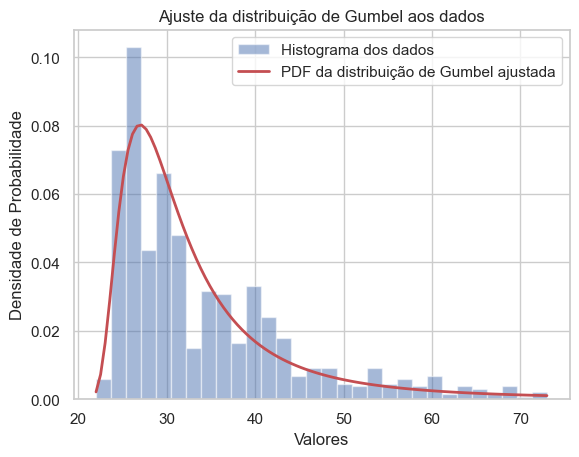

In [158]:
import numpy as np
from scipy.stats import genextreme
import matplotlib.pyplot as plt

# Gerando dados de uma distribuição de Gumbel
np.random.seed(0)
#data = np.random.gumbel(loc=0, scale=1, size=1000)
data = df_2_eda_ajustada['IDADE'].dropna()

statistic, critical_values, significance_level = stats.anderson(data, dist='gumbel_r')
print("\nTeste de Anderson-Darling:")
print("Estatística de teste para a amostra:", statistic)
print("Valores críticos para a amostra:", critical_values)
print("Níveis de significância para a amostra:", significance_level)
if statistic > critical_values[2]:
    print("Os dados NÃO seguem a distribuição de Gumbel (rejeita H0)")
else:
    print("Os dados seguem a distribuição de Gumbel (não rejeita H0)")
print("\n")

# Ajustando a distribuição de Gumbel aos dados
params = genextreme.fit(data)
loc_estimado, scale_estimado = params[0], params[1]

print("Parâmetro de localização estimado:", loc_estimado)
print("Parâmetro de escala estimado:", scale_estimado)

plt.hist(data, bins=30, density=True, alpha=0.5, color='b', label='Histograma dos dados')
x = np.linspace(min(data), max(data), 100)
pdf = genextreme.pdf(x, *params)
plt.plot(x, pdf, 'r', linewidth=2, label='PDF da distribuição de Gumbel ajustada')

plt.xlabel('Valores')
plt.ylabel('Densidade de Probabilidade')
plt.title('Ajuste da distribuição de Gumbel aos dados')
plt.legend()
plt.show()

In [151]:
from scipy.optimize import minimize
from scipy.stats import poisson
def poisson_likelihood(params, data):
    #print(params)
    lambda_ = params
    return -np.sum(poisson.logpmf(data, lambda_))

In [159]:
data = df_2_eda_ajustada['IDADE'].values #.query(f'IDADE > {num}')['IDADE'].values
result = minimize(
    poisson_likelihood,     # Função de verossimilhança
    x0=1,                   # Valor inicial para lambda
    args=(data,),           # Argumentos adicionais (dados)
    #method='L-BFGS-B'       # Método de otimização
    method='BFGS'
    )      

[22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45
 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69
 70 71 72 73]
Lambda 1 34.240102171136655 / Lambda 2 34.24010252154537


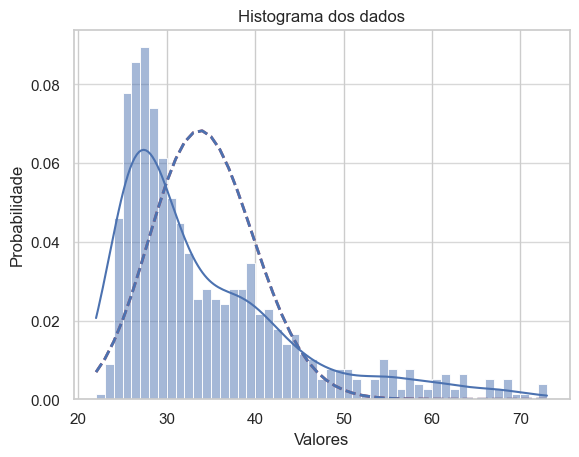

In [163]:
import matplotlib.pyplot as plt
from scipy.stats import poisson

#num = 30
#data = df_2_eda_ajustada.query(f'IDADE > {num}')['IDADE'].values
data = df_2_eda_ajustada['IDADE'].dropna().values

result = minimize(poisson_likelihood, x0=1, args=(data,),method='BFGS')      

lambda_mle = result.x[0]     # Valor estimado de lambda
lambda_1 = np.mean(data)
lambda_2 = lambda_mle
##valores_abscissa = np.arange(num, np.max(data) + 1)

valores_abscissa = np.arange(np.min(data), np.max(data) + 1)
print(valores_abscissa)
print(f'Lambda 1 {lambda_1} / Lambda 2 {lambda_2}')

# Calculando a probabilidade da distribuição de Poisson para os valores
probabilidade_poisson_1 = poisson.pmf(valores_abscissa, lambda_1)
probabilidade_poisson_2 = poisson.pmf(valores_abscissa, lambda_2)

#print(lambda_2)
#print(probabilidade_poisson_1)

plt.plot(valores_abscissa, probabilidade_poisson_1, 'r--', linewidth=2, label='Distribuição de Poisson')
plt.plot(valores_abscissa, probabilidade_poisson_2, 'b--', linewidth=2, label='Distribuição de Poisson')
sns.histplot(data, binwidth=1, kde=True, alpha=0.5, stat='probability', label='Dados Numéricos')

plt.xlabel('Valores')
plt.ylabel('Probabilidade')
plt.title('Histograma dos dados')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [164]:
colunas_analisadas = ['RENDA_M_INDIVIDUAL']

for coluna in colunas_analisadas:
    print(f"Analisando a coluna: {coluna}")
    if coluna in df_2_eda_ajustada.columns:
        # Descobrir as categorias únicas para esta coluna
        categorias = df_2_eda_ajustada['CATEGORIA_GENERO'].unique()
        # Iterar sobre cada categoria
        for categoria in categorias:
            valores_categoria = df_2_eda_ajustada.loc[df_2_eda_ajustada['CATEGORIA_GENERO'] == categoria, coluna].dropna()
            #valores_categoria = df_2_eda_ajustada[df_2_eda_ajustada[coluna] == categoria][coluna]
            intervalo_confianca = .99
            print(f"Categoria: {categoria}")
            print(f"Média: {valores_categoria.mean()}")
            print(f"Lista de números: {valores_categoria.tolist()}")
            tset,pval = ttest_1samp(valores_categoria.tolist(), valores_categoria.mean())
            print("P-value = {}".format(pval))
            if pval <(1 - intervalo_confianca):
                print("We are rejecting the null Hypothesis.")
            else:
                print("We are accepting the null hypothesis.")
    print()

Analisando a coluna: RENDA_M_INDIVIDUAL
Categoria: M
Média: 3.235820895522388
Lista de números: [4.0, 3.0, 2.0, 2.0, 4.0, 5.0, 3.0, 4.0, 3.0, 2.0, 3.0, 2.0, 4.0, 2.0, 4.0, 3.0, 6.0, 2.0, 3.0, 3.0, 4.0, 2.0, 7.0, 3.0, 6.0, 5.0, 3.0, 5.0, 4.0, 4.0, 3.0, 5.0, 4.0, 4.0, 6.0, 3.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 1.0, 3.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 5.0, 3.0, 4.0, 3.0, 3.0, 1.0, 5.0, 4.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 2.0, 3.0, 4.0, 3.0, 3.0, 2.0, 1.0, 4.0, 4.0, 4.0, 4.0, 2.0, 3.0, 1.0, 4.0, 4.0, 3.0, 4.0, 4.0, 1.0, 3.0, 3.0, 2.0, 3.0, 1.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 3.0, 4.0, 4.0, 3.0, 4.0, 2.0, 4.0, 3.0, 3.0, 4.0, 3.0, 2.0, 3.0, 2.0, 2.0, 2.0, 3.0, 4.0, 4.0, 3.0, 3.0, 3.0, 4.0, 3.0, 4.0, 2.0, 4.0, 4.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 4.0, 2.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 2.0, 2.0, 4.0, 3.0, 4.0, 3.0, 4.0, 4.0, 3.0, 1.0, 3.0, 2.0, 3.0, 1.0, 2.0, 2.0, 3.0, 2.0, 5.0, 3.0, 3.0, 1.0, 7.0, 3.0, 1.0, 4.0, 3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0

NameError: name 'ttest_1samp' is not defined

In [ ]:
colunas_analisadas = list(dic.keys())

for coluna in colunas_analisadas:
    amostra1 = df_2_eda_ajustada.loc[df_2_eda_ajustada['CATEGORIA_GENERO'] == 'H', coluna].dropna()
    amostra2 = df_2_eda_ajustada.loc[df_2_eda_ajustada['CATEGORIA_GENERO'] == 'M', coluna].dropna()
    amostra3 = df_2_eda_ajustada.loc[df_2_eda_ajustada['CATEGORIA_GENERO'] == 'INDEF', coluna].dropna()

    print(f">>> Avaliando campo {coluna}\n")

    alfa = 0.05

    print('A hipótese nula da ANOVA (Análise de Variância) afirma que não há diferença significativa entre as médias das populações das quais as amostras foram retiradas.')
    print('Em outras palavras, todas as amostras vêm de populações com a mesma média.\n')

    statistic, p_value = f_oneway(amostra1, amostra2, amostra3)
    p_value_formatted = "{:.5f}".format(p_value)
    print(f">>> Resultados ANOVA paras TODAS as amostras {coluna}:")
    print(f"Estatística do teste ANOVA: {statistic} obtendo valor p {p_value_formatted} em nível de significância de {1 - alfa}")

    if p_value < alfa:
        print(">>> Rejeitar a hipótese nula: As amostras vem de populações com médios distintas, já que há diferenças significativas entre as médias.\n")
    else:
        print(">>> Não há evidências suficientes para rejeitar a hipótese nula: Todas as amostras vêm de populações com a mesma média.\n")

    statistic, p_value = stats.kstest(amostra1, amostra2)
    p_value_formatted = "{:.5f}".format(p_value)
    print(f">>> Resultados KS paras amostras 1 e 2 do campo {coluna}:")
    print(f"Estatística do teste KS: {statistic} obtendo valor p {p_value_formatted} em nível de significância de {1 - alfa}")
    if p_value < 0.05:
        print(">>> A hipótese nula foi rejeitada: As duas amostras vêm de distribuições diferentes.\n")
        #print("A amostra não parece ser proveniente de uma distribuição normal.\n")
    else:
            print(">>> A hipótese nula foi rejeitada: As amostras vêm de uma mesma distribuição.\n")

>>> Avaliando campo IDADE

A hipótese nula da ANOVA (Análise de Variância) afirma que não há diferença significativa entre as médias das populações das quais as amostras foram retiradas.
Em outras palavras, todas as amostras vêm de populações com a mesma média.

>>> Resultados ANOVA paras TODAS as amostras IDADE:
Estatística do teste ANOVA: 7.683957353315908 obtendo valor p 0.00052 em nível de significância de 0.95
>>> Rejeitar a hipótese nula: As amostras vem de populações com médios distintas, já que há diferenças significativas entre as médias.

>>> Resultados KS paras amostras 1 e 2 do campo IDADE:
Estatística do teste KS: 0.06457508376484922 obtendo valor p 0.84117 em nível de significância de 0.95
>>> A hipótese nula foi rejeitada: As amostras vêm de uma mesma distribuição.

>>> Avaliando campo RENDA_M_INDIVIDUAL

A hipótese nula da ANOVA (Análise de Variância) afirma que não há diferença significativa entre as médias das populações das quais as amostras foram retiradas.
Em outra

### 2.3.2 Análise de Categorias de Pessoa Jurídica

In [ ]:
df_2_eda_ajustada.groupby('CATEGORIA_PJ').agg(dic)

IDADE  RENDA_M_INDIVIDUAL  HH_EM_AU  \
CATEGORIA_PJ                                        
MISTA          33.5            3.718750  4.580645   
NAO            29.0            3.167224  4.201681   
UNI            35.0            4.095238  4.571429   

              INDICE_SATISFACAO_PROFISSIONAL  INDICE_FORMACAO_ACADEMICA  
CATEGORIA_PJ                                                             
MISTA                              12.531250                   9.125000  
NAO                                12.456376                   9.297659  
UNI                                12.904762                   9.666667

In [ ]:
df_2_eda_ajustada[list(dic.keys())].describe().transpose()

count       mean        std   min   25%   50%  \
IDADE                           783.0  34.240102  10.143400  22.0  27.0  31.0   
RENDA_M_INDIVIDUAL              717.0   3.468619   1.374419   1.0   3.0   3.0   
HH_EM_AU                        549.0   4.120219   0.966657   2.0   4.0   4.0   
INDICE_SATISFACAO_PROFISSIONAL  665.0  12.378947   3.317648   3.0  10.0  13.0   
INDICE_FORMACAO_ACADEMICA       715.0   9.276923   4.391099   1.0   7.0  10.0   

                                 75%   max  
IDADE                           39.0  73.0  
RENDA_M_INDIVIDUAL               4.0   8.0  
HH_EM_AU                         5.0   5.0  
INDICE_SATISFACAO_PROFISSIONAL  15.0  20.0  
INDICE_FORMACAO_ACADEMICA       12.0  23.0

In [ ]:
colunas_analisadas = list(dic.keys())

for coluna in colunas_analisadas:
    amostra1 = df_2_eda_ajustada.loc[df_2_eda_ajustada['CATEGORIA_PJ'] == 'NAO', coluna].dropna()
    amostra2 = df_2_eda_ajustada.loc[df_2_eda_ajustada['CATEGORIA_PJ'] == 'UNI', coluna].dropna()
    amostra3 = df_2_eda_ajustada.loc[df_2_eda_ajustada['CATEGORIA_PJ'] == 'MISTA', coluna].dropna()

    print(f">>> Avaliando campo {coluna}\n")

    alfa = 0.05

    print('A hipótese nula da ANOVA (Análise de Variância) afirma que não há diferença significativa entre as médias das populações das quais as amostras foram retiradas.')
    print('Em outras palavras, todas as amostras vêm de populações com a mesma média.\n')

    statistic, p_value = f_oneway(amostra1, amostra2, amostra3)
    p_value_formatted = "{:.5f}".format(p_value)
    print(f">>> Resultados ANOVA paras TODAS as amostras {coluna}:")
    print(f"Estatística do teste ANOVA: {statistic} obtendo valor p {p_value_formatted} em nível de significância de {1 - alfa}")

    if p_value < alfa:
        print(">>> Rejeitar a hipótese nula: As amostras vem de populações com médios distintas, já que há diferenças significativas entre as médias.\n")
    else:
        print(">>> Não há evidências suficientes para rejeitar a hipótese nula: Todas as amostras vêm de populações com a mesma média.\n")

    statistic, p_value = stats.kstest(amostra1, amostra2)
    p_value_formatted = "{:.5f}".format(p_value)
    print(f">>> Resultados KS paras amostras 1 e 2 do campo {coluna}:")
    print(f"Estatística do teste KS: {statistic} obtendo valor p {p_value_formatted} em nível de significância de {1 - alfa}")
    if p_value < 0.05:
        print(">>> A hipótese nula foi rejeitada: As duas amostras vêm de distribuições diferentes.\n")
        #print("A amostra não parece ser proveniente de uma distribuição normal.\n")
    else:
            print(">>> A hipótese nula foi rejeitada: As amostras vêm de uma mesma distribuição.\n")

>>> Avaliando campo IDADE

A hipótese nula da ANOVA (Análise de Variância) afirma que não há diferença significativa entre as médias das populações das quais as amostras foram retiradas.
Em outras palavras, todas as amostras vêm de populações com a mesma média.

>>> Resultados ANOVA paras TODAS as amostras IDADE:
Estatística do teste ANOVA: 7.126277370244042 obtendo valor p 0.00087 em nível de significância de 0.95
>>> Rejeitar a hipótese nula: As amostras vem de populações com médios distintas, já que há diferenças significativas entre as médias.

>>> Resultados KS paras amostras 1 e 2 do campo IDADE:
Estatística do teste KS: 0.2546506049784127 obtendo valor p 0.00038 em nível de significância de 0.95
>>> A hipótese nula foi rejeitada: As duas amostras vêm de distribuições diferentes.

>>> Avaliando campo RENDA_M_INDIVIDUAL

A hipótese nula da ANOVA (Análise de Variância) afirma que não há diferença significativa entre as médias das populações das quais as amostras foram retiradas.
Em

In [ ]:
from scipy.stats import f_oneway
import numpy as np

coluna_analise = 'FONTE_RENDA_AU'
amostra1 = df_2_eda_ajustada.loc[df_2_eda_ajustada['CATEGORIA_PJ'] == 'NAO', coluna_analise].dropna()
amostra2 = df_2_eda_ajustada.loc[df_2_eda_ajustada['CATEGORIA_PJ'] == 'MISTA', coluna_analise].dropna()
amostra3 = df_2_eda_ajustada.loc[df_2_eda_ajustada['CATEGORIA_PJ'] == 'UNI', coluna_analise].dropna()

alpha = 0.05

# Execute o teste de ANOVA
statistic, p_value = f_oneway(amostra1, amostra2, amostra3)

print('A hipótese nula da ANOVA (Análise de Variância) afirma que não há diferença significativa entre as médias das populações das quais as amostras foram retiradas.')
print('Em outras palavras, todas as amostras vêm de populações com a mesma média.\n')

# Exiba os resultados
print("Estatística do teste de ANOVA:", statistic)
print("Valor p:", p_value)

# Determine se há diferenças significativas entre as médias das amostras
alpha = 0.05  # Nível de significância
if p_value < alpha:
    print(">>> Resultado: Rejeitar a hipótese nula, já que há diferenças significativas entre as médias das amostras.")
else:
    print(">>> Resultado: Não há evidências suficientes para rejeitar a hipótese nula")

print("\n")
print('A hipótese nula do teste t de Student afirma que não há diferença significativa entre as médias das duas amostras comparadas.')
print('Quando você realiza um teste t de Student para amostras independentes, está testando se a média das duas populações das quais as amostras foram retiradas é estatisticamente a mesma.\n')

print(">>> Resultados do teste de t-Student para AMOSTRA 1 e AMOSTRA 2:")
statistic, p_value = stats.ttest_ind(amostra1, amostra2)
print("Estatística do teste t:", statistic)
print("Valor p:", p_value)
if p_value < alpha: print(">>> Resultado: Rejeitar a hipótese nula, pois há diferença estatisticamente significativa")
else: print(">>> Resultado: Não há evidências suficientes para rejeitar a hipótese nula")

print("\n")
print(">>> Resultados do teste de t-Student para AMOSTRA 2 e AMOSTRA 3:")
statistic, p_value = stats.ttest_ind(amostra2, amostra3)
print("Estatística do teste t:", statistic)
print("Valor p:", p_value)
if p_value < alpha: print(">>> Resultado: Rejeitar a hipótese nula, pois há diferença estatisticamente significativa")
else: print(">>> Resultado: Não há evidências suficientes para rejeitar a hipótese nula")

A hipótese nula da ANOVA (Análise de Variância) afirma que não há diferença significativa entre as médias das populações das quais as amostras foram retiradas.
Em outras palavras, todas as amostras vêm de populações com a mesma média.

Estatística do teste de ANOVA: 7.763933253542695
Valor p: 0.0004788264282026161
>>> Resultado: Rejeitar a hipótese nula, já que há diferenças significativas entre as médias das amostras.


A hipótese nula do teste t de Student afirma que não há diferença significativa entre as médias das duas amostras comparadas.
Quando você realiza um teste t de Student para amostras independentes, está testando se a média das duas populações das quais as amostras foram retiradas é estatisticamente a mesma.

>>> Resultados do teste de t-Student para AMOSTRA 1 e AMOSTRA 2:
Estatística do teste t: -2.9317032022102163
Valor p: 0.003550151865619688
>>> Resultado: Rejeitar a hipótese nula, pois há diferença estatisticamente significativa


>>> Resultados do teste de t-Studen

In [ ]:
colunas_analisadas = ['IDADE', 'RENDA_M_INDIVIDUAL','HH_EM_AU','INDICE_SATISFACAO_PROFISSIONAL','INDICE_FORMACAO_ACADEMICA']

for coluna in colunas_analisadas:
    amostra1 = df_2_eda_ajustada.loc[df_2_eda_ajustada['CATEGORIA_PJ'] == 'NAO', coluna_analise].dropna()
    amostra2 = df_2_eda_ajustada.loc[df_2_eda_ajustada['CATEGORIA_PJ'] == 'MISTA', coluna_analise].dropna()
    amostra3 = df_2_eda_ajustada.loc[df_2_eda_ajustada['CATEGORIA_PJ'] == 'UNI', coluna_analise].dropna()

    statistic, p_value = f_oneway(amostra1, amostra2, amostra3)

    print('A hipótese nula da ANOVA (Análise de Variância) afirma que não há diferença significativa entre as médias das populações das quais as amostras foram retiradas.')
    print('Em outras palavras, todas as amostras vêm de populações com a mesma média.\n')

    p_value_formatted = "{:.5f}".format(p_value)
    print(f">>> Resultados ANOVA para {coluna} entre todas as amostras:")
    print(f"Estatística do teste ANOVA: {statistic} obtendo valor p {p_value_formatted} em nível de significância de {1 - 0.05}")

    alpha = 0.05  # Nível de significância
    if p_value < alpha:
        print(">>> Resultado: Rejeitar a hipótese nula. Há diferenças significativas entre as médias das amostras.\n")
    else:
        print(">>> Resultado: Não há evidências suficientes para rejeitar a hipótese nula. Todas as amostras vêm de populações com a mesma média.\n")


    testes(coluna, 0.05, amostra1)
    testes(coluna, 0.05, amostra2)
    testes(coluna, 0.05, amostra3)

A hipótese nula da ANOVA (Análise de Variância) afirma que não há diferença significativa entre as médias das populações das quais as amostras foram retiradas.
Em outras palavras, todas as amostras vêm de populações com a mesma média.

>>> Resultados ANOVA para IDADE entre todas as amostras:
Estatística do teste ANOVA: 7.763933253542695 obtendo valor p 0.00048 em nível de significância de 0.95
>>> Resultado: Rejeitar a hipótese nula. Há diferenças significativas entre as médias das amostras.

>>> Resultados do teste de Kolmogorov-Smirnov para AMOSTRA 1 avaliando IDADE:
Estatística do teste Kolmogorov-Smirnov: 0.8413447460685429 obtendo valor p 0.00000 em nível de significância de 0.95
A hipótese nula foi rejeitada.
>>> Resultados do teste de Shapiro-Wilk para AMOSTRA 1 avaliando IDADE:
Estatística do teste Shapiro-Wilk: 0.3260236382484436 obtendo valor p 0.00000 em nível de significância de 0.95
A hipótese nula foi rejeitada.
É possível afirmar que AMOSTRA 1 segue uma distribuiçao norm

### 2.3.3 Análise de Escolaridade

In [130]:
df_2_eda_ajustada.groupby('ESCOLARIDADE').agg(dic)

IDADE  RENDA_M_INDIVIDUAL  HH_EM_AU  \
ESCOLARIDADE                                        
1              29.0            3.116550  4.122924   
2              33.0            3.714286  4.075829   
3              37.0            4.472222  4.272727   
4              60.5            5.666667  5.000000   
5              33.0                 NaN       NaN   

              INDICE_SATISFACAO_PROFISSIONAL  INDICE_FORMACAO_ACADEMICA  
ESCOLARIDADE                                                             
1                                  12.330709                   8.296729  
2                                  12.377049                  10.020325  
3                                  12.888889                  14.611111  
4                                  12.500000                  20.250000  
5                                        NaN                  10.000000

In [ ]:
df_2_eda_ajustada[list(dic.keys())].describe().transpose()

count       mean        std   min   25%   50%  \
IDADE                           783.0  34.240102  10.143400  22.0  27.0  31.0   
RENDA_M_INDIVIDUAL              706.0   3.398017   1.262193   1.0   3.0   3.0   
HH_EM_AU                        549.0   4.120219   0.966657   2.0   4.0   4.0   
INDICE_SATISFACAO_PROFISSIONAL  665.0  12.378947   3.317648   3.0  10.0  13.0   
INDICE_FORMACAO_ACADEMICA       715.0   9.276923   4.391099   1.0   7.0  10.0   

                                 75%   max  
IDADE                           39.0  73.0  
RENDA_M_INDIVIDUAL               4.0   7.0  
HH_EM_AU                         5.0   5.0  
INDICE_SATISFACAO_PROFISSIONAL  15.0  20.0  
INDICE_FORMACAO_ACADEMICA       12.0  23.0

### 2.3.4 Análise por Categoria de Idade

In [ ]:
df_2_eda_ajustada.groupby('CATEGORIA_IDADE').agg(dic)

IDADE  RENDA_M_INDIVIDUAL  HH_EM_AU  \
CATEGORIA_IDADE                                        
(15, 30]          27.0            2.837466  4.039855   
(30, 40]          35.0            3.771845  4.153374   
(40, 50]          44.0            4.195122  4.203125   
(50, 60]          55.0            4.060606  4.185185   
(60, 75]          66.0            5.181818  4.631579   

                 INDICE_SATISFACAO_PROFISSIONAL  INDICE_FORMACAO_ACADEMICA  
CATEGORIA_IDADE                                                             
(15, 30]                              12.388235                   9.119777  
(30, 40]                              12.154639                   9.896226  
(40, 50]                              12.653333                   8.494118  
(50, 60]                              12.757576                   9.558824  
(60, 75]                              12.695652                   8.560000

In [ ]:
df_2_eda_ajustada[list(dic.keys())].describe().transpose()

count       mean        std   min   25%   50%  \
IDADE                           783.0  34.240102  10.143400  22.0  27.0  31.0   
RENDA_M_INDIVIDUAL              706.0   3.398017   1.262193   1.0   3.0   3.0   
HH_EM_AU                        549.0   4.120219   0.966657   2.0   4.0   4.0   
INDICE_SATISFACAO_PROFISSIONAL  665.0  12.378947   3.317648   3.0  10.0  13.0   
INDICE_FORMACAO_ACADEMICA       715.0   9.276923   4.391099   1.0   7.0  10.0   

                                 75%   max  
IDADE                           39.0  73.0  
RENDA_M_INDIVIDUAL               4.0   7.0  
HH_EM_AU                         5.0   5.0  
INDICE_SATISFACAO_PROFISSIONAL  15.0  20.0  
INDICE_FORMACAO_ACADEMICA       12.0  23.0

## 2.4 Histogramas

In [131]:
figsize_hist = (10,5)
figsize_histbox = (8,5)

In [132]:
dict_ticks = {}

# Adicionando itens ao dicionário
dict_ticks['FONTE_RENDA_AU'] = ([0, 1, 2, 3, 4, 5, 6], ['<= 1 SM', '1-3 SM', '3-6 SM', '6-9 SM', '9-12 SM', '12-15 SM', '> 15 SM'])
dict_ticks['RENDA_M_INDIVIDUAL'] = ([0, 1, 2, 3, 4, 5, 6], ['<= 1 SM', '1-3 SM', '3-6 SM', '6-9 SM', '9-12 SM', '12-15 SM', '> 15 SM'])
dict_ticks['HH_EM_AU'] = ([0, 1, 2, 3, 4, 5], ['Esporadicamente', 'até 10h', '10-20h', '20-30h', '30-40h', '> 40h'])



### 2.4.1 Histogramas por Categoria de Gênero

In [202]:
crit="CATEGORIA_GENERO"
cor="light:m"
#crit="CATEGORIA_IDADE"
#cor="flare"
#crit="CATEGORIA_PJ"
#cor='viridis'
#crit="ESCOLARIDADE"
#cor="tab10"


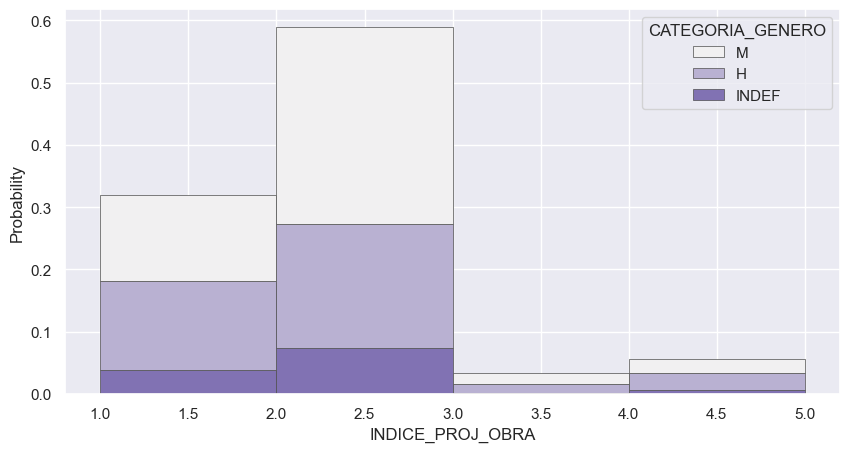

In [203]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
sns.histplot(
    data=df_2_eda_ajustada,
    x="INDICE_PROJ_OBRA", hue=crit,
    #x="IDADE", hue="CATEGORIA_PJ",
    #x="IDADE", hue="REGIAO",
    multiple="stack",
    #multiple="fill",
    palette=cor,
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    #bins=20,
    binrange=(1,5), alpha=1,
    binwidth=1
)

arquivo = f'INDICE_PROJ_OBRA_{crit.upper()}_HIST.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

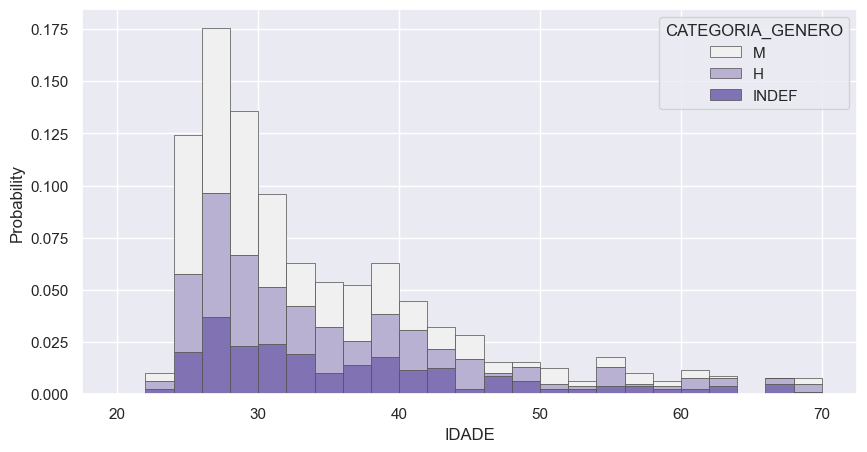

In [204]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
sns.histplot(
    data=df_2_eda_ajustada,
    x="IDADE", hue=crit,
    #x="IDADE", hue="CATEGORIA_PJ",
    #x="IDADE", hue="REGIAO",
    multiple="stack",
    #multiple="fill",
    palette=cor,
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=20,
    binrange=(20,70), alpha=1, binwidth=2
)

arquivo = f'IDADE_{crit.upper()}_HIST.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

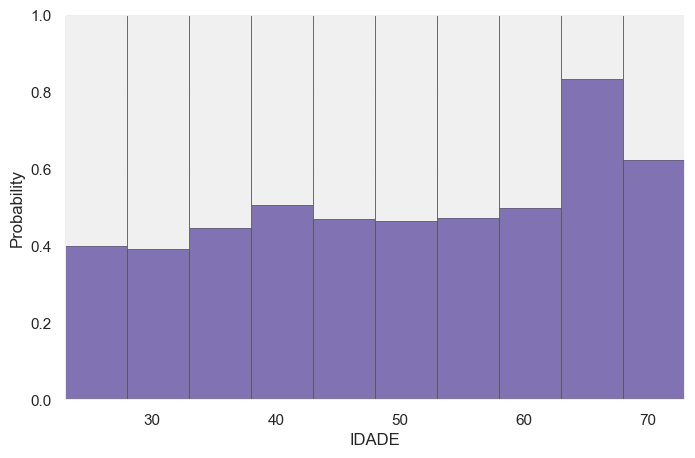

In [207]:
plt.figure(figsize=figsize_histbox)
#plt.xticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1])
sns.histplot(
    data=df_2_eda_ajustada.query('CATEGORIA_GENERO != "INDEF"'),
    #x="RENDA_POR_HH_TOTAL", hue="CATEGORIA_GENERO",
    x="IDADE", hue=crit,
    #x="RENDA_POR_HH_TOTAL", hue="REGIAO",
    #multiple="stack",
    multiple="fill",
    palette=cor,
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    legend=False,
    #bins=5,
    binwidth=5,
    alpha=1
    #binrange=(0,6), alpha=1, binwidth=1
)

arquivo = f'IDADE_{crit.upper()}_HIST_FILL.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

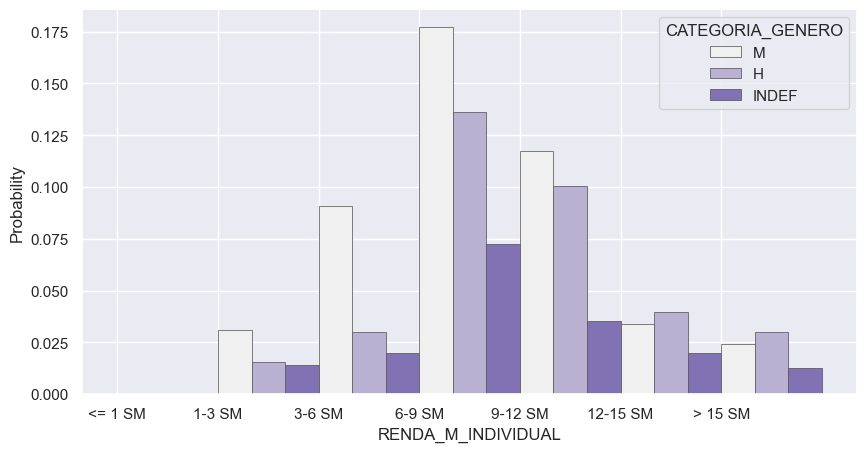

In [470]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
plt.xticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=0)

sns.histplot(
    data=df_2_eda_ajustada,
    #x="RENDA_POR_HH_TOTAL", hue="CATEGORIA_GENERO",
    x="RENDA_M_INDIVIDUAL", hue=crit,
    #x="RENDA_POR_HH_TOTAL", hue="REGIAO",
    #multiple="stack",
    multiple="dodge",
    palette=cor,
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    #bins=5,
    binrange=(0,len(dict_ticks['RENDA_M_INDIVIDUAL'][1])), alpha=1, binwidth=1
)

arquivo = f'RENDA_M_INDIVIDUAL_{crit.upper()}HIST.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

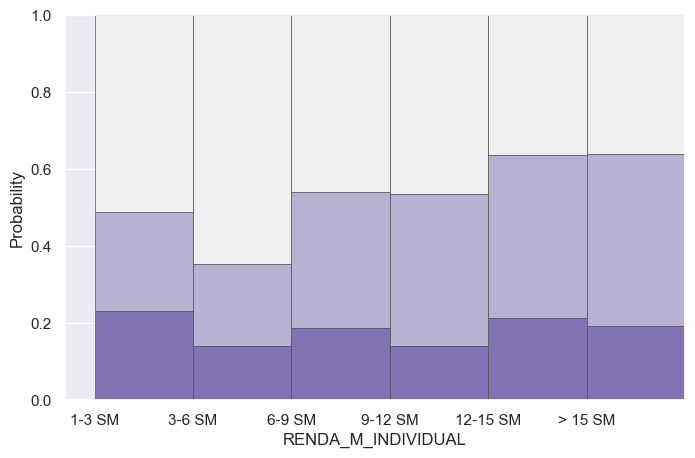

In [471]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_histbox)
plt.xticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1])
sns.histplot(
    data=df_2_eda_ajustada,
    #x="RENDA_POR_HH_TOTAL", hue="CATEGORIA_GENERO",
    x="RENDA_M_INDIVIDUAL", hue=crit,
    #x="RENDA_POR_HH_TOTAL", hue="REGIAO",
    #multiple="stack",
    multiple="fill",
    palette=cor,
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    legend=False,
    #bins=5,
    binrange=(0,len(dict_ticks['RENDA_M_INDIVIDUAL'][1])), alpha=1, binwidth=1
)

arquivo = f'RENDA_M_INDIVIDUAL_{crit.upper()}_HIST_FILL.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

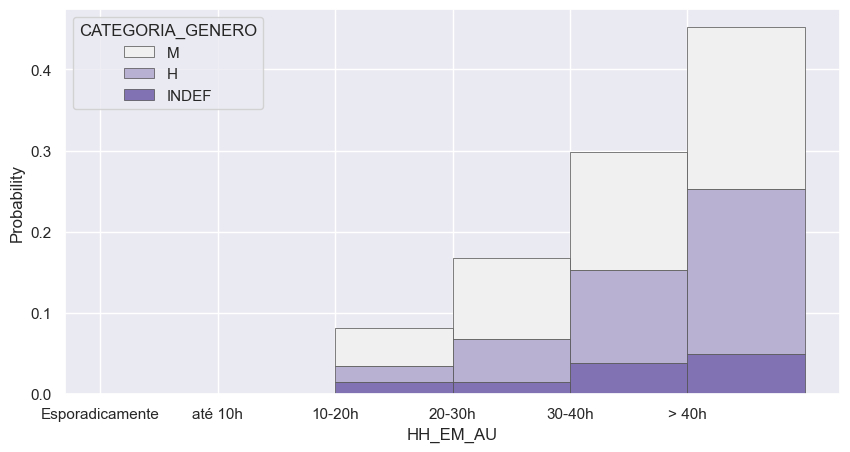

In [478]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
plt.xticks(dict_ticks['HH_EM_AU'][0], dict_ticks['HH_EM_AU'][1], rotation=0)
sns.histplot(
    data=df_2_eda_ajustada,
    x="HH_EM_AU", hue=crit,
    #x="HH_EM_AU", hue="CATEGORIA_PJ",
    #x="HH_EM_AU", hue="REGIAO",
    multiple="stack",
    palette=cor,
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    #bins=10,
    binrange=(0,len(dict_ticks['HH_EM_AU'][1])), alpha=1, binwidth=1
)

arquivo = f'HH_EM_AU_{crit.upper()}_HIST_STACKED.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

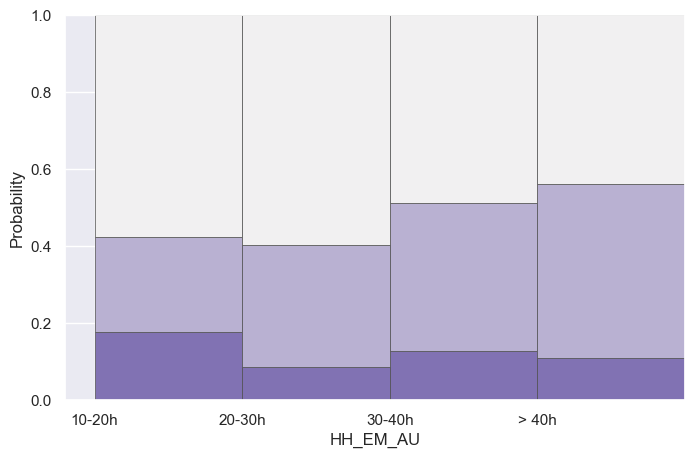

In [473]:
plt.figure(figsize=figsize_histbox)
plt.xticks(dict_ticks['HH_EM_AU'][0], dict_ticks['HH_EM_AU'][1], rotation=0)

sns.histplot(
    data=df_2_eda_ajustada,
    x="HH_EM_AU", hue=crit,
    #x="HH_EM_AU", hue="CATEGORIA_PJ",
    #x="HH_EM_AU", hue="REGIAO",
    multiple="fill",
    palette=cor,
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    legend=False,
    stat='probability',
    bins=3,
    alpha=1,
    binwidth=1,
    binrange=(0,len(dict_ticks['HH_EM_AU'][1])),
    #binrange=(0,6), alpha=1, binwidth=1
)

arquivo = f'HIST_HH_EM_AU_{crit.upper()}_FILL.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

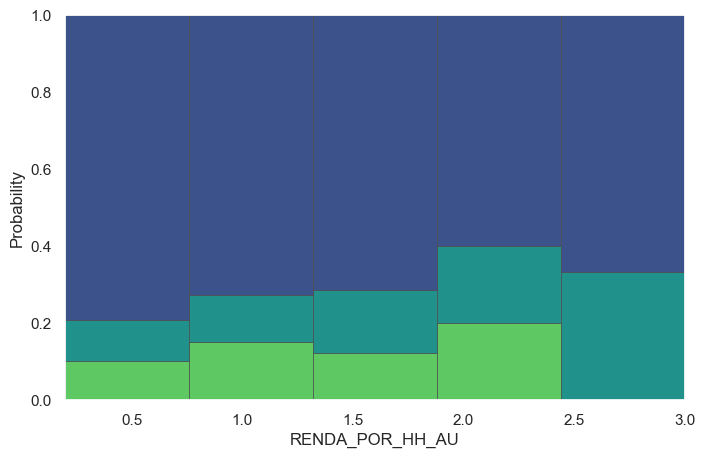

In [36]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_histbox)
#plt.xticks(dict_ticks['HH_EM_AU'][0], dict_ticks['HH_EM_AU'][1], rotation=0)

sns.histplot(
    data=df_2_eda_ajustada,
    x="RENDA_POR_HH_AU", hue=crit,
    #x="HH_EM_AU", hue="CATEGORIA_PJ",
    #x="HH_EM_AU", hue="REGIAO",
    multiple="fill",
    palette=cor,
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    legend=False,
    stat='probability',
    bins=5,
    alpha=1
    #binrange=(0,6), alpha=1, binwidth=1
)

arquivo = f'RENDA_POR_HH_AU_{crit.upper()}_HIST_FILL.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

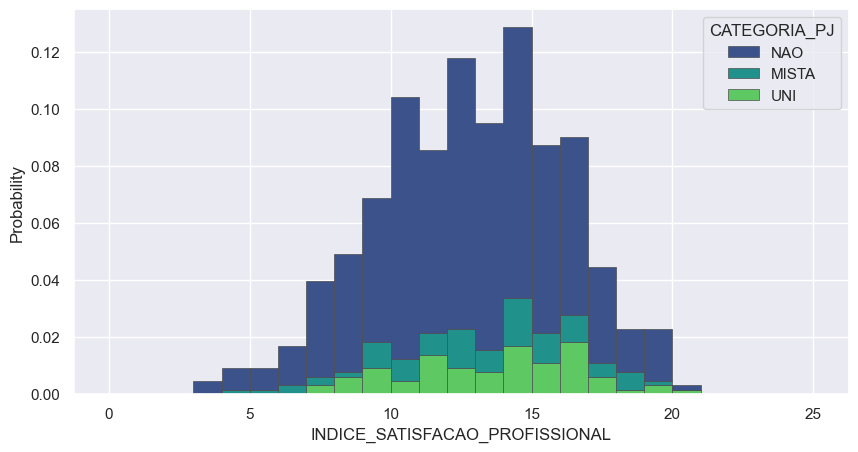

In [34]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
sns.histplot(
    data=df_2_eda_ajustada,
    x="INDICE_SATISFACAO_PROFISSIONAL", hue=crit,
    #x="IDADE", hue="CATEGORIA_PJ",
    #x="IDADE", hue="REGIAO",
    multiple="stack",
    #multiple="fill",
    palette=cor,
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=20,
    binrange=(0,25), alpha=1, binwidth=1,
    #kde=True,
)

arquivo = f'SATISFACAO_PROFISSIONAL_{crit.upper()}_HIST.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

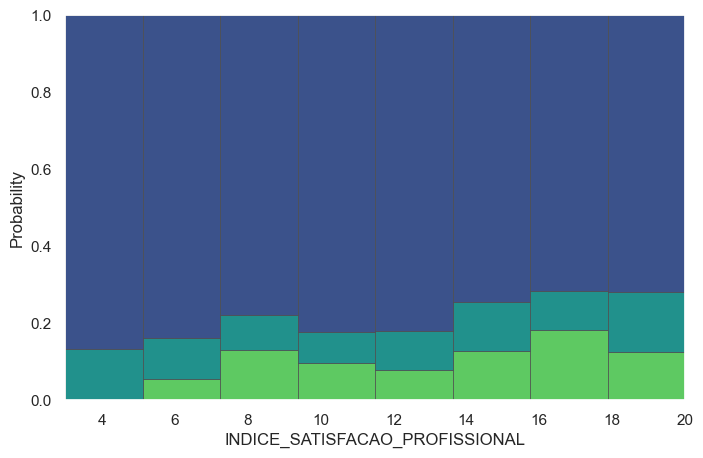

In [35]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_histbox)
#plt.xticks(dict_ticks['HH_EM_AU'][0], dict_ticks['HH_EM_AU'][1], rotation=0)

sns.histplot(
    data=df_2_eda_ajustada,
    x="INDICE_SATISFACAO_PROFISSIONAL", hue=crit,
    #x="HH_EM_AU", hue="CATEGORIA_PJ",
    #x="HH_EM_AU", hue="REGIAO",
    multiple="fill",
    palette=cor,
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    legend=False,
    stat='probability',
    bins=8,
    alpha=1
    #binrange=(0,6), alpha=1, binwidth=1
)

arquivo = f'SATISFACAO_PROFISSIONAL_{crit.upper()}_HIST_FILL.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

### 2.4.2 Histogramas por Categoria de Pessoa Jurídica

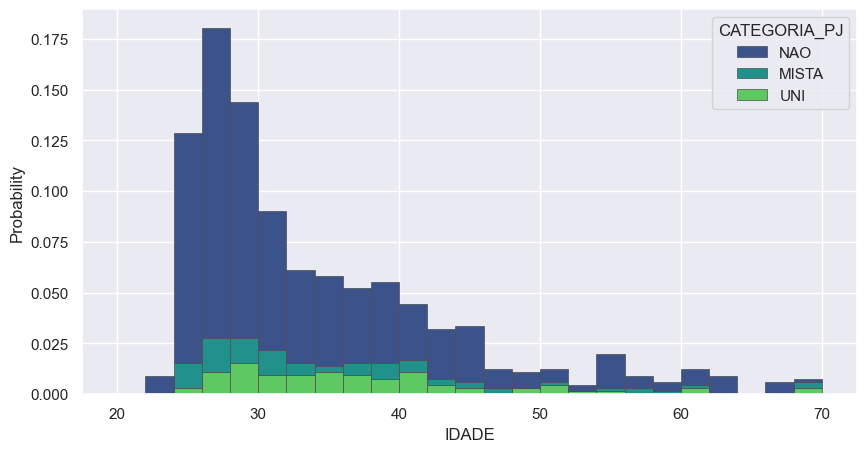

In [477]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
sns.histplot(
    data=df_2_eda_ajustada,
    x="IDADE", hue="CATEGORIA_PJ",
    #x="IDADE", hue="CATEGORIA_PJ",
    #x="IDADE", hue="REGIAO",
    multiple="stack",
    #multiple="fill",
    palette="viridis",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=20,
    binrange=(20,70), alpha=1, binwidth=2
)

arquivo = 'HIST_IDADE_CAT_PJ.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

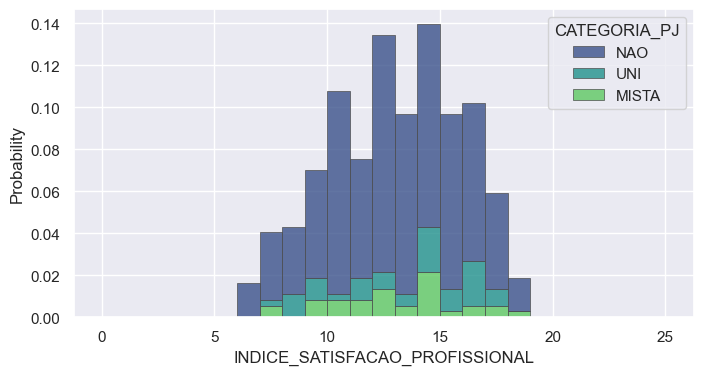

In [46]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
sns.histplot(
    data=df_2_eda_ajustada,
    x="INDICE_SATISFACAO_PROFISSIONAL", hue="CATEGORIA_PJ",
    #x="AVALIACAO_MERCADO_AU", hue="CATEGORIA_IDADE",
    #x="IDADE", hue="CATEGORIA_PJ",
    #x="IDADE", hue="REGIAO",
    multiple="stack",
    #multiple="fill",
    palette="viridis",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=6,
    binrange=(0,25), alpha=.8, binwidth=1
)

arquivo = 'HIST_SATISFACAO_PROFISSIONAL_CAT_PJ.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

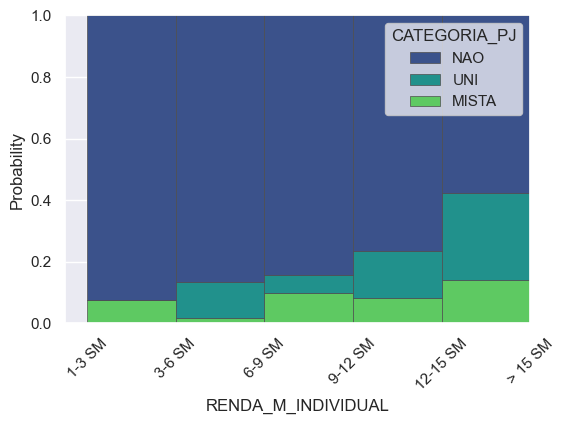

In [47]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_histbox)
plt.xticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=45)
sns.histplot(
    data=df_2_eda_ajustada,
    #x="RENDA_POR_HH_TOTAL", hue="CATEGORIA_GENERO",
    x="RENDA_M_INDIVIDUAL", hue="CATEGORIA_PJ",
    #x="RENDA_POR_HH_TOTAL", hue="REGIAO",
    #multiple="stack",
    multiple="fill",
    palette="viridis",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=6,
    binrange=(0,6), alpha=1, binwidth=1
)

arquivo = 'HISTBOX_RENDA_M_INDIVIDUAL_CAT_PJ.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

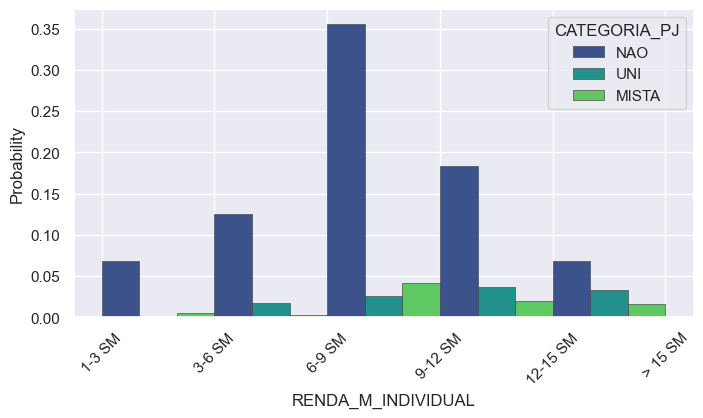

In [48]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
plt.xticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=45)
sns.histplot(
    data=df_2_eda_ajustada,
    #x="RENDA_POR_HH_TOTAL", hue="CATEGORIA_GENERO",
    x="RENDA_M_INDIVIDUAL", hue="CATEGORIA_PJ",
    #x="RENDA_POR_HH_TOTAL", hue="REGIAO",
    #multiple="stack",
    multiple="dodge",
    palette="viridis",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=6,
    binrange=(1,6), alpha=1, binwidth=1
)

arquivo = 'HIST_RENDA_M_INDIVIDUAL_CAT_PJ.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

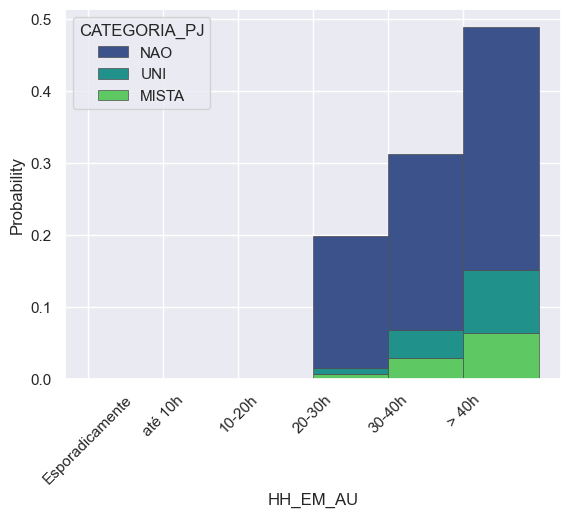

In [51]:
sns.set_theme(style="darkgrid")
plt.xticks(dict_ticks['HH_EM_AU'][0], dict_ticks['HH_EM_AU'][1], rotation=45)
sns.histplot(
    data=df_2_eda_ajustada,
    x="HH_EM_AU", hue="CATEGORIA_PJ",
    #x="HH_EM_AU", hue="CATEGORIA_PJ",
    #x="HH_EM_AU", hue="REGIAO",
    multiple="stack",
    palette="viridis",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=10,
    binrange=(0,6), alpha=1, binwidth=1
)
arquivo = 'HIST_HH_EM_AU_CAT_PJ.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')


<Axes: xlabel='RENDA_M_INDIVIDUAL', ylabel='Probability'>

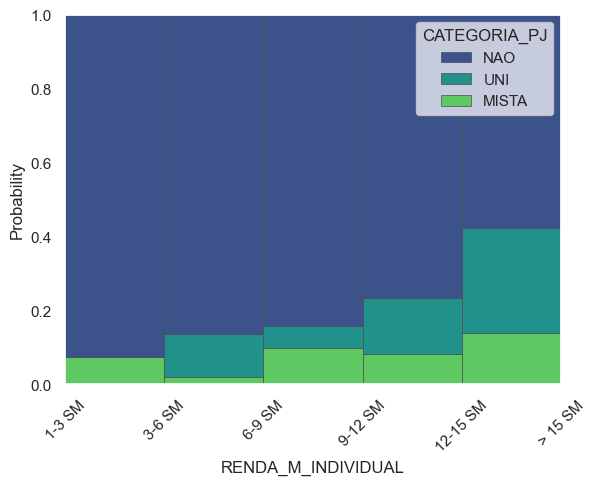

In [50]:
sns.set_theme(style="darkgrid")
plt.xticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=45)
sns.histplot(
    data=df_2_eda_ajustada,
    #x="RENDA_M_INDIVIDUAL", hue="CATEGORIA_GENERO",
    x="RENDA_M_INDIVIDUAL", hue="CATEGORIA_PJ",
    #x="RENDA_M_INDIVIDUAL", hue="REGIAO",
    #multiple="stack",
    multiple='fill',
    palette="viridis",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=10,
    binrange=(1,6), alpha=1, binwidth=1
)

### 2.4.3 Histogramas por Escolaridade

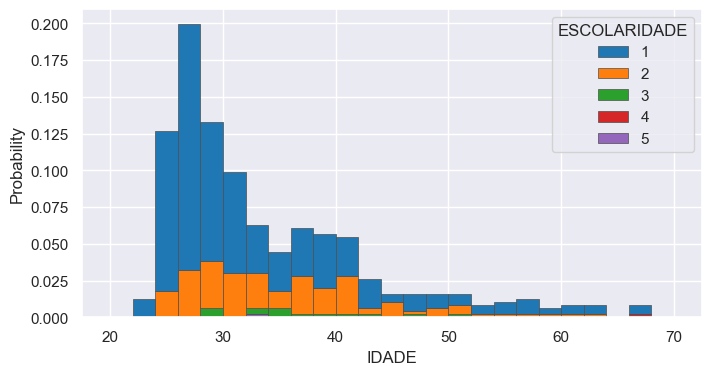

In [58]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
sns.histplot(
    data=df_2_eda_ajustada,
    x="IDADE", hue="ESCOLARIDADE",
    #x="IDADE", hue="CATEGORIA_PJ",
    #x="IDADE", hue="REGIAO",
    multiple="stack",
    #multiple="fill",
    palette="tab10",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=20,
    binrange=(20,70), alpha=1, binwidth=2
)

arquivo = 'HIST_IDADE_ESCOLARIDADE.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

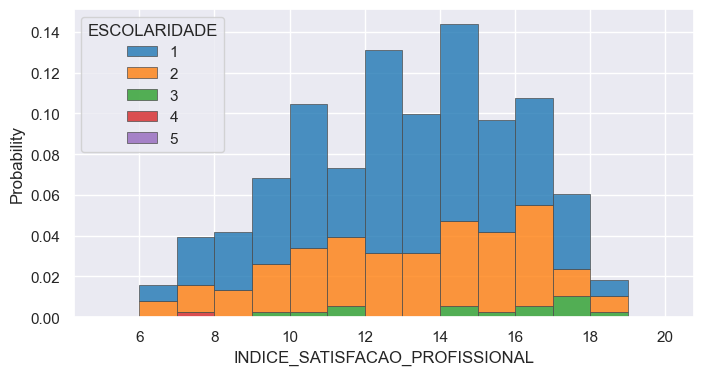

In [52]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
sns.histplot(
    data=df_2_eda_ajustada,
    x="INDICE_SATISFACAO_PROFISSIONAL", hue="ESCOLARIDADE",
    #x="AVALIACAO_MERCADO_AU", hue="CATEGORIA_IDADE",
    #x="IDADE", hue="CATEGORIA_PJ",
    #x="IDADE", hue="REGIAO",
    multiple="stack",
    #kde=True,
    #multiple="fill",
    palette="tab10",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=6,
    binrange=(5,20), alpha=.8, binwidth=1
)

arquivo = 'HIST_SATISFACAO_PROFISSIONAL_ESCOLARIDADE.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

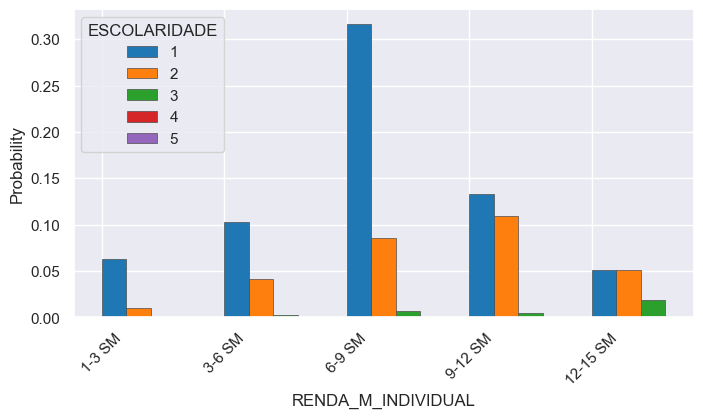

In [53]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
plt.xticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=45)
sns.histplot(
    data=df_2_eda_ajustada,
    #x="RENDA_POR_HH_TOTAL", hue="CATEGORIA_GENERO",
    x="RENDA_M_INDIVIDUAL", hue="ESCOLARIDADE",
    #x="RENDA_POR_HH_TOTAL", hue="REGIAO",
    #multiple="stack",
    multiple="dodge",
    palette='tab10',
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=5,
    binrange=(1,6), alpha=1, binwidth=1
)

arquivo = 'HIST_FONTE_RENDA_AU_ESCOLARIDADE.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

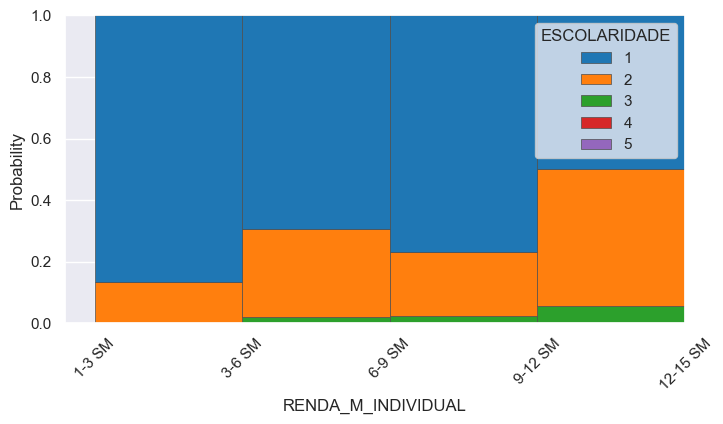

In [54]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
plt.xticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=45)
sns.histplot(
    data=df_2_eda_ajustada,
    #x="RENDA_POR_HH_TOTAL", hue="CATEGORIA_GENERO",
    x="RENDA_M_INDIVIDUAL", hue="ESCOLARIDADE",
    #x="RENDA_POR_HH_TOTAL", hue="REGIAO",
    #multiple="stack",
    multiple="fill",
    palette='tab10',
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=5,
    binrange=(0,5), alpha=1, binwidth=1
)

arquivo = 'HIST_FONTE_RENDA_AU_ESCOLARIDADE_STACK.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

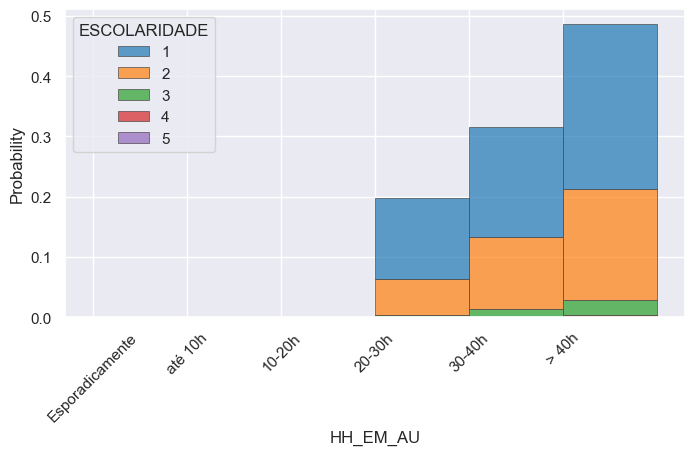

In [67]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
plt.xticks(dict_ticks['HH_EM_AU'][0], dict_ticks['HH_EM_AU'][1], rotation=45)

sns.histplot(
    data=df_2_eda_ajustada,
    x="HH_EM_AU", hue="ESCOLARIDADE",
    #x="HH_EM_AU", hue="CATEGORIA_PJ",
    #x="HH_EM_AU", hue="REGIAO",
    multiple="stack",
    palette="tab10",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=10,
    alpha=.7,
    binrange=(0,6), binwidth=1
)

arquivo = 'HIST_STACKED_HH_EM_AU_ESCOLARIDADE.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

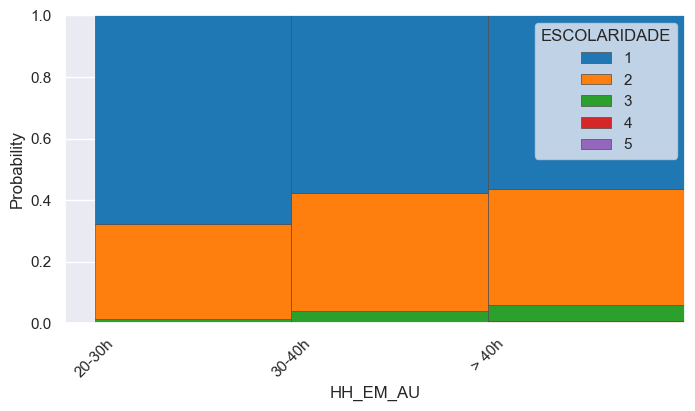

In [56]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
plt.xticks(dict_ticks['HH_EM_AU'][0], dict_ticks['HH_EM_AU'][1], rotation=45)
sns.histplot(
    data=df_2_eda_ajustada,
    x="HH_EM_AU", hue="ESCOLARIDADE",
    #x="HH_EM_AU", hue="CATEGORIA_PJ",
    #x="HH_EM_AU", hue="REGIAO",
    multiple="fill",
    palette="tab10",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=10,
    binrange=(0,6), alpha=1, binwidth=1
)

arquivo = 'STACKEDHIST_FONTE_RENDA_AU_ESCOLARIDADE_FILL.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

### 2.4.4 Histogramas por Categoria de Idade

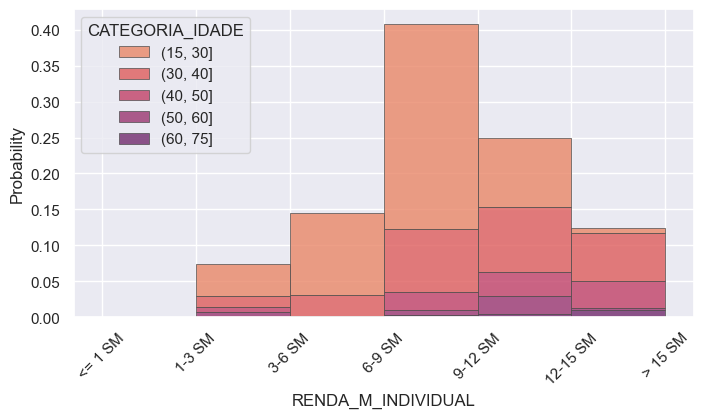

In [68]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
#plt.figure(figsize=figsize_histbox)
plt.xticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=45)
sns.histplot(
    data=df_2_eda_ajustada,
    x="RENDA_M_INDIVIDUAL", hue="CATEGORIA_IDADE",
    #x="AVALIACAO_MERCADO_AU", hue="CATEGORIA_IDADE",
    #x="IDADE", hue="CATEGORIA_PJ",
    #x="IDADE", hue="REGIAO",
    multiple="stack",
    #multiple="fill",
    palette="flare",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=6,
    binrange=(0,6), alpha=.8, binwidth=1
)

arquivo = 'HIST_RENDA_M_INDIVIDUAL_CAT_IDADE.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

<Figure size 800x400 with 0 Axes>

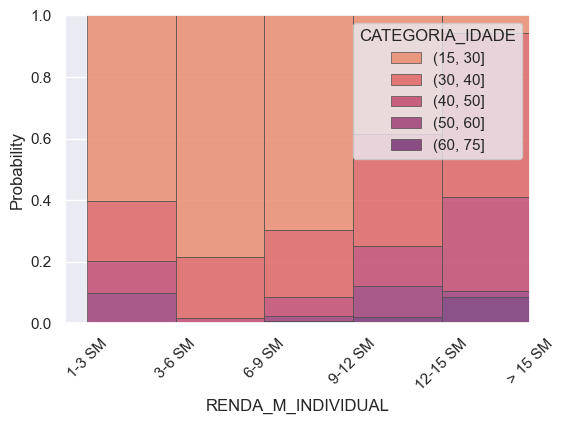

In [69]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
plt.figure(figsize=figsize_histbox)
plt.xticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=45)
sns.histplot(
    data=df_2_eda_ajustada,
    x="RENDA_M_INDIVIDUAL", hue="CATEGORIA_IDADE",
    #x="AVALIACAO_MERCADO_AU", hue="CATEGORIA_IDADE",
    #x="IDADE", hue="CATEGORIA_PJ",
    #x="IDADE", hue="REGIAO",
    multiple="fill",
    palette="flare",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=6,
    binrange=(0,6), alpha=.8, binwidth=1
)

arquivo = 'HIST_RENDA_M_INDIVIDUAL_CAT_IDADE_FILL.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

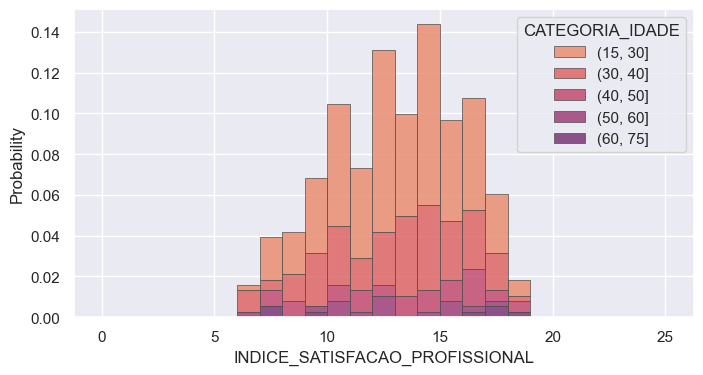

In [70]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=figsize_hist)
sns.histplot(
    data=df_2_eda_ajustada,
    x="INDICE_SATISFACAO_PROFISSIONAL", hue="CATEGORIA_IDADE",
    #x="AVALIACAO_MERCADO_AU", hue="CATEGORIA_IDADE",
    #x="IDADE", hue="CATEGORIA_PJ",
    #x="IDADE", hue="REGIAO",
    multiple="stack",
    #multiple="fill",
    palette="flare",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=6,
    binrange=(0,25), alpha=.8, binwidth=1
)

arquivo = 'HIST_SATISFACAO_PROFISSIONAL_CAT_IDADE.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

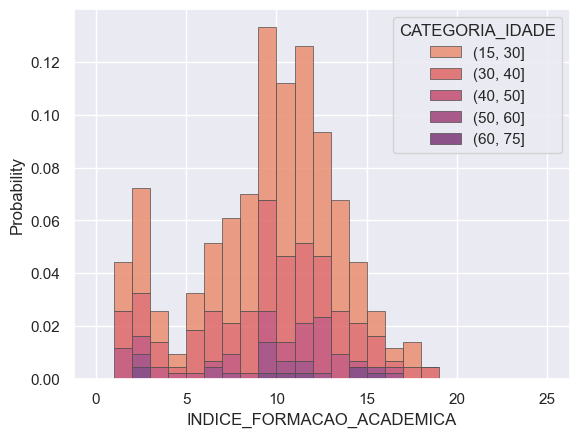

In [71]:
sns.set_theme(style="darkgrid")
sns.histplot(
    data=df_2_eda_ajustada,
    x="INDICE_FORMACAO_ACADEMICA", hue="CATEGORIA_IDADE",
    #x="AVALIACAO_MERCADO_AU", hue="CATEGORIA_IDADE",
    #x="IDADE", hue="CATEGORIA_PJ",
    #x="IDADE", hue="REGIAO",
    multiple="stack",
    #multiple="fill",
    palette="flare",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    stat='probability',
    bins=6,
    binrange=(0,25), alpha=.8, binwidth=1
)
arquivo = 'INDICE_FORMACAO_ACADEMICA_CAT_IDADE_HIST.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

In [245]:
print(df_2_eda_ajustada.groupby('CATEGORIA_IDADE')['INDICE_FORMACAO_ACADEMICA'].agg(np.median).sort_values())

CATEGORIA_IDADE
(30, 40]     9.0
(50, 60]     9.0
(15, 30]    10.0
(40, 50]    10.0
(60, 75]    10.5
Name: INDICE_FORMACAO_ACADEMICA, dtype: float64


## 2.5 Outras plotagens

### 2.5.1 Violinplots

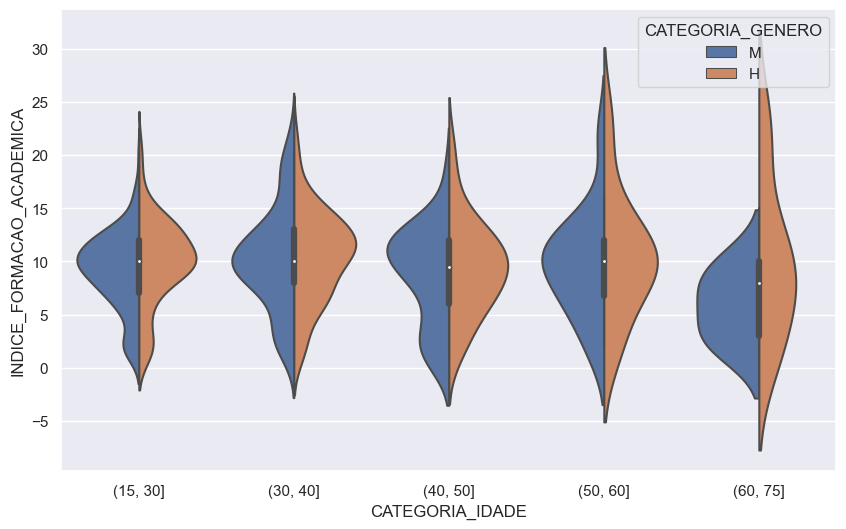

In [479]:
plt.figure(figsize=(10,6))
sns.violinplot(
    data=df_2_eda_ajustada[['INDICE_FORMACAO_ACADEMICA','CATEGORIA_IDADE','CATEGORIA_GENERO']].query('CATEGORIA_GENERO == "H" or CATEGORIA_GENERO == "M"'),
    y="INDICE_FORMACAO_ACADEMICA", x="CATEGORIA_IDADE", hue='CATEGORIA_GENERO', split=True
)
arquivo = 'VIOLINPLOT_INDICE_FORMACAO_ACADEMICA_CAT_IDADE_GENERO.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')


In [391]:
print(df_2_eda_ajustada.groupby('CATEGORIA_IDADE')['RENDA_M_INDIVIDUAL'].agg(np.median).sort_values())

CATEGORIA_IDADE
(15, 30]    3.0
(30, 40]    4.0
(40, 50]    4.0
(50, 60]    4.0
(60, 75]    5.0
Name: RENDA_M_INDIVIDUAL, dtype: float64


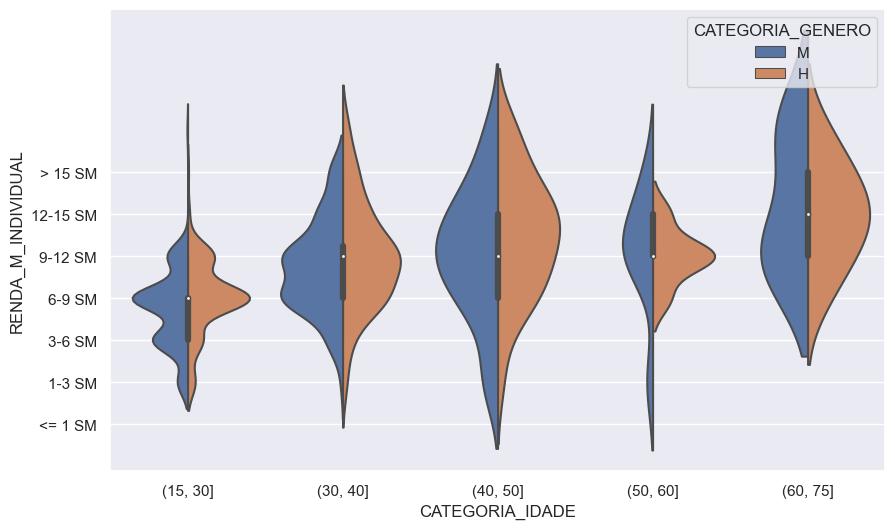

In [480]:

plt.figure(figsize=(10,6))
plt.yticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=0)

sns.violinplot(
    #data=df_selecao[['RENDA_M_INDIVIDUAL','CATEGORIA_IDADE','CATEGORIA_GENERO']].query('CATEGORIA_GENERO' == "H" or 'CATEGORIA_GENERO == "M"')['RENDA_M_INDIVIDUAL'],
    data=df_2_eda_ajustada[['RENDA_M_INDIVIDUAL','CATEGORIA_IDADE','CATEGORIA_GENERO']].query('CATEGORIA_GENERO == "H" or CATEGORIA_GENERO == "M"'),
    y="RENDA_M_INDIVIDUAL", x="CATEGORIA_IDADE", hue="CATEGORIA_GENERO", split=True
)
arquivo = 'VIOLINPLOT_RENDA_M_INDIVIDUAL_CAT_IDADE_GENERO.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

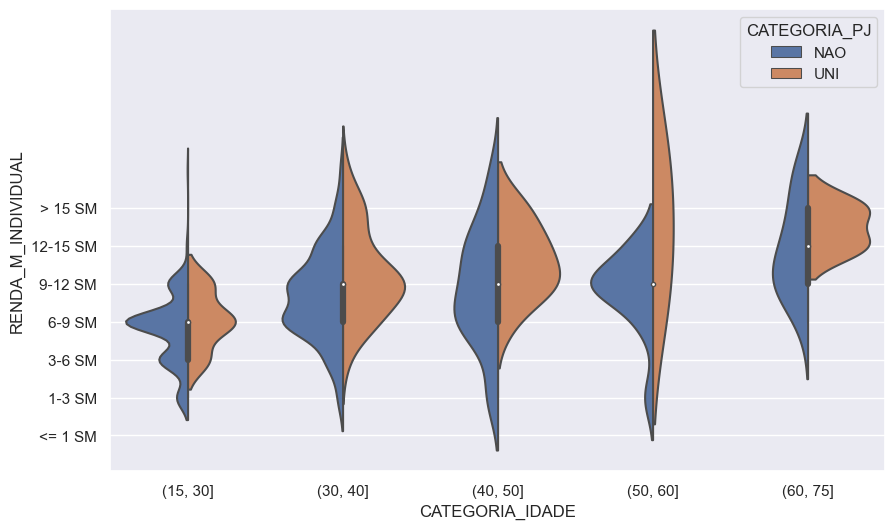

In [393]:

plt.figure(figsize=(10,6))
plt.yticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=0)

sns.violinplot(
    #data=df_selecao[['RENDA_M_INDIVIDUAL','CATEGORIA_IDADE','CATEGORIA_GENERO']].query('CATEGORIA_GENERO' == "H" or 'CATEGORIA_GENERO == "M"')['RENDA_M_INDIVIDUAL'],
    data=df_2_eda_ajustada[['RENDA_M_INDIVIDUAL','CATEGORIA_IDADE','CATEGORIA_PJ']].query('CATEGORIA_PJ == "NAO" or CATEGORIA_PJ == "UNI"'),
    y="RENDA_M_INDIVIDUAL", x="CATEGORIA_IDADE", hue="CATEGORIA_PJ", split=True
)
arquivo = 'VIOLINPLOT_RENDA_M_INDIVIDUAL_CAT_IDADE_GENERO.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

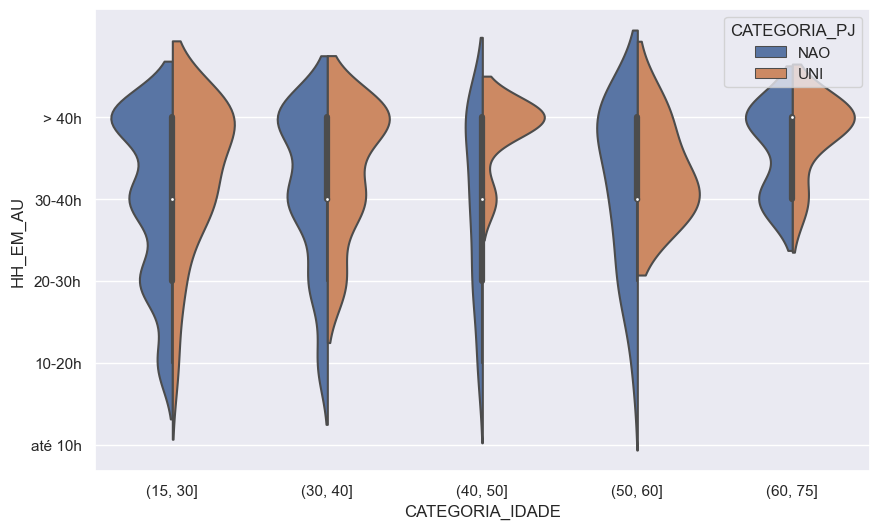

In [394]:
plt.figure(figsize=(10,6))
plt.yticks(dict_ticks['HH_EM_AU'][0], dict_ticks['HH_EM_AU'][1], rotation=0)
sns.violinplot(
    #data=df_selecao[['RENDA_M_INDIVIDUAL','CATEGORIA_IDADE','CATEGORIA_GENERO']].query('CATEGORIA_GENERO' == "H" or 'CATEGORIA_GENERO == "M"')['RENDA_M_INDIVIDUAL'],
    data=df_2_eda_ajustada[['HH_EM_AU','CATEGORIA_IDADE','CATEGORIA_PJ']].query('CATEGORIA_PJ == "NAO" or CATEGORIA_PJ == "UNI"'),
    y="HH_EM_AU", x="CATEGORIA_IDADE", hue="CATEGORIA_PJ", split=True
)
arquivo = 'VIOLINPLOT_HH_EM_AU_CAT_IDADE_PJ.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

In [133]:
df_2_eda_ajustada.columns.values

array(['IDADE', 'RENDA_M_INDIVIDUAL', 'RENDA_M_FAMILIAR',
       'RENDA_FONTE_ASSALARIADO1', 'RENDA_FONTE_ASSALARIADO4',
       'RENDA_FONTE_AUTONOMO2', 'RENDA_FONTE_EMPRESARIO2',
       'FONTE_RENDA_AU', 'FONTE_RENDA_NAO_AU', 'FONTE_RENDA_EXTRA',
       'HH_EM_AU', 'HH_FORA_AU', 'RENDA_POR_HH_AU', 'RENDA_POR_HH_TOTAL',
       'ESCOLARIDADE', 'INDICE_FORMACAO_ACADEMICA',
       'INDICE_SATISFACAO_IES', 'QNTD_IDIOMAS',
       'INDICE_PARTICIPACAO_EVENTOS', 'INDICE_OBSTACULOS_PROFISSIONAIS',
       'INDICE_SATISFACAO_PROFISSIONAL', 'AVALIACAO_MERCADO_AU',
       'AVALIACAO_MERCADO_OUTROS', 'INDICE_PROJ_OBRA',
       'QNTD_ENTIDADES_FILIADAS', 'DOMINIO_INFORMATICA',
       'CATEGORIA_GENERO', 'UF', 'REGIAO', 'CATEGORIA_PJ', 'ATUACAO_INT',
       'ATUACAO_PSG', 'ATUACAO_AU', 'ATUACAO_COMP', 'ATUACAO_SEG',
       'ATUACAO_PAT', 'ATUACAO_OUTROS', 'ATUACAO_PUR', 'ATUACAO_GEO',
       'ATUACAO_ENS', 'DOMINIO_OUTROS_SOFTWARES', 'CATEGORIA_IDADE'],
      dtype=object)

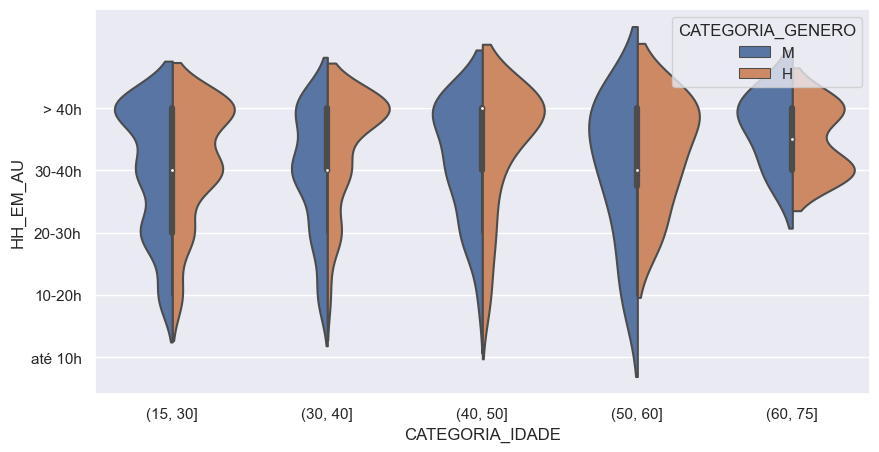

In [396]:

plt.figure(figsize=figsize_hist)
plt.yticks(dict_ticks['HH_EM_AU'][0], dict_ticks['HH_EM_AU'][1], rotation=0)
sns.violinplot(
    #data=df_selecao[['RENDA_M_INDIVIDUAL','CATEGORIA_IDADE','CATEGORIA_GENERO']].query('CATEGORIA_GENERO' == "H" or 'CATEGORIA_GENERO == "M"')['RENDA_M_INDIVIDUAL'],
    data=df_2_eda_ajustada[['HH_EM_AU','CATEGORIA_IDADE','CATEGORIA_GENERO']].query('CATEGORIA_GENERO == "H" or CATEGORIA_GENERO == "M"'),
    y="HH_EM_AU", x="CATEGORIA_IDADE", hue="CATEGORIA_GENERO", split=True
)
arquivo = 'VIOLINPLOT_HH_EM_AUL_CAT_IDADE_GENERO.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

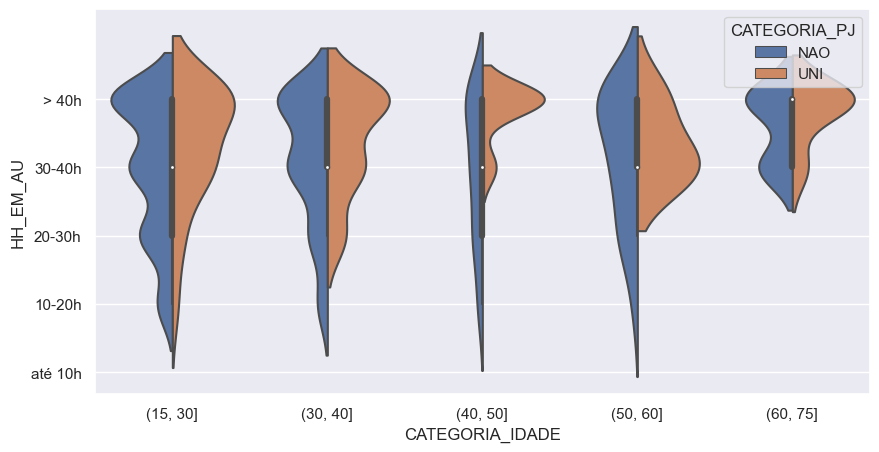

In [397]:
plt.figure(figsize=figsize_hist)
plt.yticks(dict_ticks['HH_EM_AU'][0], dict_ticks['HH_EM_AU'][1], rotation=0)
sns.violinplot(
    #data=df_selecao[['RENDA_M_INDIVIDUAL','CATEGORIA_IDADE','CATEGORIA_GENERO']].query('CATEGORIA_GENERO' == "H" or 'CATEGORIA_GENERO == "M"')['RENDA_M_INDIVIDUAL'],
    data=df_2_eda_ajustada[['HH_EM_AU','CATEGORIA_IDADE','CATEGORIA_PJ']].query('CATEGORIA_PJ == "NAO" or CATEGORIA_PJ == "UNI"'),
    y="HH_EM_AU", x="CATEGORIA_IDADE", hue="CATEGORIA_PJ", split=True
)
arquivo = 'VIOLINPLOT_HH_EM_AUL_CAT_IDADE_PJ.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

### 2.5.2 Análise de Áreas de Atuação por Categorias

In [45]:
df_2_eda_ajustada.shape[0]

783

In [134]:
colunas_atuacao = [coluna for coluna in df_2_eda_ajustada.columns if coluna.startswith("ATUACAO_")]
resultados = []

filtro = 'CATEGORIA_GENERO'
#filtro = 'CATEGORIA_IDADE'
#filtro = 'CATEGORIA_PJ'
for coluna in colunas_atuacao:
    resultado_coluna = df_2_eda_ajustada[df_2_eda_ajustada[coluna] == 1].groupby(filtro)[coluna].count()
    resultado_coluna = resultado_coluna / df_2_eda_ajustada.shape[0] * 100 #df_2_eda_ajustada[coluna].sum() * 100  # Calcula o percentual
    resultados.append(resultado_coluna)


# Criar DataFrame com os resultados
df_resultados = pd.concat(resultados, axis=1)
df_resultados.columns = colunas_atuacao

df_resultados

ATUACAO_INT  ATUACAO_PSG  ATUACAO_AU  ATUACAO_COMP  \
CATEGORIA_GENERO                                                       
H                   20.434227     8.301405   24.265645      9.323116   
INDEF                6.130268     2.043423    6.641124      1.787995   
M                   33.461047     7.662835   27.075351      4.214559   

                  ATUACAO_SEG  ATUACAO_PAT  ATUACAO_OUTROS  ATUACAO_PUR  \
CATEGORIA_GENERO                                                          
H                    0.766284     2.554278        8.812261     5.874840   
INDEF                0.510856     0.127714        2.554278     0.766284   
M                    0.766284     2.809706        8.556833     5.236271   

                  ATUACAO_GEO  ATUACAO_ENS  
CATEGORIA_GENERO                            
H                    3.448276     4.725415  
INDEF                0.510856     1.021711  
M                    1.660281     4.597701

In [57]:
df_resultados

ATUACAO_INT  ATUACAO_PSG  ATUACAO_AU  ATUACAO_COMP  \
CATEGORIA_GENERO                                                       
H                    0.204342     0.083014    0.242656      0.093231   
INDEF                0.061303     0.020434    0.066411      0.017880   
M                    0.334610     0.076628    0.270754      0.042146   

                  ATUACAO_SEG  ATUACAO_PAT  ATUACAO_OUTROS  ATUACAO_PUR  \
CATEGORIA_GENERO                                                          
H                    0.007663     0.025543        0.088123     0.058748   
INDEF                0.005109     0.001277        0.025543     0.007663   
M                    0.007663     0.028097        0.085568     0.052363   

                  ATUACAO_GEO  ATUACAO_ENS  
CATEGORIA_GENERO                            
H                    0.034483     0.047254  
INDEF                0.005109     0.010217  
M                    0.016603     0.045977

In [58]:
def comparar_respostas(df):
    sns.set_theme(style="whitegrid")
    df_melted = df.transpose().melt(var_name='Campo', value_name='Respostas', ignore_index=False)
    #df_melted = df.melt(var_name='Campo', value_name='Respostas', ignore_index=False)
    plt.figure(figsize=(12, 4))
    sns.barplot(
        data=df_melted,
        x=df_melted.index,
        y='Respostas',
        hue='Campo',
        palette='Set2',
        #multiple='stack'
        #orient='x',
        )
    plt.ylabel('Percentual de respostas')
    #plt.title('Comparação das respostas por gênero para cada campo de interesse')
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.xticks(rotation=90)
    arquivo = 'FILTRO_CATEGORIAS_GENERO.png'
    plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')  
    plt.show()

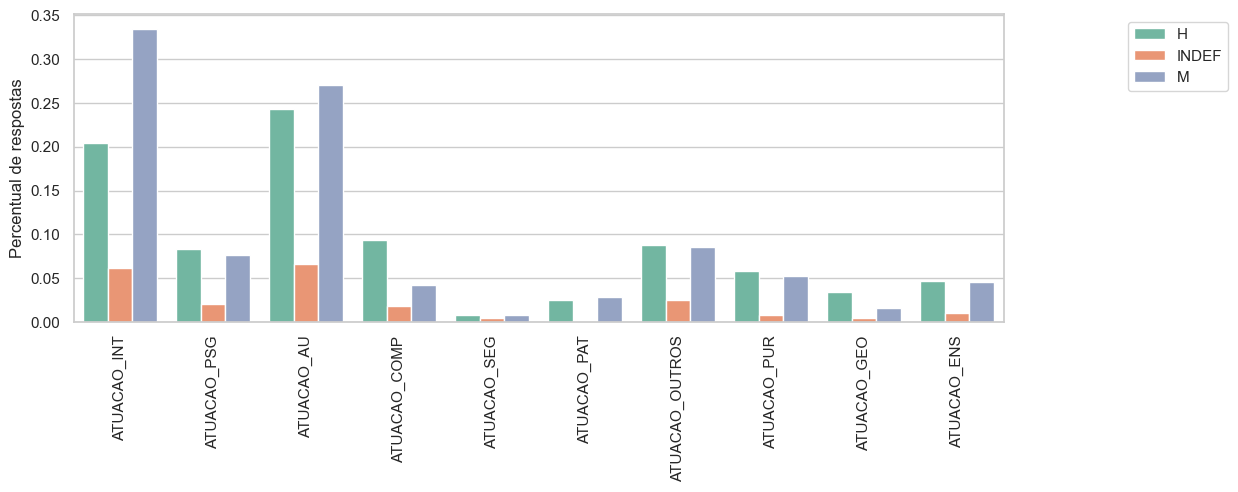

In [59]:
comparar_respostas(df_resultados)

In [406]:
print(df_2_eda_ajustada.groupby('CATEGORIA_PJ')['IDADE'].agg(np.median).sort_values())

CATEGORIA_PJ
NAO      30.0
MISTA    31.0
UNI      35.0
Name: IDADE, dtype: float64


In [407]:
print(df_2_eda_ajustada.groupby('CATEGORIA_PJ')['HH_EM_AU'].agg(np.median).sort_values())

CATEGORIA_PJ
NAO      4.0
MISTA    5.0
UNI      5.0
Name: HH_EM_AU, dtype: float64


# 3. Tratamento dos Dados

### Substituição Parcial dos Nulos: Aplicação de Medianas e Zeros
### Remoção Parcial de Outliers
### Imputation: ?
### Dropagem de Nulos Restantes

## 3.1 Primeira Dropagem Parcial de Nulos

### 3.1.1 Substituição Parcial dos Nulos

#### Procedimento:
- Preencher nulos com valores esperados, quando cabível;
- Remover entradas com outliers, para um subconjunto de features;

In [135]:
df_3 = df_2_eda.copy()
df_3 = df_2_eda_ajustada.copy()
df_3.shape

(783, 42)

<Axes: >

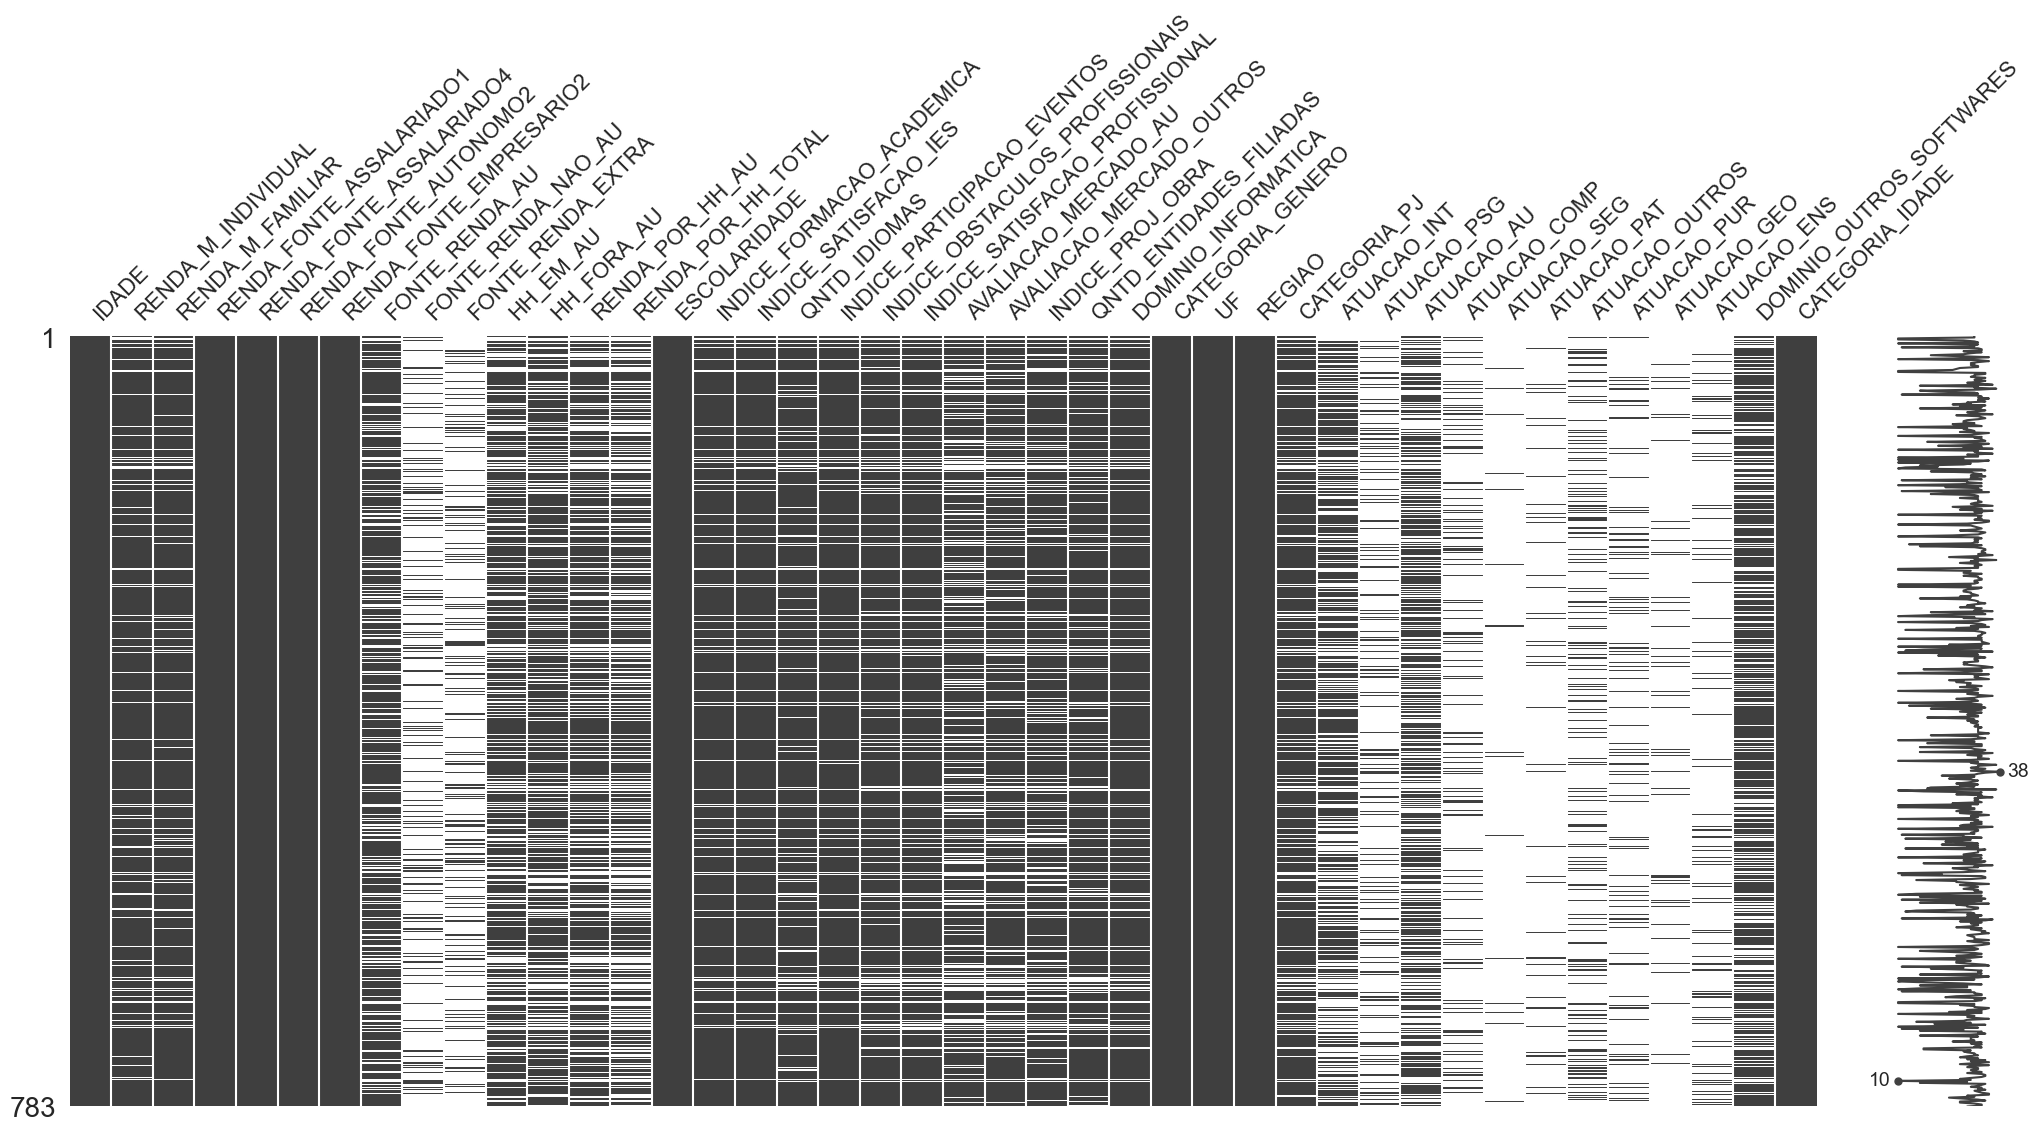

In [409]:
msno.matrix(df_3)

In [85]:
df_3['CATEGORIA_PJ'].mode()

0    NAO
Name: CATEGORIA_PJ, dtype: object

In [136]:
#df_3.isna().sum()
print((df_3.isna().sum() / len(df_3)).sort_values(ascending=False))

ATUACAO_SEG                        0.979566
ATUACAO_PAT                        0.945083
ATUACAO_GEO                        0.943806
ATUACAO_ENS                        0.896552
ATUACAO_PUR                        0.881226
ATUACAO_COMP                       0.846743
FONTE_RENDA_NAO_AU                 0.827586
ATUACAO_PSG                        0.819923
FONTE_RENDA_EXTRA                  0.817369
ATUACAO_OUTROS                     0.800766
ATUACAO_AU                         0.420179
RENDA_POR_HH_TOTAL                 0.401022
ATUACAO_INT                        0.399745
RENDA_POR_HH_AU                    0.310345
DOMINIO_OUTROS_SOFTWARES           0.303959
HH_EM_AU                           0.298851
HH_FORA_AU                         0.279693
AVALIACAO_MERCADO_AU               0.275862
FONTE_RENDA_AU                     0.233716
AVALIACAO_MERCADO_OUTROS           0.220945
INDICE_PROJ_OBRA                   0.214559
QNTD_ENTIDADES_FILIADAS            0.166028
CATEGORIA_PJ                    

In [412]:
df_3.dtypes

IDADE                                 int32
RENDA_M_INDIVIDUAL                  float64
RENDA_M_FAMILIAR                    float64
RENDA_FONTE_ASSALARIADO1               int8
RENDA_FONTE_ASSALARIADO4               int8
RENDA_FONTE_AUTONOMO2                  int8
RENDA_FONTE_EMPRESARIO2                int8
FONTE_RENDA_AU                      float64
FONTE_RENDA_NAO_AU                  float64
FONTE_RENDA_EXTRA                   float64
HH_EM_AU                            float64
HH_FORA_AU                          float64
RENDA_POR_HH_AU                     float64
RENDA_POR_HH_TOTAL                  float64
ESCOLARIDADE                           int8
INDICE_FORMACAO_ACADEMICA           float64
INDICE_SATISFACAO_IES               float64
QNTD_IDIOMAS                        float64
INDICE_PARTICIPACAO_EVENTOS         float64
INDICE_OBSTACULOS_PROFISSIONAIS     float64
INDICE_SATISFACAO_PROFISSIONAL      float64
AVALIACAO_MERCADO_AU                float64
AVALIACAO_MERCADO_OUTROS        

In [137]:
dict_fillna = {
    'IDADE': np.nan, 'RENDA_M_INDIVIDUAL':np.nan, 'RENDA_M_FAMILIAR':np.nan, 'FONTE_RENDA_AU':np.nan, 'FONTE_RENDA_NAO_AU':0, 'FONTE_RENDA_EXTRA':0,
    'HH_EM_AU': np.nan,'HH_FORA_AU': np.nan,'RENDA_POR_HH_TOTAL': np.nan, 'ESCOLARIDADE': 1,
    'INDICE_FORMACAO_ACADEMICA': np.nan, 'INDICE_OBSTACULOS_PROFISSIONAIS': np.nan, 'INDICE_SATISFACAO_PROFISSIONAL': np.nan, 
    'AVALIACAO_MERCADO_AU': np.nan, 'AVALIACAO_MERCADO_OUTROS': np.nan, 'INDICE_PROJ_OBRA': np.nan,
    'QNTD_ENTIDADES_FILIADAS': 0,'DOMINIO_INFORMATICA': np.nan,'CATEGORIA_GENERO': 'INDEF',
    'UF': np.nan, 'REGIAO': np.nan, 'CATEGORIA_PJ': df_3['CATEGORIA_PJ'].mode(), 'QNTD_IDIOMAS': 1, 'QNTD_ENTIDADES_FILIADAS': 0,
    'ATUACAO_INT': 0, 'ATUACAO_PSG': 0, 'ATUACAO_AU': 0, 'ATUACAO_COMP': 0, 'ATUACAO_SEG': 0, 'ATUACAO_PAT': 0, 'ATUACAO_OUTROS': 0, 'ATUACAO_PUR': 0,
    'ATUACAO_GEO': 0, 'ATUACAO_ENS': 0, 'DOMINIO_OUTROS_SOFTWARES': 0, #CATEGORIA_IDADE': 0
              }

In [138]:
df_3.fillna(value=dict_fillna,inplace=True)

### 1.2.2 Remoção Parcial de Outliers

#### Subset e Normalização

#### Nulos do subset

#### Marcação e Droppagem dos Outliers

### Remoção Parcial de Outliers

### Imputation: Mediana

<Axes: >

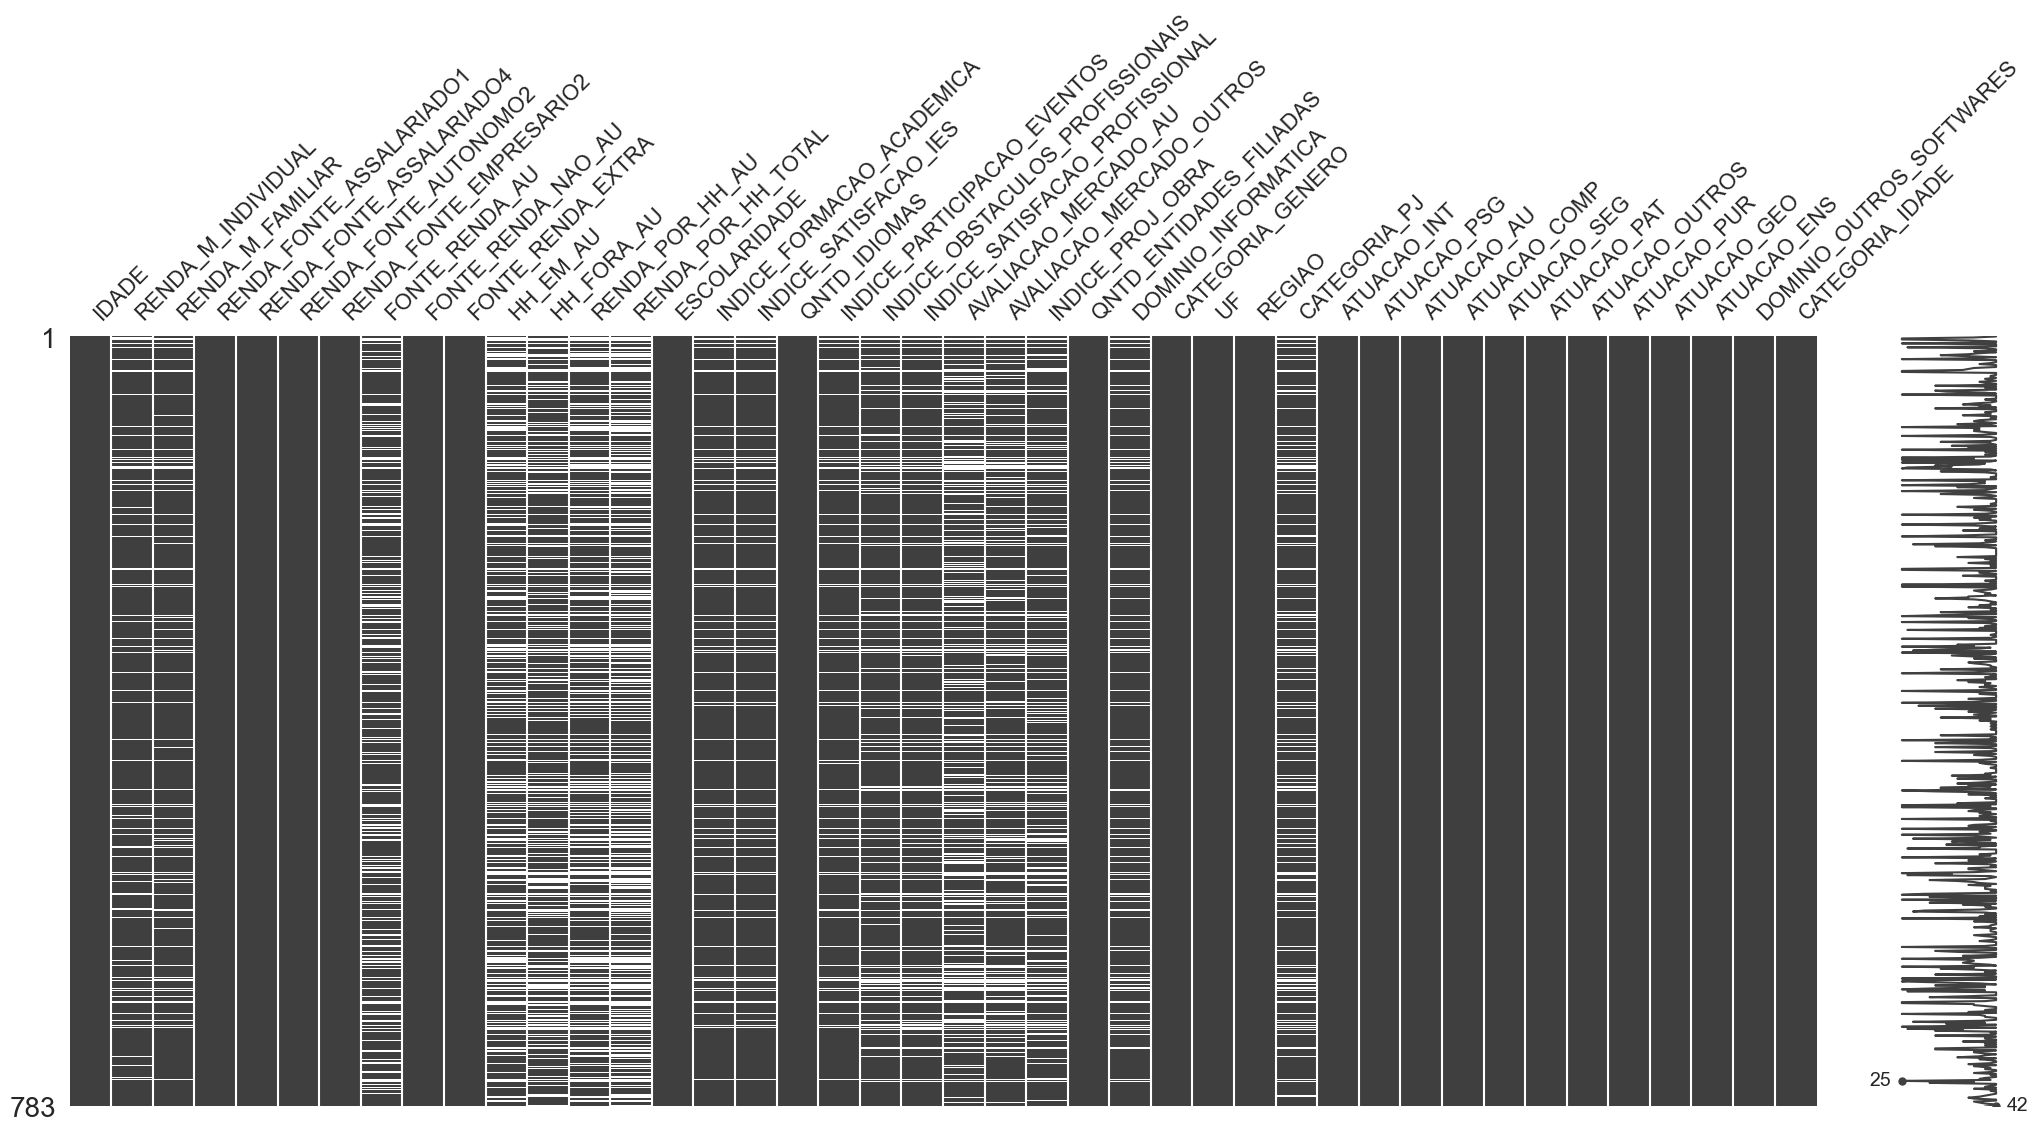

In [415]:
msno.matrix(df_3)

In [139]:
print((df_3.isna().sum() / len(df_3)).sort_values(ascending=False))

RENDA_POR_HH_TOTAL                 0.401022
RENDA_POR_HH_AU                    0.310345
HH_EM_AU                           0.298851
HH_FORA_AU                         0.279693
AVALIACAO_MERCADO_AU               0.275862
FONTE_RENDA_AU                     0.233716
AVALIACAO_MERCADO_OUTROS           0.220945
INDICE_PROJ_OBRA                   0.214559
CATEGORIA_PJ                       0.162197
INDICE_SATISFACAO_PROFISSIONAL     0.150702
INDICE_OBSTACULOS_PROFISSIONAIS    0.149425
DOMINIO_INFORMATICA                0.121328
RENDA_M_FAMILIAR                   0.102171
RENDA_M_INDIVIDUAL                 0.098340
INDICE_PARTICIPACAO_EVENTOS        0.090677
INDICE_SATISFACAO_IES              0.089400
INDICE_FORMACAO_ACADEMICA          0.086845
ATUACAO_AU                         0.000000
ATUACAO_PSG                        0.000000
ATUACAO_SEG                        0.000000
ATUACAO_COMP                       0.000000
ATUACAO_PAT                        0.000000
ATUACAO_OUTROS                  

Mínimo de colunas preenchidas, por entrada: 34/42


<Axes: >

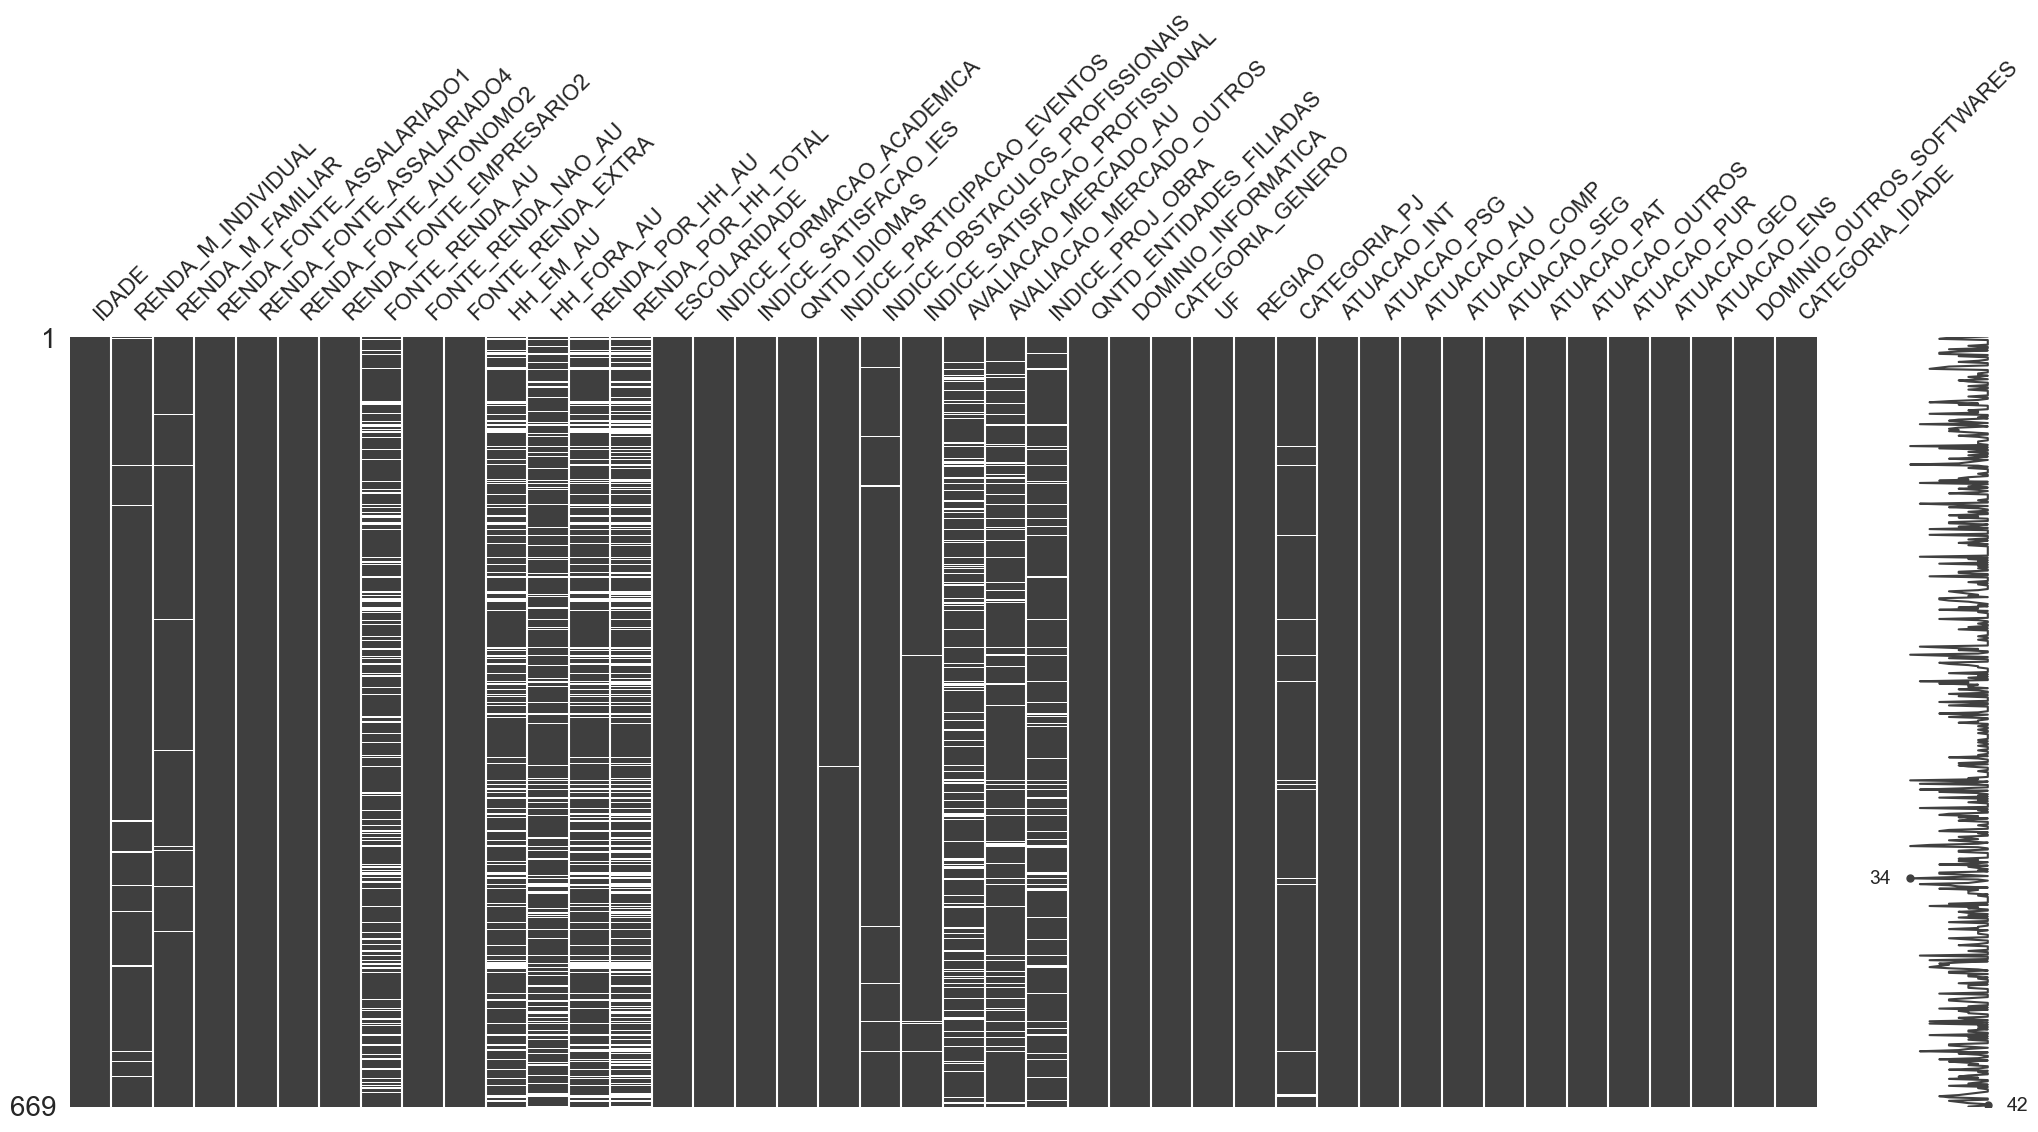

In [140]:
limiar_perc = .80
limiar_val = round((len(df_3.columns.tolist())*limiar_perc))
print(f'Mínimo de colunas preenchidas, por entrada: {limiar_val}/{df_3.shape[1]}')
dfx = df_3.dropna(thresh=limiar_val,axis=0,inplace=False)
msno.matrix(dfx)

In [90]:
dfx.dtypes.values
#dfx.select_dtypes(include = ['float']).info()

array([dtype('int32'), dtype('float64'), dtype('float64'), dtype('int8'),
       dtype('int8'), dtype('int8'), dtype('int8'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('int8'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'), dtype('O'),
       dtype('O'), dtype('O'), dtype('O'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'),
       CategoricalDtype(categories=[(15, 30], (30, 40], (40, 50], (50, 60], (60, 75]], ordered=True)],
      dtype=object)

In [170]:
''''''''''''''''
def preenche_mediana_coluna(df, coluna):
    df[coluna] = df[coluna].apply(lambda x: df[coluna].median() if pd.isnull(x) else x)
    return df
'''''''''''''''

SyntaxError: unterminated string literal (detected at line 5) (553581147.py, line 5)

In [141]:
def converter_integer(df):
        for coluna in df.select_dtypes(['float']).columns.tolist():
                try:
                        df[coluna] = df[coluna].astype(int)
                except ValueError:
                        pass

def preencher_mediana(df):
        for coluna in df.select_dtypes(['integer', 'float']).columns.tolist():
                try:
                        df[coluna] = df[coluna].fillna(df[coluna].median())
                except ValueError:
                        pass
                
def preencher_moda(df):
        for coluna in df.select_dtypes(['object']).columns.tolist():
                try:
                        df[coluna] = df[coluna].fillna(df[coluna].mode()[0])
                except ValueError:
                        pass

C:\Users\bruno\AppData\Local\Temp\ipykernel_25028\3973216613.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[coluna] = df[coluna].astype(int)
C:\Users\bruno\AppData\Local\Temp\ipykernel_25028\3973216613.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[coluna] = df[coluna].astype(int)
C:\Users\bruno\AppData\Local\Temp\ipykernel_25028\3973216613.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

<Axes: >

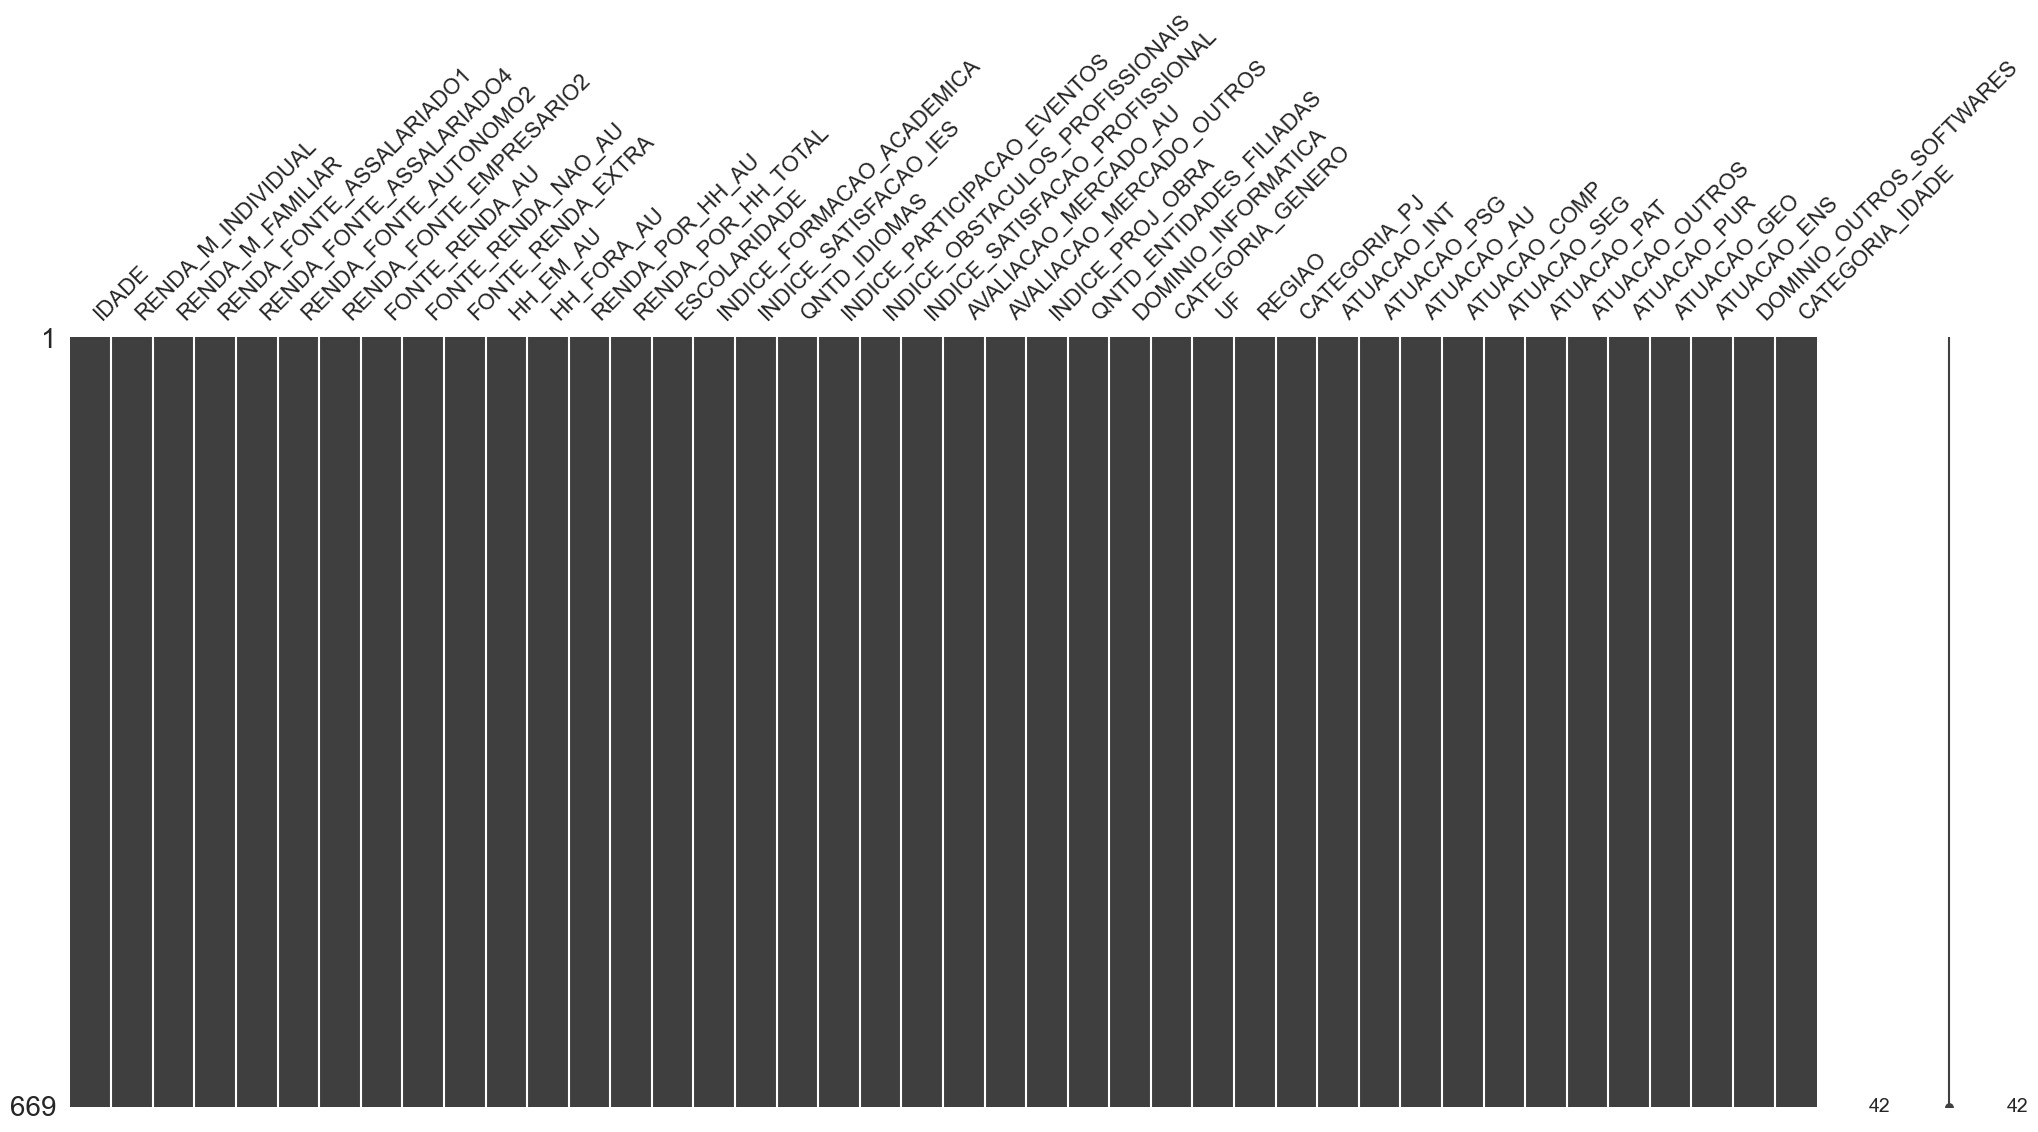

In [142]:
converter_integer(dfx)
preencher_mediana(dfx)
preencher_moda(dfx)
msno.matrix(dfx)
#dfx.dtypes


In [217]:
df_4_eda = dfx.copy()

In [218]:
df_4_eda.describe().transpose()

count       mean        std     min  \
IDADE                            669.0  33.997010  10.092090  23.000   
RENDA_M_INDIVIDUAL               669.0   3.402093   1.259002   1.000   
RENDA_M_FAMILIAR                 669.0   4.908819   1.629370   1.000   
RENDA_FONTE_ASSALARIADO1         669.0   0.019432   0.138141   0.000   
RENDA_FONTE_ASSALARIADO4         669.0   0.037369   0.189807   0.000   
RENDA_FONTE_AUTONOMO2            669.0   0.097160   0.296397   0.000   
RENDA_FONTE_EMPRESARIO2          669.0   0.046338   0.210373   0.000   
FONTE_RENDA_AU                   669.0   1.107623   0.346607   1.000   
FONTE_RENDA_NAO_AU               669.0   0.200299   0.439719   0.000   
FONTE_RENDA_EXTRA                669.0   0.212257   0.434065   0.000   
HH_EM_AU                         669.0   4.098655   0.876753   2.000   
HH_FORA_AU                       669.0   1.374439   1.403030   0.500   
RENDA_POR_HH_AU                  669.0   0.877379   0.323591   0.200   
RENDA_POR_HH_TOTAL               669.0   0.665706   0.205406   0.125   
ESCOLARIDADE                     669.0   1.491779   0.627709   1.000   
INDICE_FORMACAO_ACADEMICA        669.0   9.512706   4.284623   1.000   
INDICE_SATISFACAO_IES            669.0   4.246637   0.732383   2.000   
QNTD_IDIOMAS                     669.0   2.387145   1.780941   0.000   
INDICE_PARTICIPACAO_EVENTOS      669.0   1.759342   0.498882   1.000   
INDICE_OBSTACULOS_PROFISSIONAIS  669.0   1.846039   0.786432   1.000   
INDICE_SATISFACAO_PROFISSIONAL   669.0  12.382661   3.308047   3.000   
AVALIACAO_MERCADO_AU             669.0   2.001495   0.784390   1.000   
AVALIACAO_MERCADO_OUTROS         669.0   4.573991   1.848121   1.000   
INDICE_PROJ_OBRA                 669.0   1.878924   0.841649   1.000   
QNTD_ENTIDADES_FILIADAS          669.0   0.222720   0.440833   0.000   
DOMINIO_INFORMATICA              669.0  14.680120   3.045942   6.000   
ATUACAO_INT                      669.0   0.701046   0.458142   0.000   
ATUACAO_PSG                      669.0   0.209268   0.407090   0.000   
ATUACAO_AU                       669.0   0.677130   0.467923   0.000   
ATUACAO_COMP                     669.0   0.179372   0.383951   0.000   
ATUACAO_SEG                      669.0   0.023916   0.152903   0.000   
ATUACAO_PAT                      669.0   0.064275   0.245426   0.000   
ATUACAO_OUTROS                   669.0   0.233184   0.423175   0.000   
ATUACAO_PUR                      669.0   0.137519   0.344652   0.000   
ATUACAO_GEO                      669.0   0.065770   0.248065   0.000   
ATUACAO_ENS                      669.0   0.119581   0.324714   0.000   
DOMINIO_OUTROS_SOFTWARES         669.0   3.143498   1.712155   0.000   

                                       25%        50%        75%        max  
IDADE                            27.000000  30.000000  39.000000  73.000000  
RENDA_M_INDIVIDUAL                3.000000   3.000000   4.000000   7.000000  
RENDA_M_FAMILIAR                  4.000000   5.000000   6.000000   8.000000  
RENDA_FONTE_ASSALARIADO1          0.000000   0.000000   0.000000   1.000000  
RENDA_FONTE_ASSALARIADO4          0.000000   0.000000   0.000000   1.000000  
RENDA_FONTE_AUTONOMO2             0.000000   0.000000   0.000000   1.000000  
RENDA_FONTE_EMPRESARIO2           0.000000   0.000000   0.000000   1.000000  
FONTE_RENDA_AU                    1.000000   1.000000   1.000000   4.000000  
FONTE_RENDA_NAO_AU                0.000000   0.000000   0.000000   3.000000  
FONTE_RENDA_EXTRA                 0.000000   0.000000   0.000000   2.000000  
HH_EM_AU                          4.000000   4.000000   5.000000   5.000000  
HH_FORA_AU                        0.500000   0.500000   2.000000   5.000000  
RENDA_POR_HH_AU                   0.750000   0.800000   1.000000   3.000000  
RENDA_POR_HH_TOTAL                0.545455   0.666667   0.727273   1.555556  
ESCOLARIDADE                      1.000000   1.000000   2.000000   4.000000  
INDICE_FORMACAO_ACADEMICA         7.000000  10.0

In [96]:
df_4_eda.dtypes

IDADE                                 int32
RENDA_M_INDIVIDUAL                  float64
RENDA_M_FAMILIAR                    float64
RENDA_FONTE_ASSALARIADO1               int8
RENDA_FONTE_ASSALARIADO4               int8
RENDA_FONTE_AUTONOMO2                  int8
RENDA_FONTE_EMPRESARIO2                int8
FONTE_RENDA_AU                      float64
FONTE_RENDA_NAO_AU                    int32
FONTE_RENDA_EXTRA                     int32
HH_EM_AU                            float64
HH_FORA_AU                          float64
RENDA_POR_HH_AU                     float64
RENDA_POR_HH_TOTAL                  float64
ESCOLARIDADE                           int8
INDICE_FORMACAO_ACADEMICA             int32
INDICE_SATISFACAO_IES                 int32
QNTD_IDIOMAS                          int32
INDICE_PARTICIPACAO_EVENTOS         float64
INDICE_OBSTACULOS_PROFISSIONAIS     float64
INDICE_SATISFACAO_PROFISSIONAL      float64
AVALIACAO_MERCADO_AU                float64
AVALIACAO_MERCADO_OUTROS        

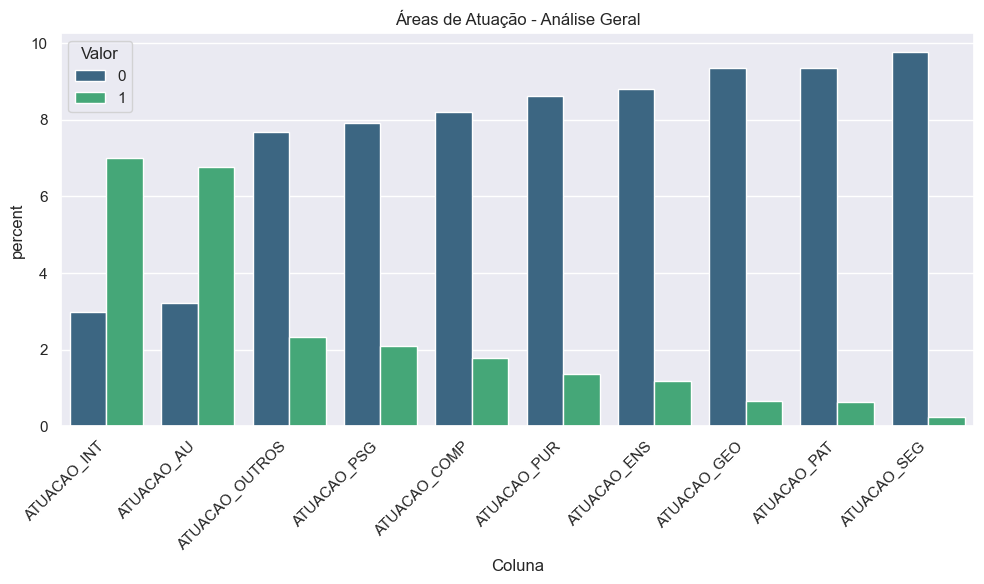

In [474]:
atuacao_cols = [col for col in df_4_eda.columns if col.startswith("ATUACAO_")]
data = df_4_eda
#data = df_4_analise
df_atuacao = data.filter(regex='^ATUACAO_')[atuacao_cols]
df_melted = df_atuacao.melt(var_name="Coluna", value_name="Valor")

count_ones = df_atuacao.sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.countplot(
    df_melted, x="Coluna", hue="Valor",
    palette='viridis',
    order=count_ones.index,
    stat='percent',
    dodge=True,
    )
plt.title(f"Áreas de Atuação - Análise Geral")
#plt.xlabel("Colunas ATUACAO_")
#plt.ylabel("Contagem")
#plt.legend(title="Valor")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
arquivo = fr'AREAS_DE_ATUACAO_COUNTPLOT_GERAL.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')
plt.show()

In [459]:
from scipy.stats import fisher_exact
from scipy.stats import barnard_exact
data = df_4_eda.filter(regex='^ATUACAO_').astype(float)
df_fisher_pval = pd.DataFrame(index=data.columns, columns=data.columns)
df_fisher_odds = pd.DataFrame(index=data.columns, columns=data.columns)
for col1 in data.columns:
    for col2 in data.columns:
        if col1.startswith("ATUACAO_") and col2.startswith("ATUACAO_"):
            crosstab = pd.crosstab(data[col1], data[col2])
            #odds_ratio, p_value = fisher_exact(crosstab, alternative='two-sided')
            res = barnard_exact(crosstab, alternative='two-sided')
            odds_ratio = res.statistic
            p_value = res.pvalue
            df_fisher_pval.loc[col1, col2] = p_value
            df_fisher_odds.loc[col1, col2] = odds_ratio
df_fisher_pval_float = df_fisher_pval.astype(float)
df_fisher_odds_float = df_fisher_odds.astype(float)

In [455]:
df_fisher_pval

ATUACAO_INT ATUACAO_PSG ATUACAO_AU ATUACAO_COMP ATUACAO_SEG  \
ATUACAO_INT            0.0    0.000011   0.532823     0.012879    0.083955   
ATUACAO_PSG       0.000002         0.0   0.023144     0.000423    0.589688   
ATUACAO_AU        0.557557    0.022996        0.0     0.012879    0.145314   
ATUACAO_COMP      0.003873    0.000211   0.006031          0.0    0.046827   
ATUACAO_SEG       0.076661    0.476366   0.130101     0.012879         0.0   
ATUACAO_PAT       0.035408    0.053222   0.100908     0.079465    0.425176   
ATUACAO_OUTROS    0.000138    0.951348   0.060382     0.000425    0.992859   
ATUACAO_PUR        0.00001    0.304997    0.00234     0.002317    0.999999   
ATUACAO_GEO       0.002609    0.066921   0.038771     0.000016    0.020547   
ATUACAO_ENS        0.63056    0.006824   0.660085     0.932143    0.634918   

               ATUACAO_PAT ATUACAO_OUTROS ATUACAO_PUR ATUACAO_GEO ATUACAO_ENS  
ATUACAO_INT       0.057567       0.000429    0.000144    0.026613    0.630809  
ATUACAO_PSG       0.057476       0.939275    0.305499     0.06708    0.049998  
ATUACAO_AU        0.101207       0.059946     0.00691    0.059002    0.672462  
ATUACAO_COMP        0.0788       0.000174    0.006808    0.001312    0.923989  
ATUACAO_SEG       0.393419       0.696076    0.912402    0.004372    0.509735  
ATUACAO_PAT            0.0       0.724953    0.000024    0.043786    0.061833  
ATUACAO_OUTROS    0.761093            0.0    0.912402    0.376334    0.014783  
ATUACAO_PUR       0.001247       0.895363         0.0         0.0    0.085523  
ATUACAO_GEO       0.046707       0.323998         0.0         0.0    0.729367  
ATUACAO_ENS       0.061393       0.006247    0.085494    0.731772         0.0

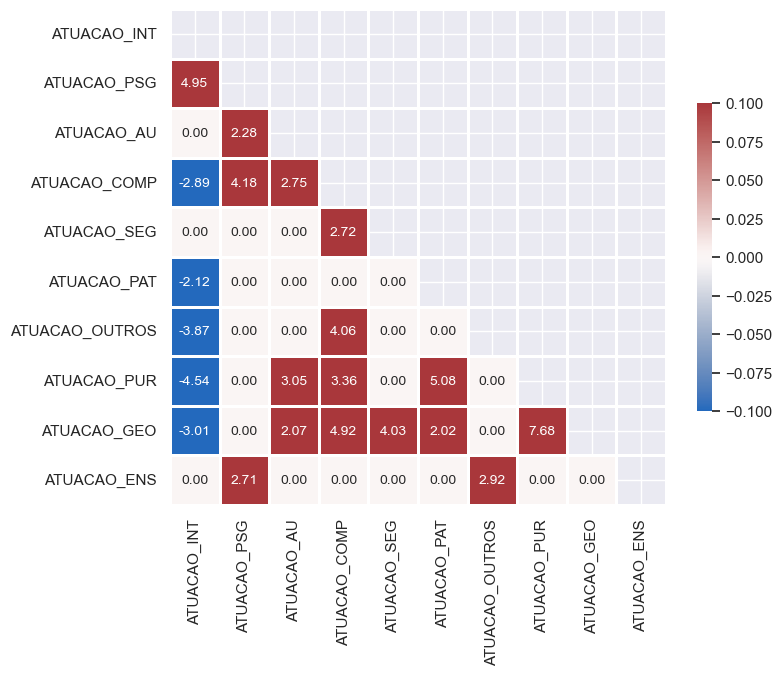

In [467]:
df_filtro = df_fisher_odds_float[df_fisher_pval_float < 0.05].fillna(value='0').astype(float)

mask = np.triu(np.ones_like(df_fisher_odds, dtype=bool))
f, ax = plt.subplots(figsize=(8, 8))

sns.set_theme(style="darkgrid")
cmap = sns.color_palette("vlag", as_cmap=True)

sns.heatmap(df_filtro, mask=mask, cmap=cmap, vmax=.1, vmin=-.1, center=0,
            annot=True, square=True, linewidths=.9, cbar_kws={"shrink": .5}, fmt=".2f", annot_kws={"size": 10})

arquivo = f'TESTE_INDEPENDENCIA_AREAS_ATUACAO_GERAL.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

In [169]:
from scipy.stats import fisher_exact
df_filtro = df_4_eda.query('CATEGORIA_GENERO == "M" and IDADE > 40')
var1 = 'ATUACAO_AU'
var2 = 'ATUACAO_INT'
data = df_filtro[[var1, var2]].dropna().copy()

odds_ratio, p_value = fisher_exact(pd.crosstab(df_filtro[var1], df_filtro[var2]))

print("Odds ratio:", odds_ratio)
print("Valor-p:", p_value)

if p_value < 0.05:
    print("\nExiste uma associação significativa entre as variáveis.")
    if odds_ratio > 1:
        print("Odds ratio é maior que 1, indicando uma associação positiva entre as variáveis.")
    elif odds_ratio < 1:
        print("Odds ratio é menor que 1, indicando uma associação negativa entre as variáveis.")
    else:
        print("Odds ratio é igual a 1, indicando que as variáveis são independentes.")
else:
    print("\nNão há uma associação significativa entre as variáveis.")

Odds ratio: 1.5757575757575757
Valor-p: 0.524926188731552

Não há uma associação significativa entre as variáveis.


O odds ratio (razão de chances) é uma medida estatística que descreve a força da associação entre duas variáveis. No contexto do teste exato de Fisher aplicado a uma tabela de contingência de duas variáveis binárias, o odds ratio representa a chance de ocorrência de um evento (por exemplo, sucesso) em uma categoria de uma variável em relação à chance de ocorrência do mesmo evento na outra categoria da mesma variável.

Um odds ratio maior que 1 sugere uma associação positiva entre as variáveis, o que significa que a ocorrência de um evento em uma categoria está associada a uma maior chance de ocorrência do evento na outra categoria.

Por outro lado, um odds ratio menor que 1 indica uma associação negativa, indicando que a ocorrência de um evento em uma categoria está associada a uma menor chance de ocorrência do evento na outra categoria.

Um odds ratio igual a 1 sugere independência entre as variáveis, o que significa que a ocorrência de um evento em uma categoria não está associada a nenhuma mudança na chance de ocorrência do evento na outra categoria.

O valor-p indica a significância estatística da associação. Um valor-p menor que o nível de significância escolhido (geralmente 0,05) sugere que há uma associação significativa entre as variáveis.

# 4. Renda Média Individual, Renda por HH, Índice de Satisfação Profissional por Região, PJ e Idade.

### Explorando a Renda Média Individual

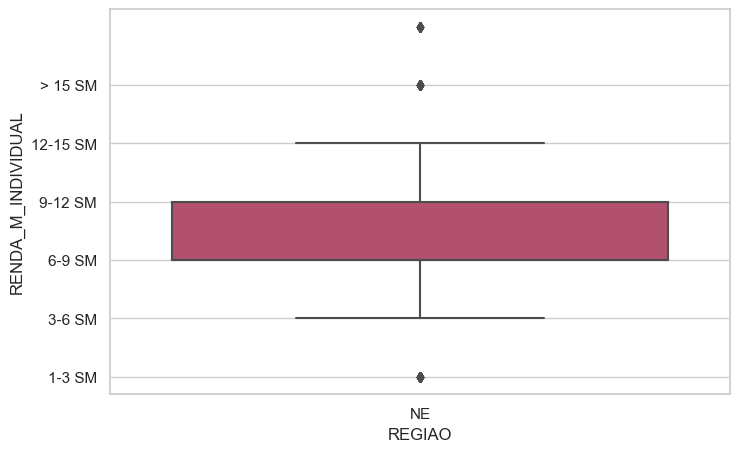

In [424]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=figsize_histbox)
plt.yticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=0)
sns.boxplot(x=df_4_eda["REGIAO"], y=df_4_eda["RENDA_M_INDIVIDUAL"], palette='flare')

arquivo = 'BOXPLOT_FONTE_RENDA_AU_REGIAO.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

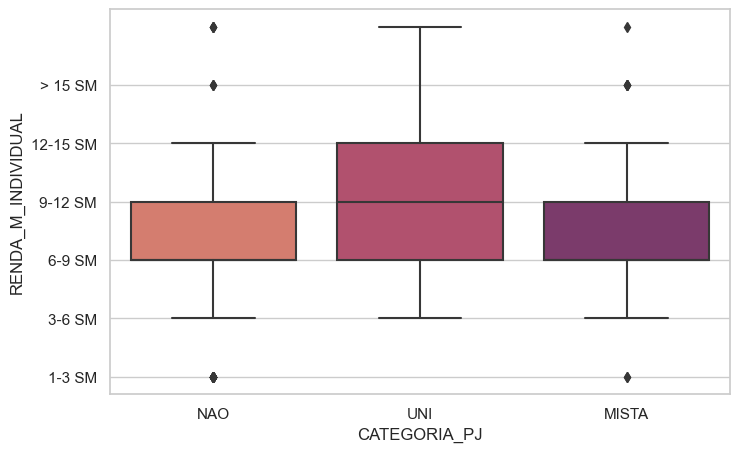

In [280]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=figsize_histbox)
plt.yticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=0)
sns.boxplot(x=df_4_eda["CATEGORIA_PJ"], y=df_4_eda["RENDA_M_INDIVIDUAL"], palette='flare')

arquivo = 'BOXPLOT_RENDA_M_INDIVIDUAL_CATEGORIA_PJ.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

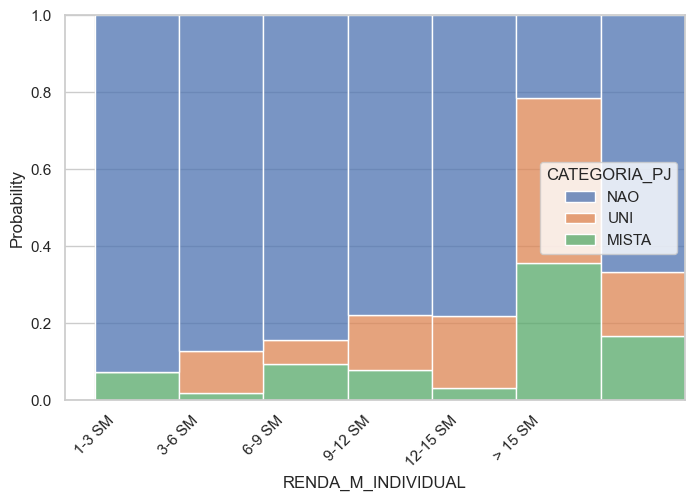

In [281]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=figsize_histbox)
plt.xticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=45)
sns.histplot(data=df_4_eda, x="RENDA_M_INDIVIDUAL", hue="CATEGORIA_PJ", stat='probability', bins=8, common_bins=True, binrange=(0,8), common_norm=True, multiple='fill',)

arquivo = 'FILLPLOT_RENDA_M_INDIVIDUAL_CATEGORIA_PJ.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

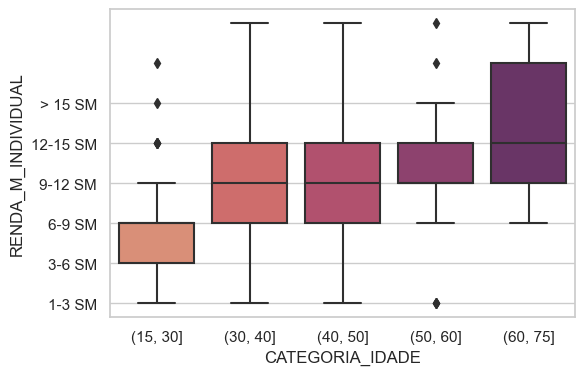

In [440]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=figsize_histbox)
plt.yticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=0)
sns.boxplot(x=df_4_eda["CATEGORIA_IDADE"], y=df_4_eda["RENDA_M_INDIVIDUAL"], palette='flare')

arquivo = 'BOXPLOT_RENDA_M_INDIVIDUAL_CATEGORIA_IDADE.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

C:\Users\bruno\AppData\Local\Temp\ipykernel_39144\1853402913.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('viridis')


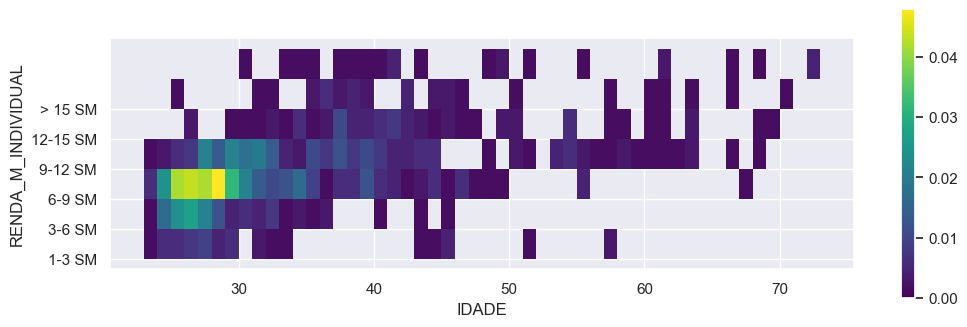

In [441]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(12,3))
plt.yticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=0)

sns.histplot(
    data=df_4_eda,
    x="IDADE",
    y="RENDA_M_INDIVIDUAL",
    stat='density',
    bins=20,
    alpha=1,
    binwidth=1,
    discrete=False,
    common_norm=False,
    multiple='stack',
    cbar=True, cbar_kws=dict(shrink=1.25),
    #color='skyblue',
    cmap=plt.cm.get_cmap('viridis')
    )

arquivo = 'HEATMAP_RENDA_M_INDIVIDUAL_IDADE.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

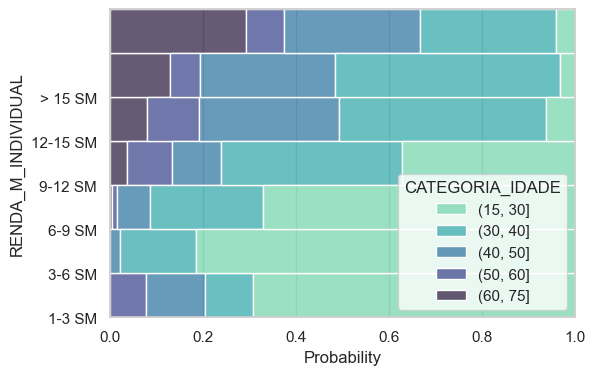

In [442]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=figsize_histbox)
plt.yticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=0)


sns.histplot(
    data=df_4_eda,
    y="RENDA_M_INDIVIDUAL",
    hue="CATEGORIA_IDADE",
    stat='probability',
    palette='mako_r',
    common_bins=True,
    binwidth=1,
    multiple='fill',
    legend=True
    )


arquivo = 'FILLPLOT_HOR_RENDA_M_INDIVIDUAL_CATEGORIA_PJ.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

### Explorando a Renda por HH Total

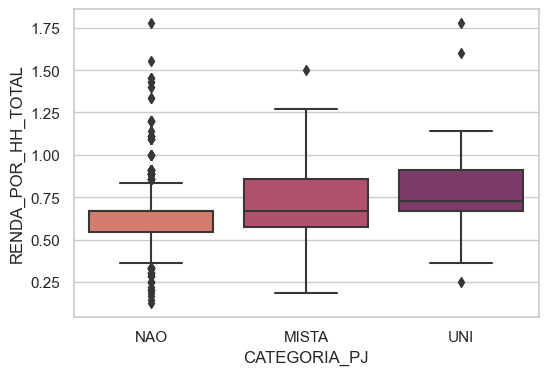

In [443]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=figsize_histbox)
#plt.yticks(dict_ticks['RENDA_POR_HH_TOTAL'][0], dict_ticks['RENDA_POR_HH_TOTAL'][1], rotation=0)
sns.boxplot(x=df_4_eda["CATEGORIA_PJ"], y=df_4_eda["RENDA_POR_HH_TOTAL"], palette='flare')
#
arquivo = 'BOXPLOT_RENDA_POR_HH_TOTAL_CATEGORIA_PJ.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

<Axes: xlabel='CATEGORIA_PJ', ylabel='RENDA_POR_HH_TOTAL'>

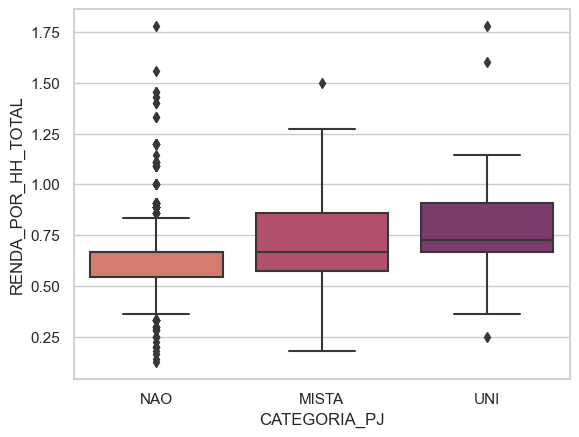

In [444]:
sns.set_theme(style="whitegrid")
sns.boxplot(x=df_4_eda["CATEGORIA_PJ"], y=df_4_eda["RENDA_POR_HH_TOTAL"], palette='flare')

<Axes: xlabel='RENDA_POR_HH_TOTAL', ylabel='Probability'>

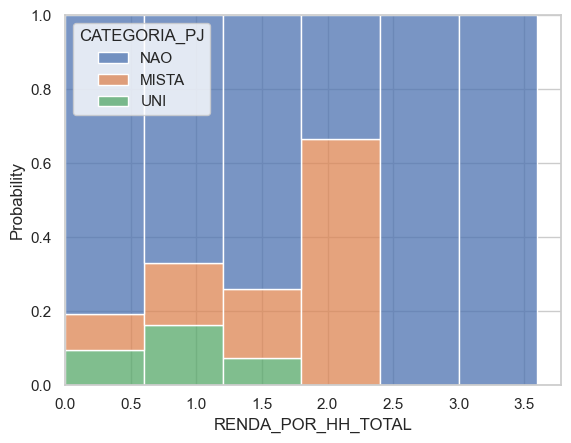

In [184]:
sns.set_theme(style="whitegrid")
sns.histplot(data=df_2_eda, x="RENDA_POR_HH_TOTAL", hue="CATEGORIA_PJ", stat='probability', bins=10, common_bins=True, binrange=(0,6), common_norm=True, multiple='fill',)

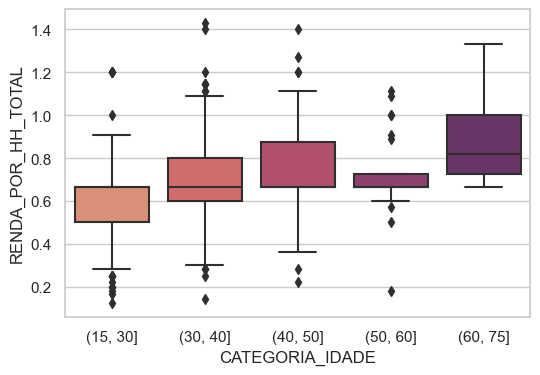

In [185]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=figsize_histbox)
#plt.yticks(dict_ticks['RENDA_POR_HH_TOTAL'][0], dict_ticks['RENDA_POR_HH_TOTAL'][1], rotation=0)
sns.boxplot(x=df_4_eda["CATEGORIA_IDADE"], y=df_4_eda["RENDA_POR_HH_TOTAL"], palette='flare')
#
arquivo = 'BOXPLOT_RENDA_POR_HH_TOTAL_CATEGORIA_IDADE.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

C:\Users\bruno\AppData\Local\Temp\ipykernel_27156\343745737.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('viridis')


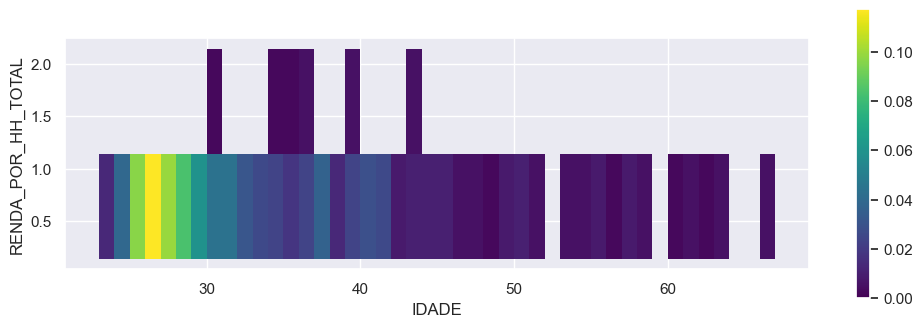

In [282]:
#sns.histplot(data=df_2_eda, x="IDADE", y="RENDA_POR_HH_TOTAL", color="skyblue", stat='density', bins=20, alpha=1, binwidth=1, discrete=False, common_norm=False, multiple='stack')

sns.set_theme(style="darkgrid")

plt.figure(figsize=(12,3))
#plt.yticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=0)

sns.histplot(
    data=df_4_eda,
    x="IDADE",
    y="RENDA_POR_HH_TOTAL",
    stat='density',
    bins=20,
    alpha=1,
    binwidth=1,
    discrete=False,
    common_norm=False,
    multiple='stack',
    cbar=True, cbar_kws=dict(shrink=1.25),
    #color='skyblue',
    cmap=plt.cm.get_cmap('viridis')
    )

arquivo = 'HEATMAP_RENDA_POR_HH_TOTAL_IDADE.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

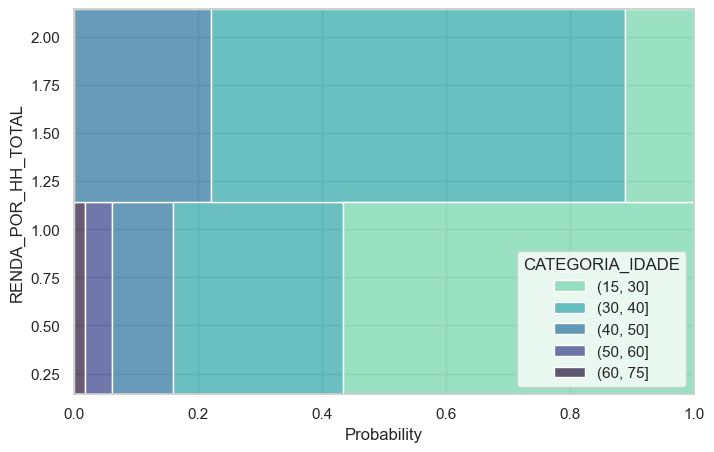

In [283]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=figsize_histbox)
#plt.yticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=0)

sns.histplot(
    data=df_4_eda,
    y="RENDA_POR_HH_TOTAL",
    hue="CATEGORIA_IDADE",
    stat='probability',
    palette='mako_r',
    common_bins=True,
    binwidth=1,
    multiple='fill',
    legend=True
    )


arquivo = 'FILLPLOT_HOR_RENDA_POR_HH_TOTAL_CATEGORIA_IDADE.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

### Explorando a Satisfação Profissional

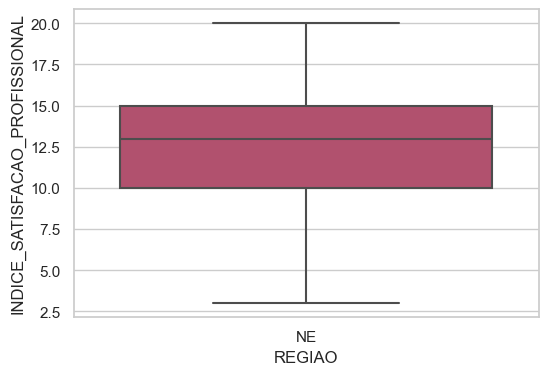

In [188]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=figsize_histbox)
#plt.yticks(dict_ticks['RENDA_POR_HH_TOTAL'][0], dict_ticks['RENDA_POR_HH_TOTAL'][1], rotation=0)
sns.boxplot(x=df_4_eda["REGIAO"], y=df_4_eda["INDICE_SATISFACAO_PROFISSIONAL"], palette='flare')
#
arquivo = 'BOXPLOT_INDICE_SATISFACAO_PROFISSIONAL_REGIAO.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

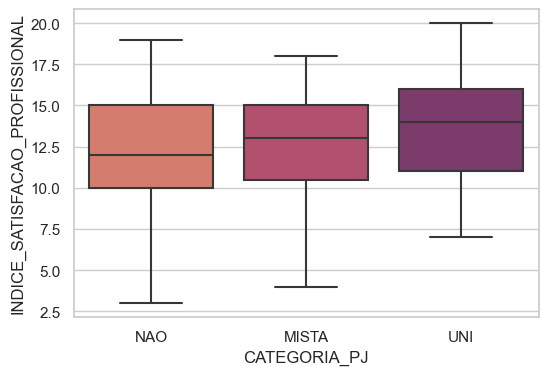

In [189]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=figsize_histbox)
#plt.yticks(dict_ticks['RENDA_POR_HH_TOTAL'][0], dict_ticks['RENDA_POR_HH_TOTAL'][1], rotation=0)
sns.boxplot(x=df_4_eda["CATEGORIA_PJ"], y=df_4_eda["INDICE_SATISFACAO_PROFISSIONAL"], palette='flare')
#
arquivo = 'BOXPLOT_INDICE_SATISFACAO_PROFISSIONAL_CATEGORIA_PJ.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

<Axes: xlabel='INDICE_SATISFACAO_PROFISSIONAL', ylabel='Probability'>

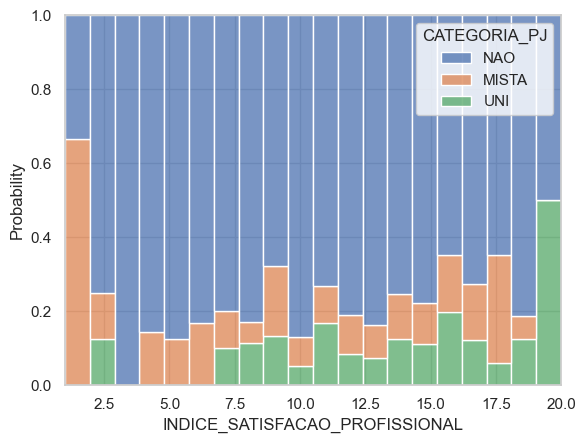

In [190]:
sns.set_theme(style="whitegrid")
sns.histplot(data=df_2_eda, x="INDICE_SATISFACAO_PROFISSIONAL", hue="CATEGORIA_PJ", stat='probability', bins=20, common_bins=True, binrange=(1,20), common_norm=True, multiple='fill',)

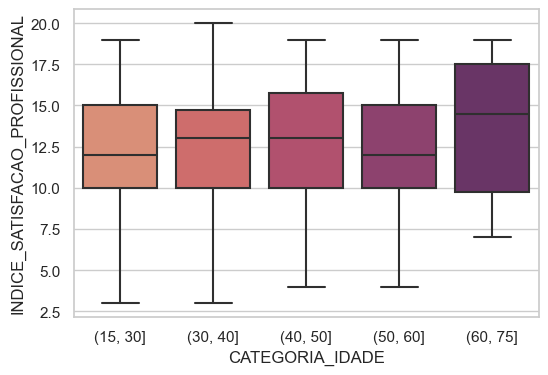

In [191]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=figsize_histbox)
#plt.yticks(dict_ticks['RENDA_POR_HH_TOTAL'][0], dict_ticks['RENDA_POR_HH_TOTAL'][1], rotation=0)
sns.boxplot(x=df_4_eda["CATEGORIA_IDADE"], y=df_4_eda["INDICE_SATISFACAO_PROFISSIONAL"], palette='flare')
#
arquivo = 'BOXPLOT_INDICE_SATISFACAO_PROFISSIONAL_CATEGORIA_IDADE.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

C:\Users\bruno\AppData\Local\Temp\ipykernel_39144\3474274445.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('viridis')


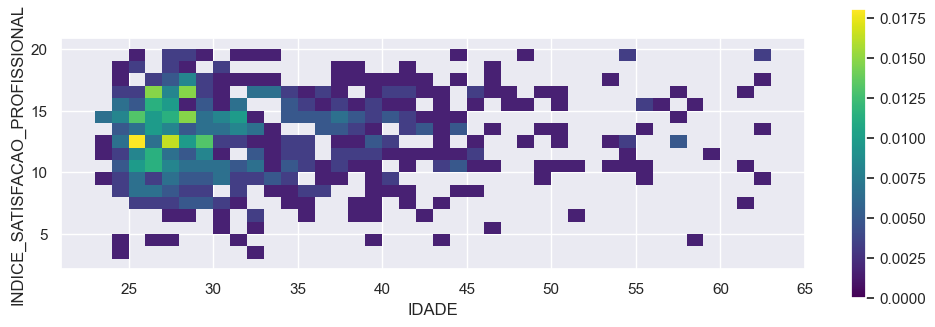

In [192]:
#sns.histplot(data=df_2_eda, x="IDADE", y="RENDA_POR_HH_TOTAL", color="skyblue", stat='density', bins=20, alpha=1, binwidth=1, discrete=False, common_norm=False, multiple='stack')

sns.set_theme(style="darkgrid")

plt.figure(figsize=(12,3))
#plt.yticks(dict_ticks['RENDA_M_INDIVIDUAL'][0], dict_ticks['RENDA_M_INDIVIDUAL'][1], rotation=0)

sns.histplot(
    data=df_4_eda,
    x="IDADE",
    y="INDICE_SATISFACAO_PROFISSIONAL",
    stat='density',
    bins=20,
    alpha=1,
    binwidth=1,
    discrete=False,
    common_norm=False,
    multiple='stack',
    cbar=True, cbar_kws=dict(shrink=1.25),
    #color='skyblue',
    cmap=plt.cm.get_cmap('viridis')
    )

arquivo = 'HEATMAP_INDICE_SATISFACAO_PROFISSIONALL_IDADE.png'
plt.savefig(os.path.join(diretorio_img, arquivo), bbox_inches='tight')

<Axes: xlabel='Probability', ylabel='INDICE_SATISFACAO_PROFISSIONAL'>

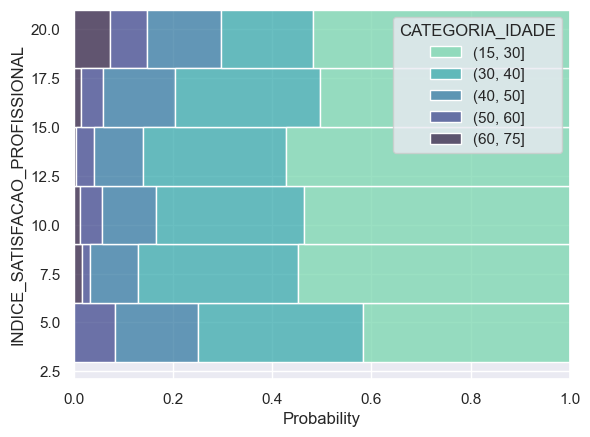

In [193]:
sns.histplot(data=df_4_eda, y="INDICE_SATISFACAO_PROFISSIONAL", hue="CATEGORIA_IDADE", palette='mako_r', stat='probability', common_bins=True, binrange=(0,20), binwidth=3, multiple='fill',legend=True)

In [426]:
df_4_eda.columns.values

array(['IDADE', 'RENDA_M_INDIVIDUAL', 'RENDA_M_FAMILIAR',
       'RENDA_FONTE_ASSALARIADO1', 'RENDA_FONTE_ASSALARIADO4',
       'RENDA_FONTE_AUTONOMO2', 'RENDA_FONTE_EMPRESARIO2',
       'FONTE_RENDA_AU', 'FONTE_RENDA_NAO_AU', 'FONTE_RENDA_EXTRA',
       'HH_EM_AU', 'HH_FORA_AU', 'RENDA_POR_HH_AU', 'RENDA_POR_HH_TOTAL',
       'ESCOLARIDADE', 'INDICE_FORMACAO_ACADEMICA',
       'INDICE_SATISFACAO_IES', 'QNTD_IDIOMAS',
       'INDICE_PARTICIPACAO_EVENTOS', 'INDICE_OBSTACULOS_PROFISSIONAIS',
       'INDICE_SATISFACAO_PROFISSIONAL', 'AVALIACAO_MERCADO_AU',
       'AVALIACAO_MERCADO_OUTROS', 'INDICE_PROJ_OBRA',
       'QNTD_ENTIDADES_FILIADAS', 'DOMINIO_INFORMATICA',
       'CATEGORIA_GENERO', 'UF', 'REGIAO', 'CATEGORIA_PJ', 'ATUACAO_INT',
       'ATUACAO_PSG', 'ATUACAO_AU', 'ATUACAO_COMP', 'ATUACAO_SEG',
       'ATUACAO_PAT', 'ATUACAO_OUTROS', 'ATUACAO_PUR', 'ATUACAO_GEO',
       'ATUACAO_ENS', 'DOMINIO_OUTROS_SOFTWARES', 'CATEGORIA_IDADE'],
      dtype=object)

In [427]:
arquivo = 'DF_CAU_02.parquet'
df_4_eda.drop(columns=['CATEGORIA_IDADE']).to_parquet(os.path.join(diretorio_df, arquivo), compression='gzip', engine='pyarrow')

In [196]:
diretorio = 'G:\\Meu Drive\\UNIFOR\\PROJETOS SOLO\\01 - CAU ML'
arquivo = 'DF_CAU_02.parquet'
#df_2_eda.to_parquet(os.path.join(diretorio, arquivo), compression='gzip', engine='pyarrow')

import pyarrow as pa

dtype_labels = {}

for coluna in df_2_eda.columns:
    dtype_labels[coluna] = df_2_eda[coluna].dtype

schema = pa.schema([(col, pa.string() if dtype_labels[col] == 'str' else pa.from_numpy_dtype(df_2_eda[col].dtype)) for col in df_2_eda.columns])
df_2_eda.to_parquet(os.path.join(diretorio, arquivo), compression='gzip', engine='pyarrow', schema=schema)

ArrowNotImplementedError: Unsupported numpy type 17

# 5. Regressões Lineares, Polinomiais e Logísticas

In [425]:
df_4_eda.describe().transpose()

count       mean        std     min  \
IDADE                            669.0  33.997010  10.092090  23.000   
RENDA_M_INDIVIDUAL               669.0   3.402093   1.259002   1.000   
RENDA_M_FAMILIAR                 669.0   4.908819   1.629370   1.000   
RENDA_FONTE_ASSALARIADO1         669.0   0.019432   0.138141   0.000   
RENDA_FONTE_ASSALARIADO4         669.0   0.037369   0.189807   0.000   
RENDA_FONTE_AUTONOMO2            669.0   0.097160   0.296397   0.000   
RENDA_FONTE_EMPRESARIO2          669.0   0.046338   0.210373   0.000   
FONTE_RENDA_AU                   669.0   1.107623   0.346607   1.000   
FONTE_RENDA_NAO_AU               669.0   0.200299   0.439719   0.000   
FONTE_RENDA_EXTRA                669.0   0.212257   0.434065   0.000   
HH_EM_AU                         669.0   4.098655   0.876753   2.000   
HH_FORA_AU                       669.0   1.374439   1.403030   0.500   
RENDA_POR_HH_AU                  669.0   0.877379   0.323591   0.200   
RENDA_POR_HH_TOTAL               669.0   0.665706   0.205406   0.125   
ESCOLARIDADE                     669.0   1.491779   0.627709   1.000   
INDICE_FORMACAO_ACADEMICA        669.0   9.512706   4.284623   1.000   
INDICE_SATISFACAO_IES            669.0   4.246637   0.732383   2.000   
QNTD_IDIOMAS                     669.0   2.387145   1.780941   0.000   
INDICE_PARTICIPACAO_EVENTOS      669.0   1.759342   0.498882   1.000   
INDICE_OBSTACULOS_PROFISSIONAIS  669.0   1.846039   0.786432   1.000   
INDICE_SATISFACAO_PROFISSIONAL   669.0  12.382661   3.308047   3.000   
AVALIACAO_MERCADO_AU             669.0   2.001495   0.784390   1.000   
AVALIACAO_MERCADO_OUTROS         669.0   4.573991   1.848121   1.000   
INDICE_PROJ_OBRA                 669.0   1.878924   0.841649   1.000   
QNTD_ENTIDADES_FILIADAS          669.0   0.222720   0.440833   0.000   
DOMINIO_INFORMATICA              669.0  14.680120   3.045942   6.000   
ATUACAO_INT                      669.0   0.701046   0.458142   0.000   
ATUACAO_PSG                      669.0   0.209268   0.407090   0.000   
ATUACAO_AU                       669.0   0.677130   0.467923   0.000   
ATUACAO_COMP                     669.0   0.179372   0.383951   0.000   
ATUACAO_SEG                      669.0   0.023916   0.152903   0.000   
ATUACAO_PAT                      669.0   0.064275   0.245426   0.000   
ATUACAO_OUTROS                   669.0   0.233184   0.423175   0.000   
ATUACAO_PUR                      669.0   0.137519   0.344652   0.000   
ATUACAO_GEO                      669.0   0.065770   0.248065   0.000   
ATUACAO_ENS                      669.0   0.119581   0.324714   0.000   
DOMINIO_OUTROS_SOFTWARES         669.0   3.143498   1.712155   0.000   

                                       25%        50%        75%        max  
IDADE                            27.000000  30.000000  39.000000  73.000000  
RENDA_M_INDIVIDUAL                3.000000   3.000000   4.000000   7.000000  
RENDA_M_FAMILIAR                  4.000000   5.000000   6.000000   8.000000  
RENDA_FONTE_ASSALARIADO1          0.000000   0.000000   0.000000   1.000000  
RENDA_FONTE_ASSALARIADO4          0.000000   0.000000   0.000000   1.000000  
RENDA_FONTE_AUTONOMO2             0.000000   0.000000   0.000000   1.000000  
RENDA_FONTE_EMPRESARIO2           0.000000   0.000000   0.000000   1.000000  
FONTE_RENDA_AU                    1.000000   1.000000   1.000000   4.000000  
FONTE_RENDA_NAO_AU                0.000000   0.000000   0.000000   3.000000  
FONTE_RENDA_EXTRA                 0.000000   0.000000   0.000000   2.000000  
HH_EM_AU                          4.000000   4.000000   5.000000   5.000000  
HH_FORA_AU                        0.500000   0.500000   2.000000   5.000000  
RENDA_POR_HH_AU                   0.750000   0.800000   1.000000   3.000000  
RENDA_POR_HH_TOTAL                0.545455   0.666667   0.727273   1.555556  
ESCOLARIDADE                      1.000000   1.000000   2.000000   4.000000  
INDICE_FORMACAO_ACADEMICA         7.000000  10.0

C:\Users\bruno\AppData\Local\Temp\ipykernel_39144\2657284894.py:35: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(np.zeros_like(x), y, z, 'r.', alpha=1, markersize=4, marker='+')


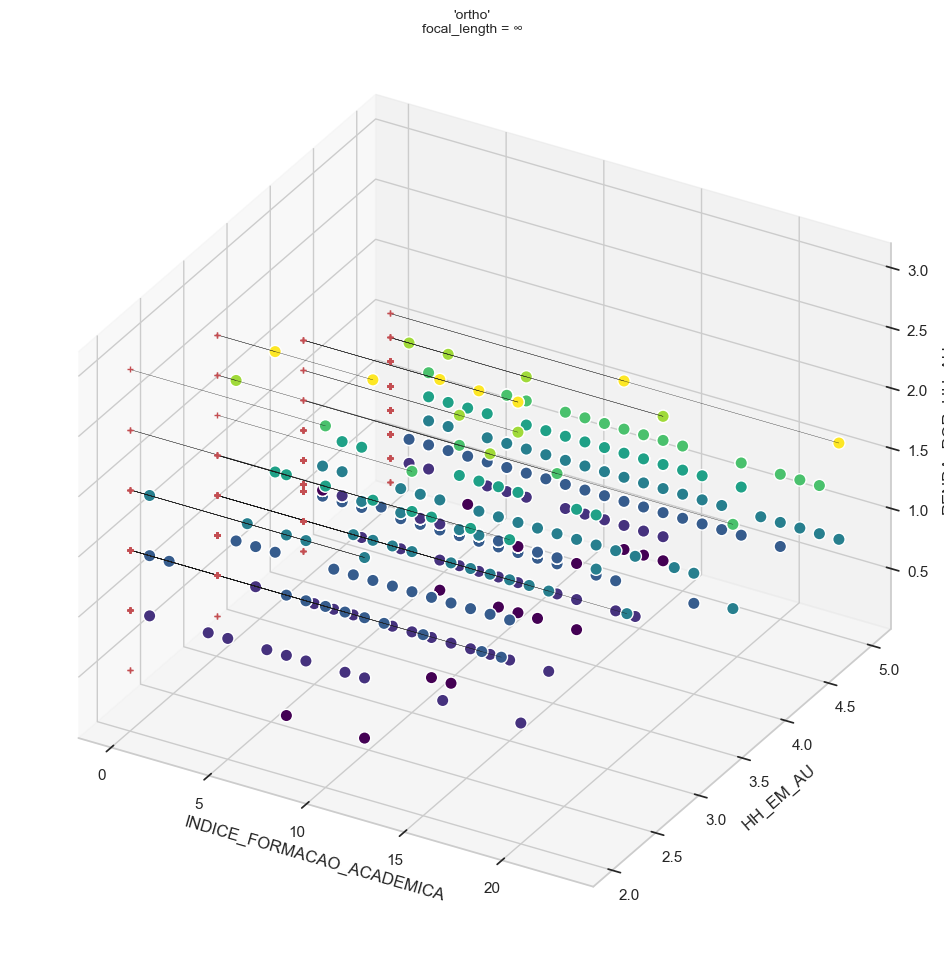

In [584]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

ax.set_proj_type('ortho')  # FOV = 0 deg
ax.set_title("'ortho'\nfocal_length = ∞", fontsize=10)

label_x = 'INDICE_FORMACAO_ACADEMICA'
label_y = 'HH_EM_AU'
label_z = 'RENDA_POR_HH_AU'

x = df_4_eda[label_x].tolist()
y = df_4_eda[label_y].tolist()
z = df_4_eda[label_z].tolist()

threshold = np.percentile(z, 90)

cor = df_4_eda['RENDA_M_INDIVIDUAL']


for i in range(len(x)):
    if z[i] >= threshold:
        #ax.plot([x[i], x[i]], [y[i], y[i]], [0, z[i]], 'k', alpha=1, linewidth=.25)
        ax.plot([x[i], 0], [y[i], y[i]], [z[i], z[i]], 'k', alpha=1, linewidth=.25) 
        #ax.plot([x[i], x[i]], [y[i], 0], [z[i], z[i]], 'k', alpha=1, linewidth=.25) 

    
#ax.plot(x, y, np.zeros_like(z), 'g.', alpha=1, markersize=6, marker='+')
#ax.plot(x, np.zeros_like(y), z, 'b.', alpha=1, markersize=6, marker='+')
ax.plot(np.zeros_like(x), y, z, 'r.', alpha=1, markersize=4, marker='+')

scatter = ax.scatter(x, y, z, s=80, edgecolors='w', c=cor, alpha=1, cmap='viridis')

ax.set_xlabel(label_x)
ax.set_ylabel(label_y)
ax.set_zlabel(label_z)
plt.show()

<class 'numpy.ndarray'>


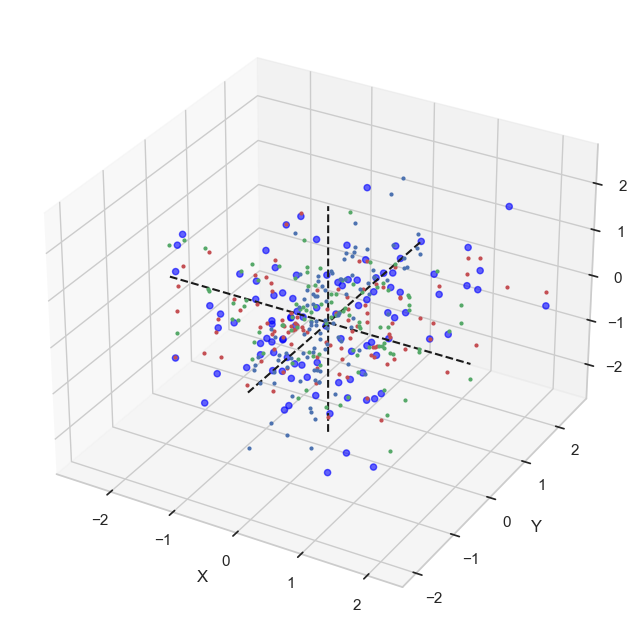

In [537]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Dados de exemplo
x = np.random.normal(size=100)
y = np.random.normal(size=100)
z = np.random.normal(size=100)
print(type(z))

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
ax.scatter(x, y, z, color='blue', alpha=0.6)

# Projeções nos planos
ax.plot([0, 0], [0, 0], [min(z), max(z)], 'k--')  # Plano XY
ax.plot([0, 0], [min(y), max(y)], [0, 0], 'k--')  # Plano XZ
ax.plot([min(x), max(x)], [0, 0], [0, 0], 'k--')  # Plano YZ

# Projeção nos planos XY
ax.plot(x, y, np.zeros_like(z), 'r.', markersize=4)

# Projeção nos planos XZ
ax.plot(x, np.zeros_like(y), z, 'g.', markersize=4)

# Projeção nos planos YZ
ax.plot(np.zeros_like(x), y, z, 'b.', markersize=4)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

[[ 1  2  3  4  5  6  7  8  9]
 [ 2  4  6  8 10 12 14 16 18]
 [ 3  6  9 12 15 18 21 24 27]
 [ 4  8 12 16 20 24 28 32 36]
 [ 5 10 15 20 25 30 35 40 45]
 [ 6 12 18 24 30 36 42 48 54]
 [ 7 14 21 28 35 42 49 56 63]
 [ 8 16 24 32 40 48 56 64 72]
 [ 9 18 27 36 45 54 63 72 81]]


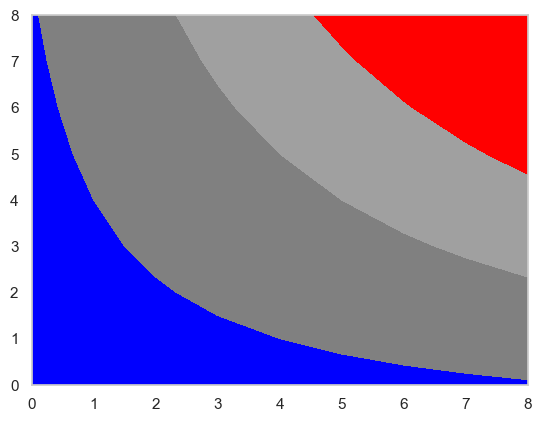

In [477]:
x = np.arange(1, 10)
y = x.reshape(-1, 1)
h = x * y
print(h)

cs = plt.contourf(h, levels=[10, 30, 50],
    colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
cs.changed()

In [430]:
df_4_eda.describe().transpose()

count       mean        std     min  \
IDADE                            669.0  33.997010  10.092090  23.000   
RENDA_M_INDIVIDUAL               669.0   3.402093   1.259002   1.000   
RENDA_M_FAMILIAR                 669.0   4.908819   1.629370   1.000   
RENDA_FONTE_ASSALARIADO1         669.0   0.019432   0.138141   0.000   
RENDA_FONTE_ASSALARIADO4         669.0   0.037369   0.189807   0.000   
RENDA_FONTE_AUTONOMO2            669.0   0.097160   0.296397   0.000   
RENDA_FONTE_EMPRESARIO2          669.0   0.046338   0.210373   0.000   
FONTE_RENDA_AU                   669.0   1.107623   0.346607   1.000   
FONTE_RENDA_NAO_AU               669.0   0.200299   0.439719   0.000   
FONTE_RENDA_EXTRA                669.0   0.212257   0.434065   0.000   
HH_EM_AU                         669.0   4.098655   0.876753   2.000   
HH_FORA_AU                       669.0   1.374439   1.403030   0.500   
RENDA_POR_HH_AU                  669.0   0.877379   0.323591   0.200   
RENDA_POR_HH_TOTAL               669.0   0.665706   0.205406   0.125   
ESCOLARIDADE                     669.0   1.491779   0.627709   1.000   
INDICE_FORMACAO_ACADEMICA        669.0   9.512706   4.284623   1.000   
INDICE_SATISFACAO_IES            669.0   4.246637   0.732383   2.000   
QNTD_IDIOMAS                     669.0   2.387145   1.780941   0.000   
INDICE_PARTICIPACAO_EVENTOS      669.0   1.759342   0.498882   1.000   
INDICE_OBSTACULOS_PROFISSIONAIS  669.0   1.846039   0.786432   1.000   
INDICE_SATISFACAO_PROFISSIONAL   669.0  12.382661   3.308047   3.000   
AVALIACAO_MERCADO_AU             669.0   2.001495   0.784390   1.000   
AVALIACAO_MERCADO_OUTROS         669.0   4.573991   1.848121   1.000   
INDICE_PROJ_OBRA                 669.0   1.878924   0.841649   1.000   
QNTD_ENTIDADES_FILIADAS          669.0   0.222720   0.440833   0.000   
DOMINIO_INFORMATICA              669.0  14.680120   3.045942   6.000   
ATUACAO_INT                      669.0   0.701046   0.458142   0.000   
ATUACAO_PSG                      669.0   0.209268   0.407090   0.000   
ATUACAO_AU                       669.0   0.677130   0.467923   0.000   
ATUACAO_COMP                     669.0   0.179372   0.383951   0.000   
ATUACAO_SEG                      669.0   0.023916   0.152903   0.000   
ATUACAO_PAT                      669.0   0.064275   0.245426   0.000   
ATUACAO_OUTROS                   669.0   0.233184   0.423175   0.000   
ATUACAO_PUR                      669.0   0.137519   0.344652   0.000   
ATUACAO_GEO                      669.0   0.065770   0.248065   0.000   
ATUACAO_ENS                      669.0   0.119581   0.324714   0.000   
DOMINIO_OUTROS_SOFTWARES         669.0   3.143498   1.712155   0.000   

                                       25%        50%        75%        max  
IDADE                            27.000000  30.000000  39.000000  73.000000  
RENDA_M_INDIVIDUAL                3.000000   3.000000   4.000000   7.000000  
RENDA_M_FAMILIAR                  4.000000   5.000000   6.000000   8.000000  
RENDA_FONTE_ASSALARIADO1          0.000000   0.000000   0.000000   1.000000  
RENDA_FONTE_ASSALARIADO4          0.000000   0.000000   0.000000   1.000000  
RENDA_FONTE_AUTONOMO2             0.000000   0.000000   0.000000   1.000000  
RENDA_FONTE_EMPRESARIO2           0.000000   0.000000   0.000000   1.000000  
FONTE_RENDA_AU                    1.000000   1.000000   1.000000   4.000000  
FONTE_RENDA_NAO_AU                0.000000   0.000000   0.000000   3.000000  
FONTE_RENDA_EXTRA                 0.000000   0.000000   0.000000   2.000000  
HH_EM_AU                          4.000000   4.000000   5.000000   5.000000  
HH_FORA_AU                        0.500000   0.500000   2.000000   5.000000  
RENDA_POR_HH_AU                   0.750000   0.800000   1.000000   3.000000  
RENDA_POR_HH_TOTAL                0.545455   0.666667   0.727273   1.555556  
ESCOLARIDADE                      1.000000   1.000000   2.000000   4.000000  
INDICE_FORMACAO_ACADEMICA         7.000000  10.0

c:\Users\bruno\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


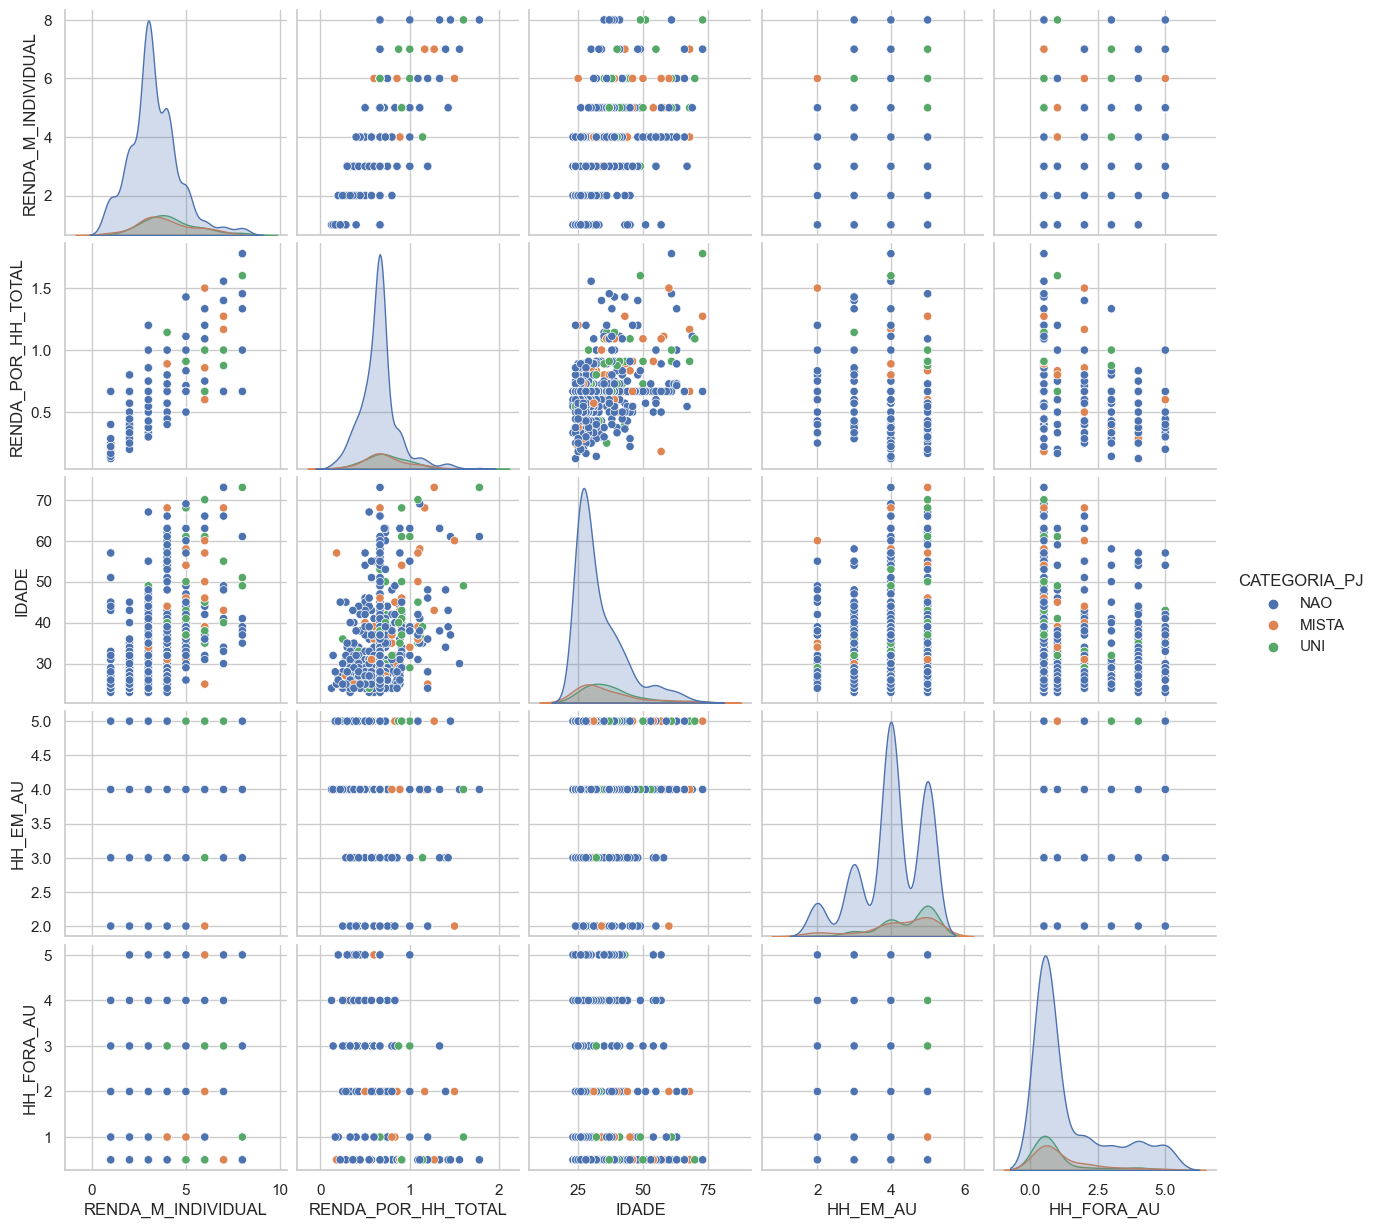

In [433]:
df_sns = df_4_eda[['RENDA_M_INDIVIDUAL','RENDA_POR_HH_TOTAL','IDADE','HH_EM_AU','HH_FORA_AU','CATEGORIA_PJ']]
sns.pairplot(df_sns, hue='CATEGORIA_PJ', kind='scatter', diag_kind='auto')
#{‘scatter’, ‘kde’, ‘hist’, ‘reg’}
#diag_kind{‘auto’, ‘hist’, ‘kde’, None}

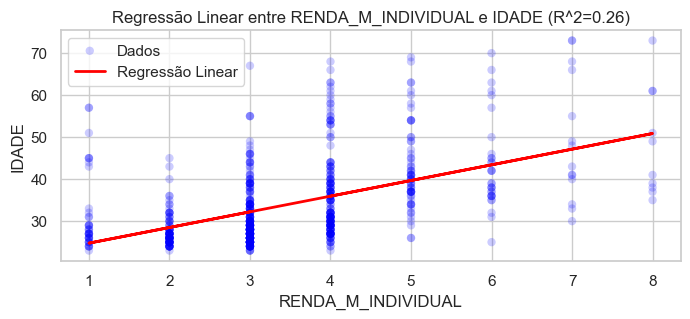

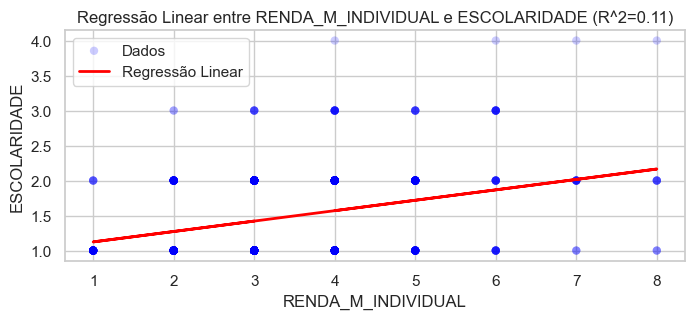

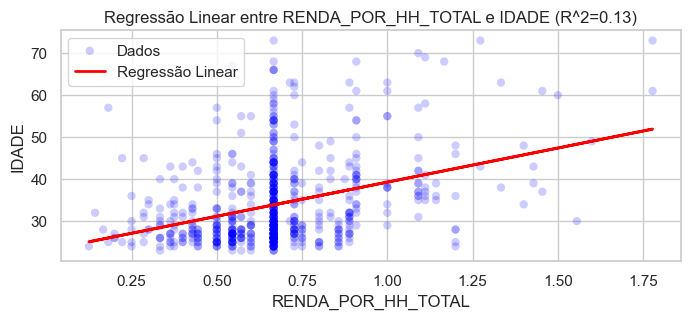

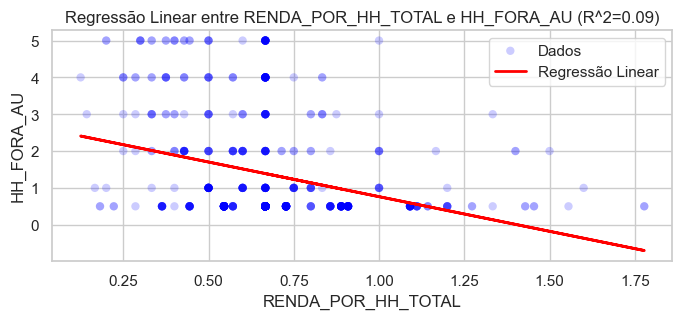

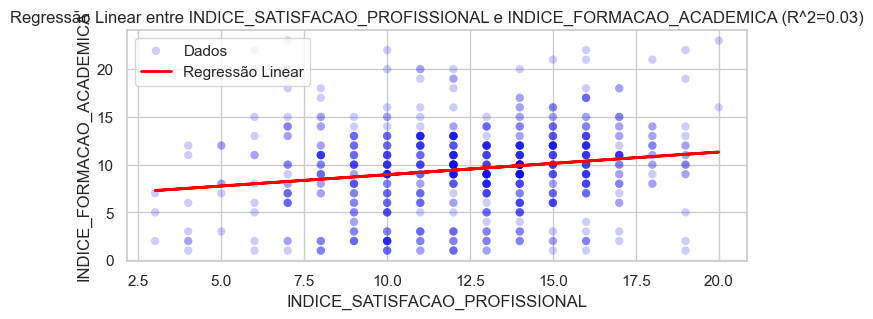

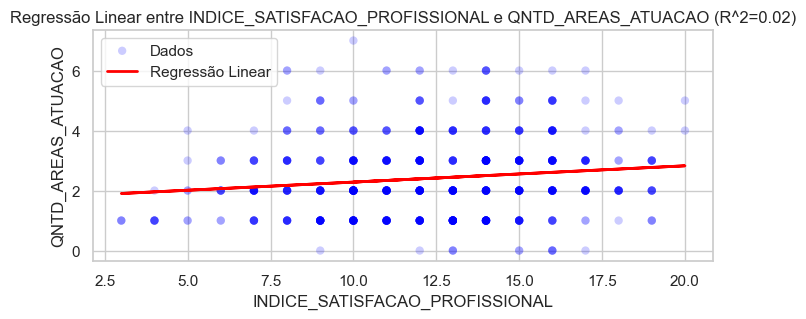

In [435]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

df_4_eda['QNTD_AREAS_ATUACAO'] = df_4_eda.filter(regex='^ATUACAO_', axis=1).sum(axis=1)



# Lista de variáveis dependentes e independentes
variaveis_dependentes = ['INDICE_FORMACAO_ACADEMICA', 'ESCOLARIDADE', 'IDADE', 'HH_EM_AU', 'HH_FORA_AU', 'QNTD_AREAS_ATUACAO', 'INDICE_PROJ_OBRA', 'DOMINIO_INFORMATICA', 'QNTD_IDIOMAS']
variaveis_independentes = ['RENDA_M_INDIVIDUAL', 'RENDA_POR_HH_TOTAL', 'INDICE_SATISFACAO_PROFISSIONAL']  
lista_variaveis = variaveis_dependentes + variaveis_independentes

df_regressoes = df_4_eda[lista_variaveis].dropna()

# Para cada variável independente
for var_ind in variaveis_independentes:
    # Criar um DataFrame temporário para armazenar os resultados
    resultados = {'variavel_dependente': [], 'r2_score': []}

    # Para cada variável dependente
    for var_dep in variaveis_dependentes:
        # Selecionar os dados relevantes
        dados = df_regressoes[[var_ind, var_dep]].dropna()  # Remover linhas com valores nulos
        
        if len(dados) > 0:  # Verificar se há dados para a análise
            # Calcular o coeficiente de determinação (R^2)
            X = dados[[var_ind]]
            y = dados[var_dep]
            model = LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)
            r2 = r2_score(y, y_pred)

            # Armazenar os resultados
            resultados['variavel_dependente'].append(var_dep)
            resultados['r2_score'].append(r2)

    # Ordenar os resultados pelo R^2 em ordem decrescente
    resultados_df = pd.DataFrame(resultados)
    resultados_df = resultados_df.sort_values(by='r2_score', ascending=False)

    # Selecionar as duas variáveis dependentes com maior valor de R^2
    top_var_dependentes = resultados_df['variavel_dependente'].head(2)

    # Plotar o gráfico da regressão para as duas variáveis dependentes com maior valor de R^2
    for var_dep in top_var_dependentes:
        dados = df_regressoes[[var_ind, var_dep]].dropna()
        X = dados[[var_ind]]
        y = dados[var_dep]
        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)

        # Plotar o gráfico da regressão
        plt.figure(figsize=(8, 3))
        plt.scatter(X, y, color='blue', label='Dados', alpha=0.2, edgecolors='none')
        plt.plot(X, y_pred, color='red', linewidth=2, label='Regressão Linear')
        plt.title(f'Regressão Linear entre {var_ind} e {var_dep} (R^2={r2:.2f})')
        plt.xlabel(var_ind)
        plt.ylabel(var_dep)
        plt.legend()
        plt.grid(True)
        plt.show()

## Distribuições

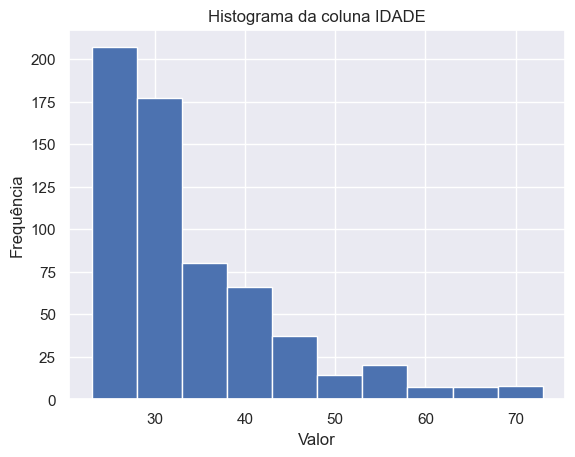

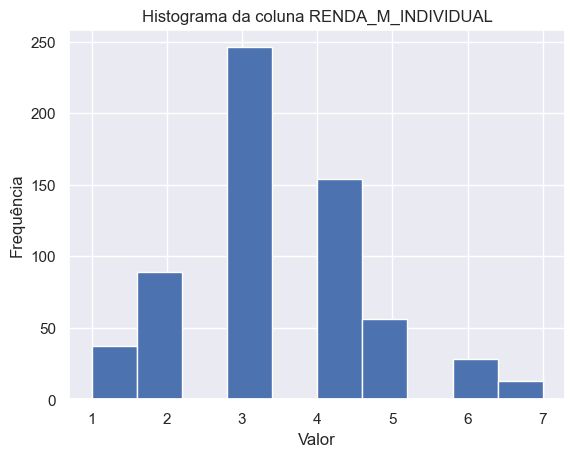

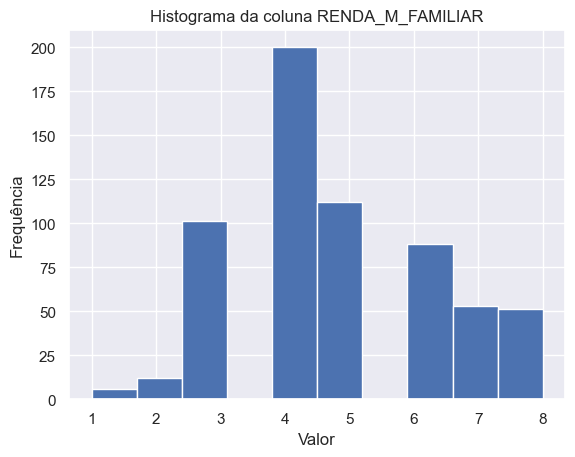

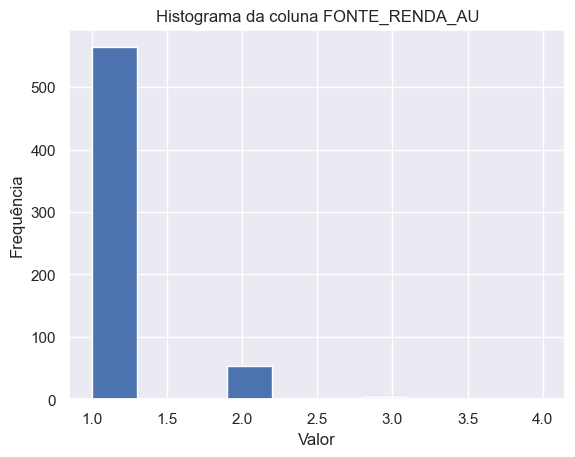

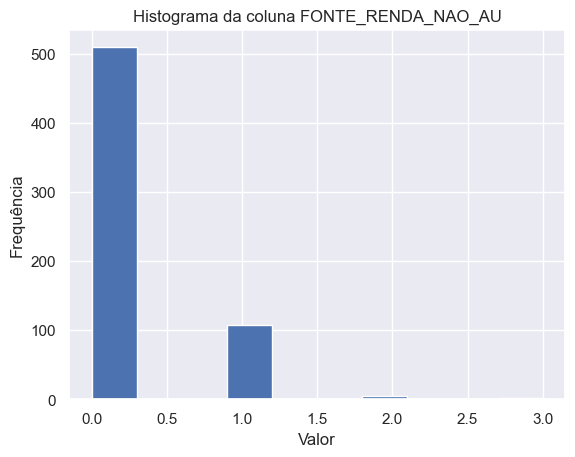

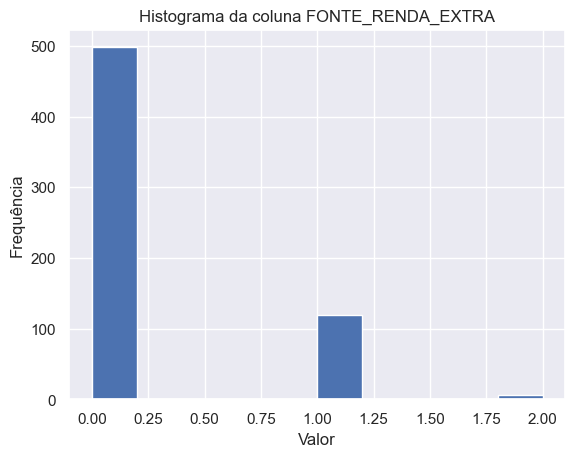

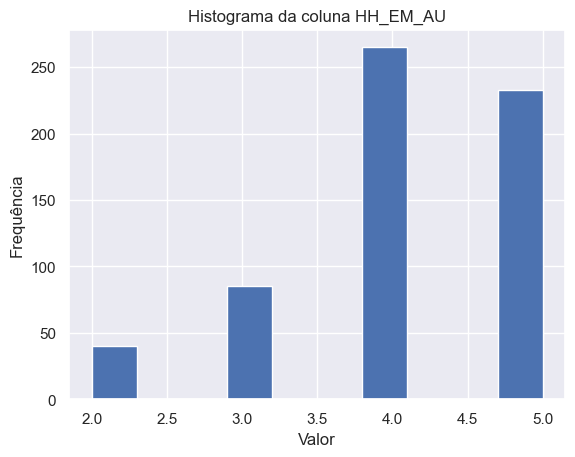

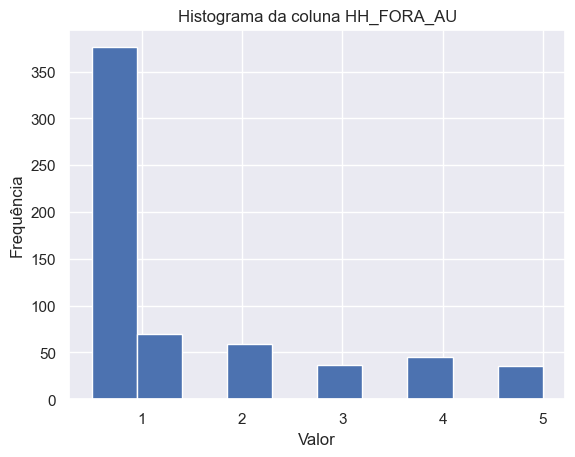

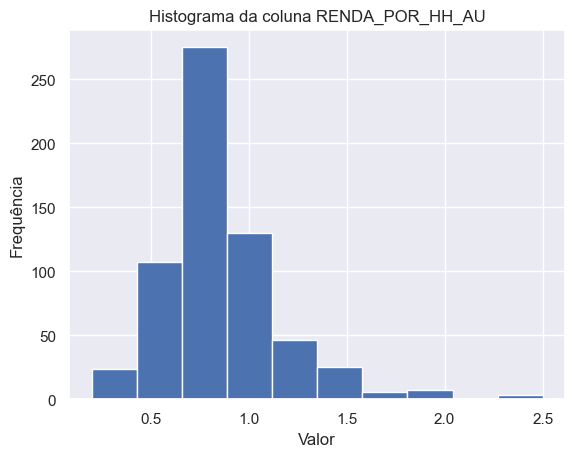

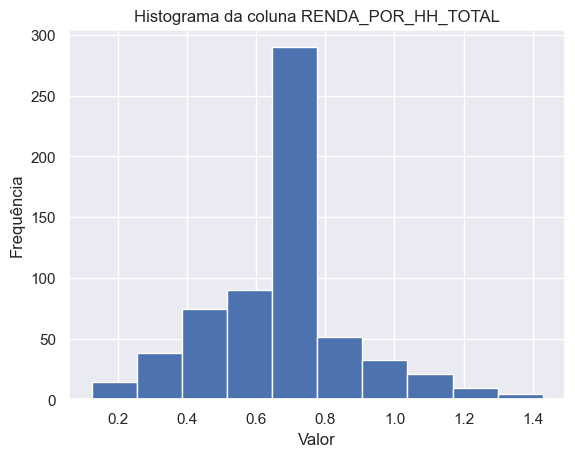

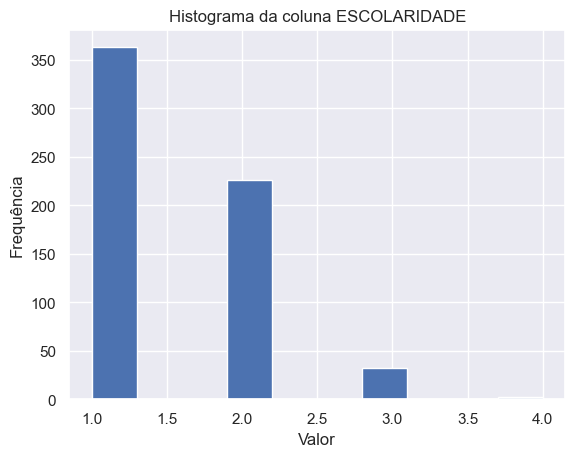

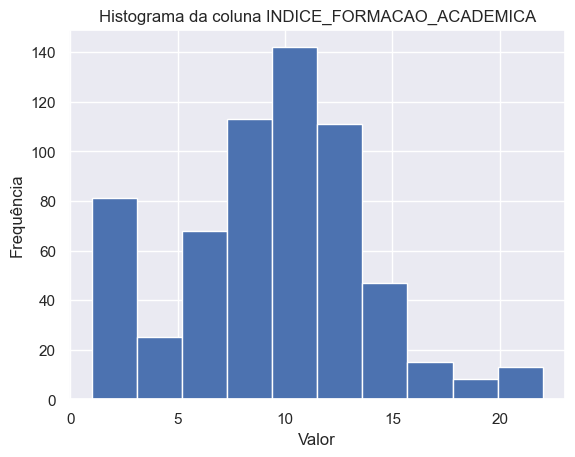

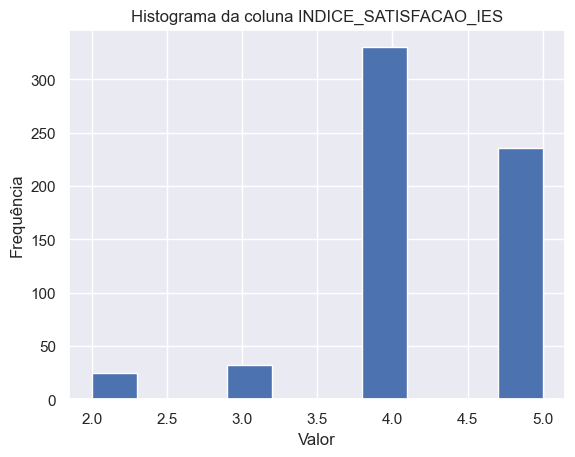

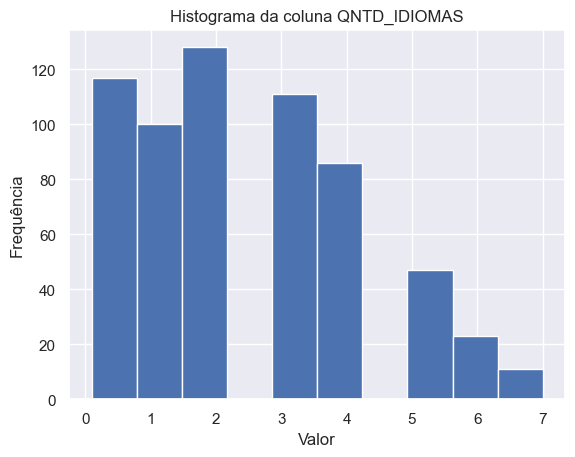

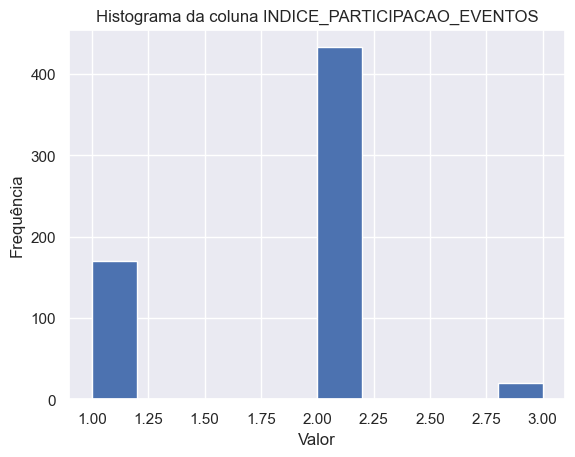

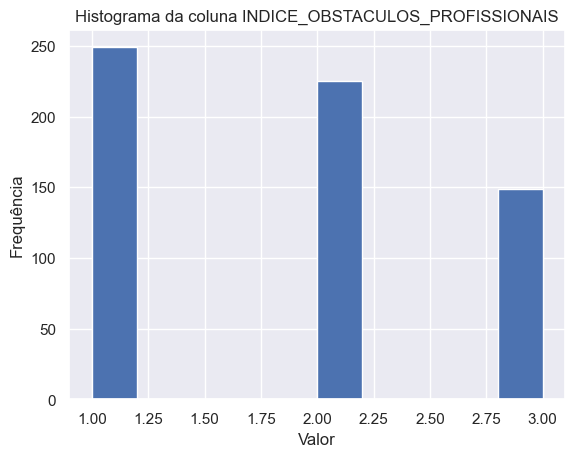

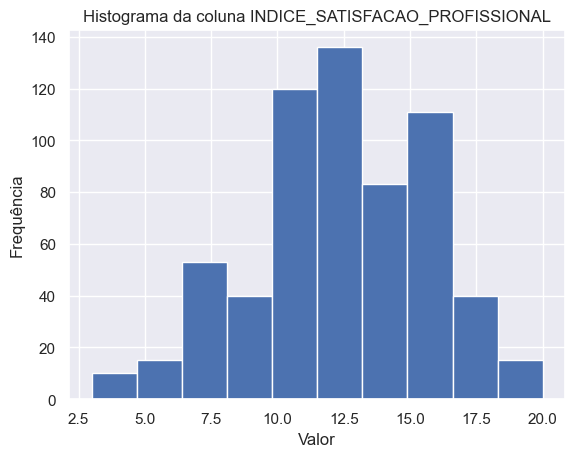

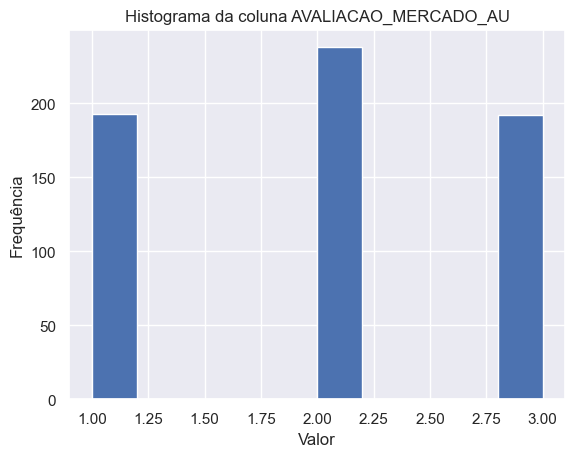

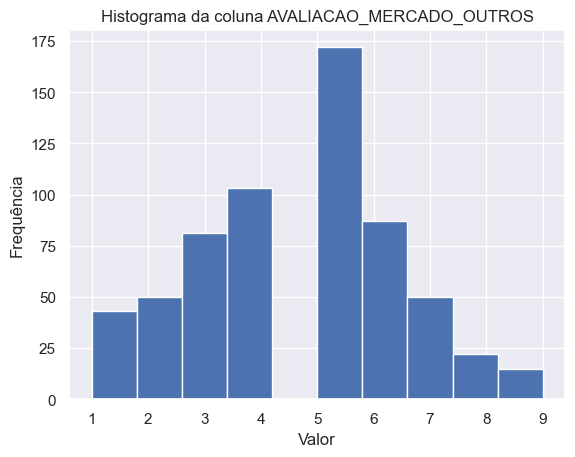

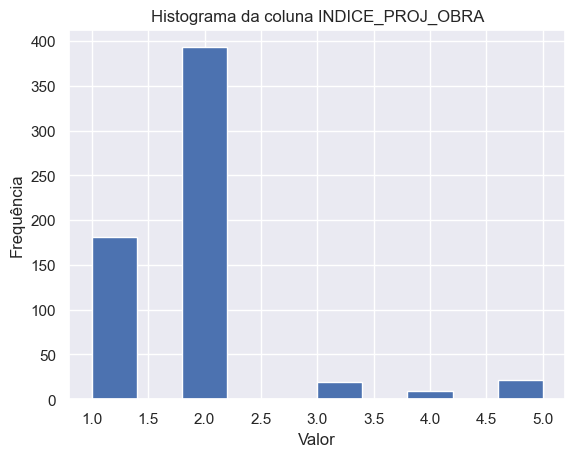

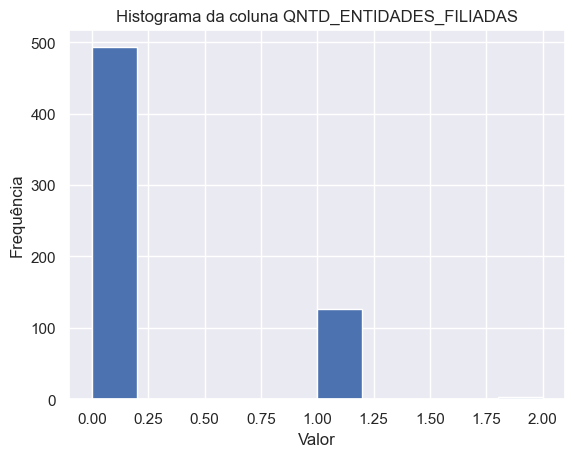

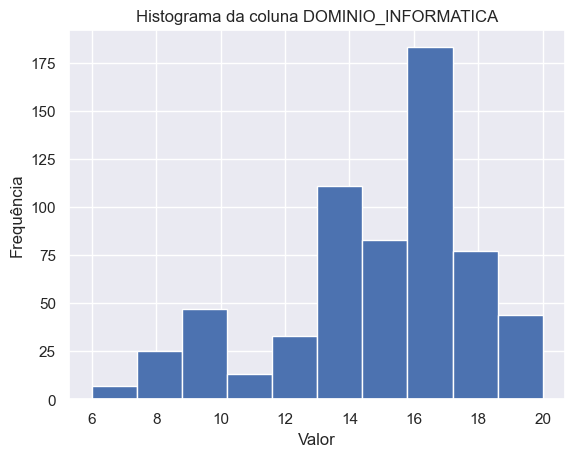

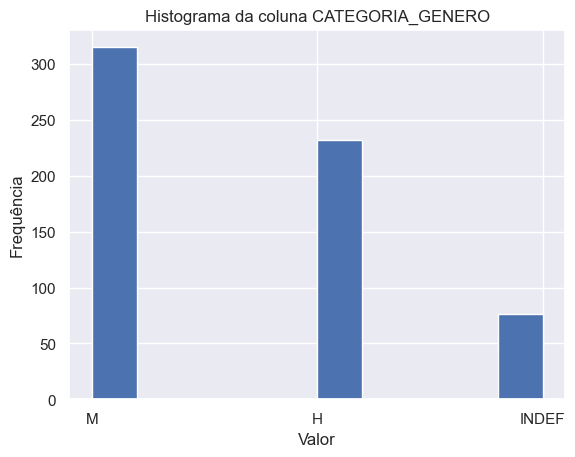

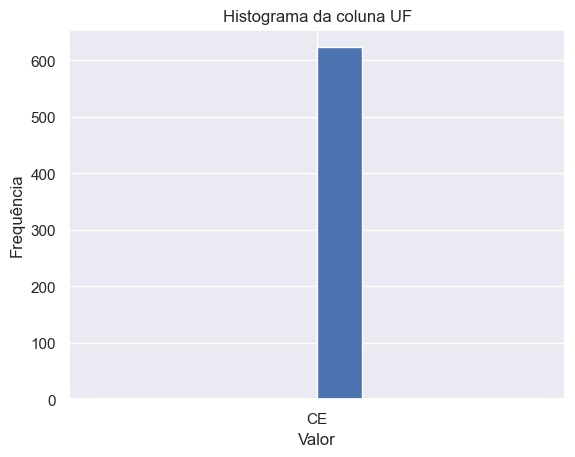

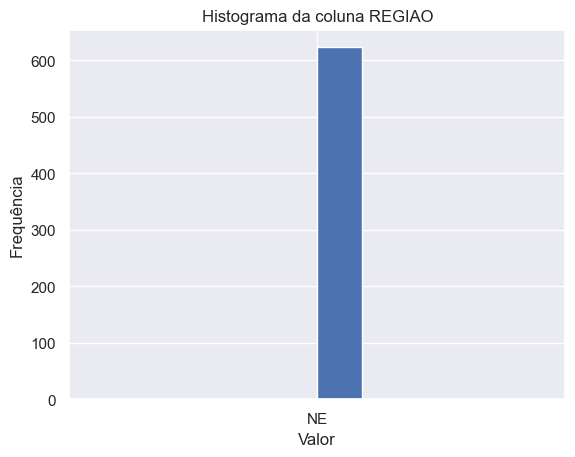

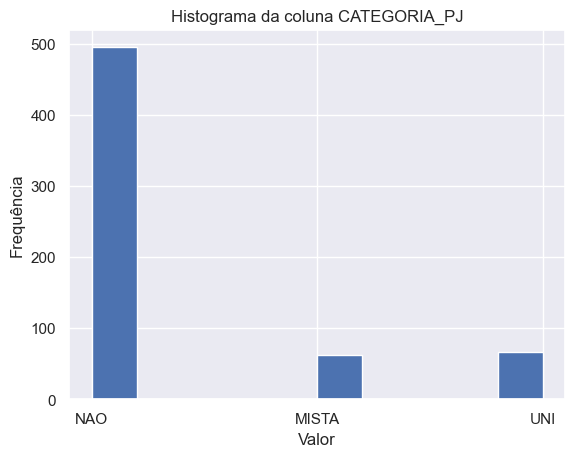

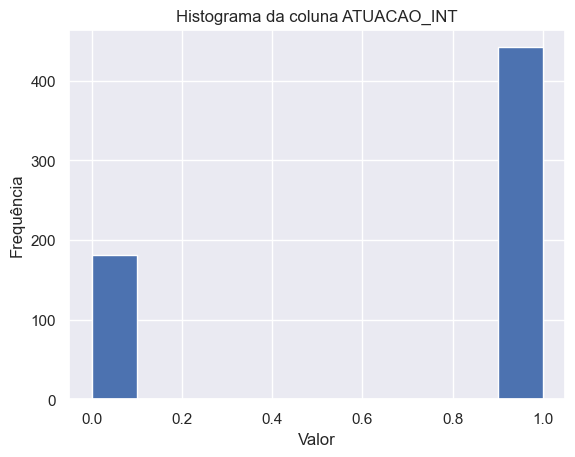

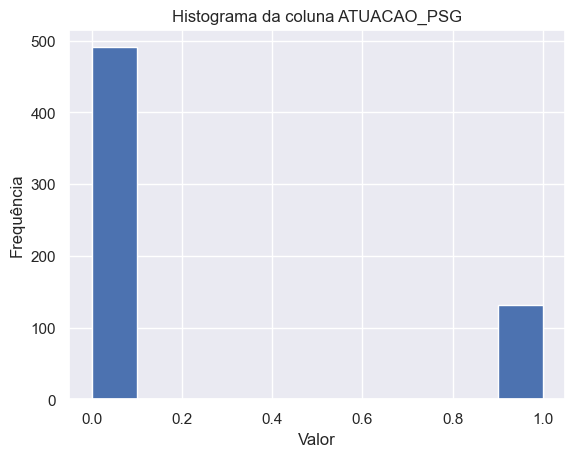

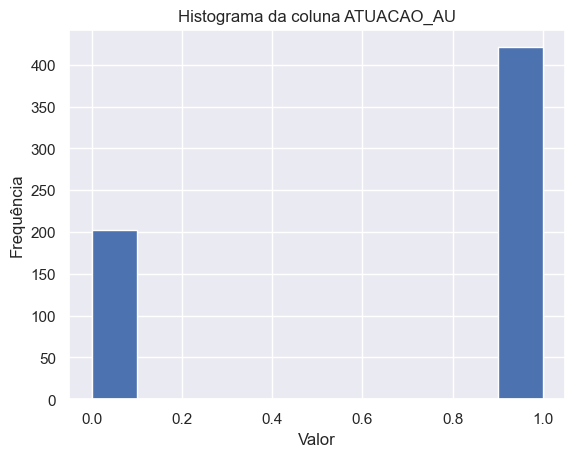

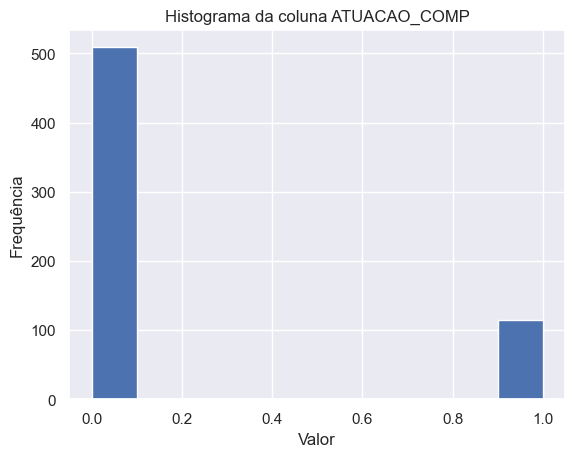

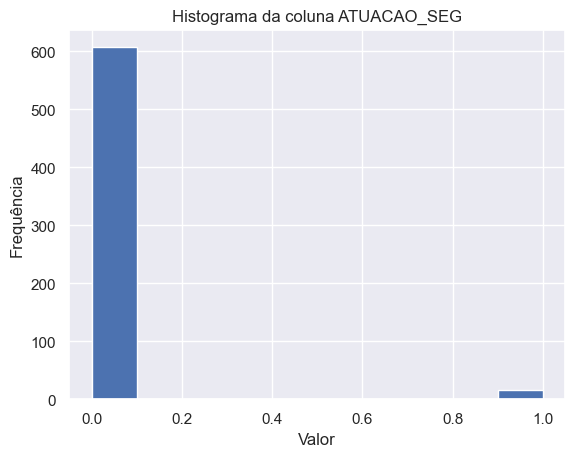

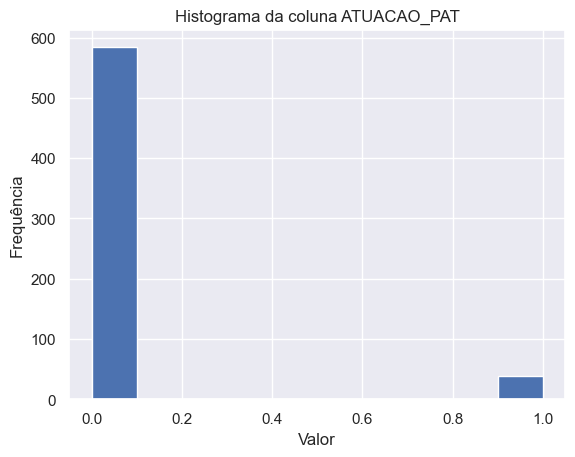

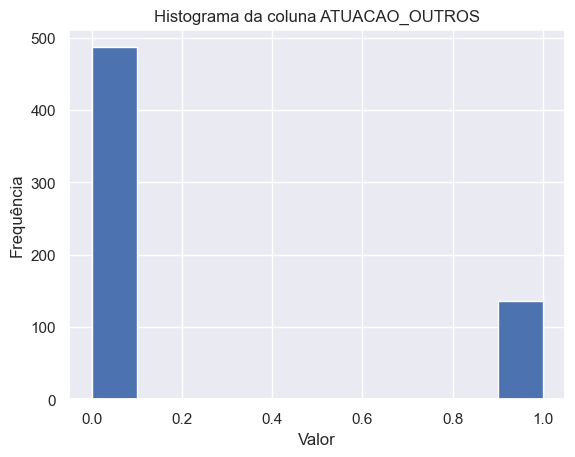

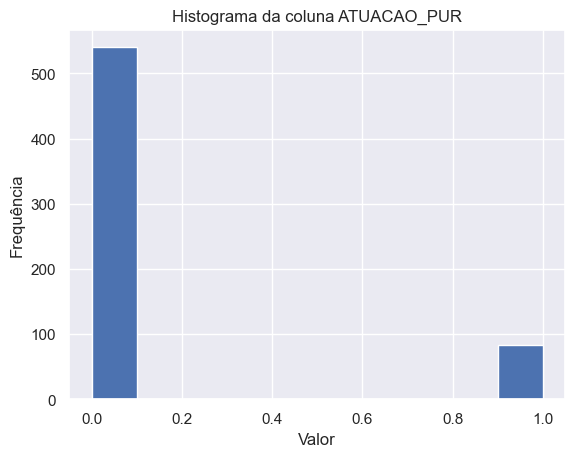

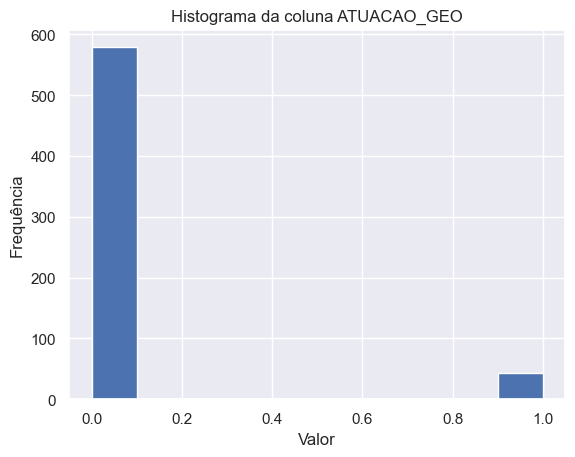

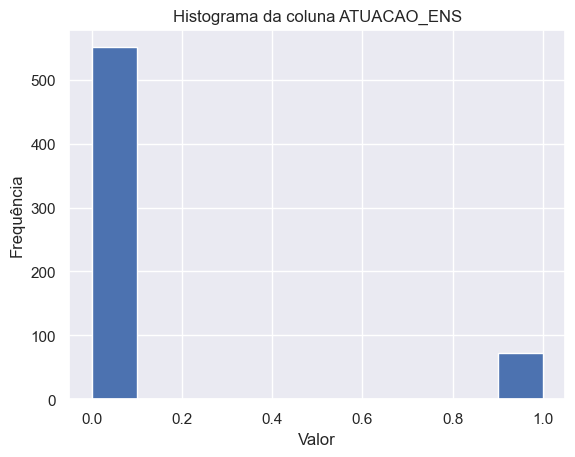

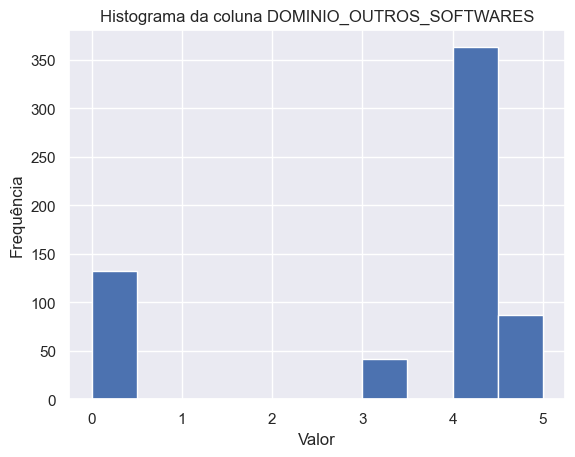

TypeError: '<' not supported between instances of 'pandas._libs.interval.Interval' and 'float'

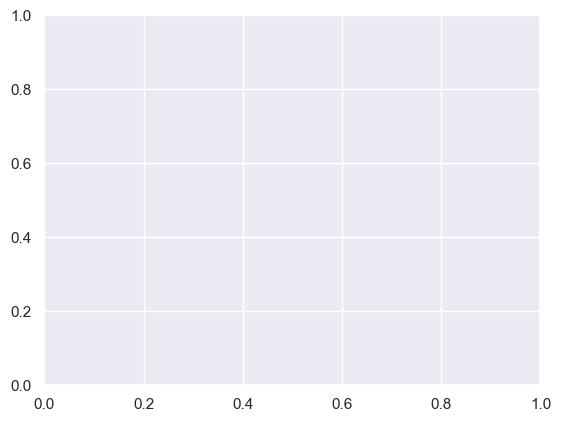

In [ ]:
import matplotlib.pyplot as plt
for column in df_4_eda.columns:
    plt.hist(df_4_eda[column])  # Define o número de bins como 10
    plt.title(f'Histograma da coluna {column}')
    plt.xlabel('Valor')
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.show()

# 4. Exportação

In [446]:
diretorio = 'G:\\Meu Drive\\UNIFOR\\PROJETOS SOLO\\01 - CAU ML'
arquivo = 'DF_CAU_02.parquet'
df_4_eda.drop(columns=['CATEGORIA_IDADE']).to_parquet(os.path.join(diretorio, arquivo), engine='pyarrow', compression='gzip')

In [447]:
df_4_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 669 entries, 32 to 45354
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   IDADE                            669 non-null    int32   
 1   RENDA_M_INDIVIDUAL               669 non-null    float64 
 2   RENDA_M_FAMILIAR                 669 non-null    float64 
 3   RENDA_FONTE_ASSALARIADO1         669 non-null    int8    
 4   RENDA_FONTE_ASSALARIADO4         669 non-null    int8    
 5   RENDA_FONTE_AUTONOMO2            669 non-null    int8    
 6   RENDA_FONTE_EMPRESARIO2          669 non-null    int8    
 7   FONTE_RENDA_AU                   669 non-null    float64 
 8   FONTE_RENDA_NAO_AU               669 non-null    int32   
 9   FONTE_RENDA_EXTRA                669 non-null    int32   
 10  HH_EM_AU                         669 non-null    float64 
 11  HH_FORA_AU                       669 non-null    float64 
 12  RENDA_POR_